# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size),
                                   transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    return dataloader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 24
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

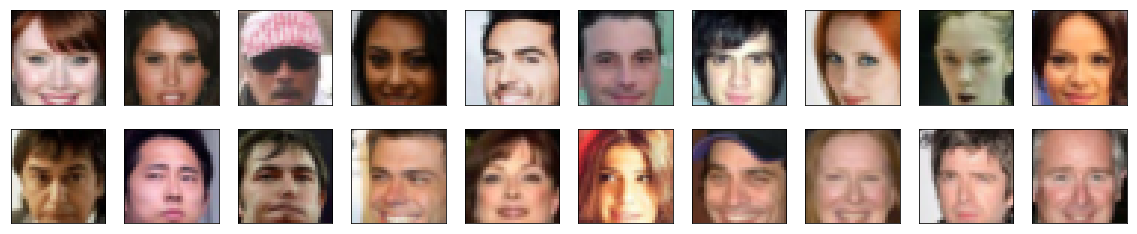

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_x, max_x = feature_range
    x = x * (max_x - min_x) + min_x
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.9765)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Create a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # 32*32
        x = F.leaky_relu(self.conv1(x), 0.2)
        # 16*16
        x = F.leaky_relu(self.conv2(x), 0.2)
        # 8*8
        x = F.leaky_relu(self.conv3(x), 0.2)
        # 4*4
        
        x = x.view(-1, self.conv_dim*4*4*4)
        
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) 
        # (batch_size, depth, 4, 4)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        
        x = self.deconv3(x)
        x = torch.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       :param D_out: discriminator logits
       :param smooth: boolean for smootjing labels
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim
# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            # zero accumulated gradients
            d_optimizer.zero_grad()
            
            # move real images to gpu if available
            if train_on_gpu:
                real_images = real_images.cuda()
            # get output of discriminator for real image
            d_out = D(real_images)
            # calculate loss for real image
            d_real_loss = real_loss(d_out, smooth=True)
            
            ## generate fake images
            # generate latent vector
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move latent vector to gpu if available
            if train_on_gpu:
                z = z.cuda()
            # generate fake images
            fake_images = G(z)
            # get output of discriminator for fake images
            d_out = D(fake_images)
            # calculate loss for fake images
            d_fake_loss = fake_loss(d_out)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            
            # 2. Train the generator with an adversarial loss
            
            # zero accumulated gradients
            g_optimizer.zero_grad()
            
            # generate latent vector
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move latent vector to gpu if available
            if train_on_gpu:
                z = z.cuda()
            # generate fake images
            generated_images = G(z)
            
            # get output of discriminator on generated images
            d_out = D(generated_images)
            # compute the discriminator losses on generated images using flipped labels
            g_loss = real_loss(d_out)
            
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 500


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  500] | d_loss: 1.3835 | g_loss: 0.8592
Epoch [    1/  500] | d_loss: 0.4783 | g_loss: 2.6473
Epoch [    1/  500] | d_loss: 0.4119 | g_loss: 3.5344
Epoch [    1/  500] | d_loss: 0.6456 | g_loss: 2.5002
Epoch [    1/  500] | d_loss: 0.4458 | g_loss: 2.9887
Epoch [    1/  500] | d_loss: 0.4922 | g_loss: 2.1987
Epoch [    1/  500] | d_loss: 0.5298 | g_loss: 2.8136
Epoch [    1/  500] | d_loss: 0.6296 | g_loss: 2.1236
Epoch [    1/  500] | d_loss: 0.5224 | g_loss: 2.7160
Epoch [    1/  500] | d_loss: 0.7927 | g_loss: 1.5311
Epoch [    1/  500] | d_loss: 0.8471 | g_loss: 1.9517
Epoch [    1/  500] | d_loss: 1.4871 | g_loss: 1.6994
Epoch [    1/  500] | d_loss: 0.9251 | g_loss: 1.0105
Epoch [    1/  500] | d_loss: 0.8535 | g_loss: 1.3918
Epoch [    1/  500] | d_loss: 1.6283 | g_loss: 1.2186
Epoch [    1/  500] | d_loss: 0.9830 | g_loss: 1.9267
Epoch [    1/  500] | d_loss: 1.2015 | g_loss: 1.3797
Epoch [    1/  500] | d_loss: 1.3147 | g_loss: 1.2473
Epoch [    1/  500] | d_loss

Epoch [    3/  500] | d_loss: 0.8522 | g_loss: 1.3481
Epoch [    3/  500] | d_loss: 1.0927 | g_loss: 1.5874
Epoch [    3/  500] | d_loss: 1.2327 | g_loss: 1.0210
Epoch [    3/  500] | d_loss: 0.8174 | g_loss: 1.7143
Epoch [    3/  500] | d_loss: 1.2228 | g_loss: 1.2504
Epoch [    3/  500] | d_loss: 0.9307 | g_loss: 1.1276
Epoch [    3/  500] | d_loss: 1.1171 | g_loss: 1.5426
Epoch [    3/  500] | d_loss: 1.0373 | g_loss: 0.9062
Epoch [    3/  500] | d_loss: 1.2328 | g_loss: 1.2904
Epoch [    3/  500] | d_loss: 0.9514 | g_loss: 1.8968
Epoch [    3/  500] | d_loss: 1.0656 | g_loss: 1.6903
Epoch [    3/  500] | d_loss: 1.0410 | g_loss: 1.3607
Epoch [    3/  500] | d_loss: 0.9981 | g_loss: 1.9838
Epoch [    3/  500] | d_loss: 1.2471 | g_loss: 1.2398
Epoch [    3/  500] | d_loss: 1.5916 | g_loss: 1.1628
Epoch [    3/  500] | d_loss: 1.2636 | g_loss: 1.1636
Epoch [    3/  500] | d_loss: 0.9039 | g_loss: 1.7050
Epoch [    3/  500] | d_loss: 0.8877 | g_loss: 1.2148
Epoch [    3/  500] | d_loss

Epoch [    5/  500] | d_loss: 1.1310 | g_loss: 1.0997
Epoch [    5/  500] | d_loss: 1.0261 | g_loss: 1.1958
Epoch [    5/  500] | d_loss: 1.0380 | g_loss: 1.2752
Epoch [    5/  500] | d_loss: 0.7381 | g_loss: 1.5724
Epoch [    5/  500] | d_loss: 1.2258 | g_loss: 0.7595
Epoch [    5/  500] | d_loss: 0.8294 | g_loss: 1.4636
Epoch [    5/  500] | d_loss: 0.8392 | g_loss: 1.5509
Epoch [    5/  500] | d_loss: 0.9680 | g_loss: 1.2507
Epoch [    5/  500] | d_loss: 1.1713 | g_loss: 0.9825
Epoch [    5/  500] | d_loss: 1.0512 | g_loss: 1.4218
Epoch [    5/  500] | d_loss: 0.8584 | g_loss: 1.2948
Epoch [    5/  500] | d_loss: 1.3344 | g_loss: 1.7358
Epoch [    5/  500] | d_loss: 0.9923 | g_loss: 1.3126
Epoch [    5/  500] | d_loss: 1.1009 | g_loss: 1.3613
Epoch [    5/  500] | d_loss: 0.9625 | g_loss: 1.3386
Epoch [    5/  500] | d_loss: 0.6845 | g_loss: 1.5237
Epoch [    5/  500] | d_loss: 0.8947 | g_loss: 1.3395
Epoch [    5/  500] | d_loss: 1.0637 | g_loss: 2.8768
Epoch [    5/  500] | d_loss

Epoch [    7/  500] | d_loss: 1.0412 | g_loss: 3.0377
Epoch [    7/  500] | d_loss: 0.7872 | g_loss: 1.3737
Epoch [    7/  500] | d_loss: 0.9002 | g_loss: 1.1583
Epoch [    7/  500] | d_loss: 0.6689 | g_loss: 1.5440
Epoch [    7/  500] | d_loss: 0.9035 | g_loss: 1.3889
Epoch [    7/  500] | d_loss: 0.7135 | g_loss: 2.1241
Epoch [    7/  500] | d_loss: 0.8285 | g_loss: 1.6876
Epoch [    7/  500] | d_loss: 0.7111 | g_loss: 2.2451
Epoch [    7/  500] | d_loss: 0.5818 | g_loss: 1.8809
Epoch [    7/  500] | d_loss: 0.8192 | g_loss: 1.7352
Epoch [    7/  500] | d_loss: 0.8280 | g_loss: 1.9801
Epoch [    7/  500] | d_loss: 0.6627 | g_loss: 1.7345
Epoch [    7/  500] | d_loss: 0.5765 | g_loss: 2.3620
Epoch [    7/  500] | d_loss: 0.6884 | g_loss: 2.1768
Epoch [    7/  500] | d_loss: 0.8939 | g_loss: 1.3558
Epoch [    7/  500] | d_loss: 1.1066 | g_loss: 1.9502
Epoch [    7/  500] | d_loss: 0.8884 | g_loss: 1.5052
Epoch [    7/  500] | d_loss: 0.6076 | g_loss: 1.4024
Epoch [    7/  500] | d_loss

Epoch [    9/  500] | d_loss: 0.5379 | g_loss: 3.4829
Epoch [    9/  500] | d_loss: 0.8721 | g_loss: 1.9759
Epoch [    9/  500] | d_loss: 0.7907 | g_loss: 2.6540
Epoch [    9/  500] | d_loss: 0.8634 | g_loss: 1.7841
Epoch [    9/  500] | d_loss: 0.6482 | g_loss: 1.8875
Epoch [    9/  500] | d_loss: 0.6760 | g_loss: 2.5463
Epoch [    9/  500] | d_loss: 0.8498 | g_loss: 2.5986
Epoch [    9/  500] | d_loss: 0.6570 | g_loss: 2.0699
Epoch [    9/  500] | d_loss: 0.7159 | g_loss: 1.9072
Epoch [    9/  500] | d_loss: 0.8292 | g_loss: 2.5823
Epoch [    9/  500] | d_loss: 0.6595 | g_loss: 2.7982
Epoch [    9/  500] | d_loss: 1.0180 | g_loss: 2.3472
Epoch [    9/  500] | d_loss: 0.9577 | g_loss: 3.5670
Epoch [    9/  500] | d_loss: 0.8453 | g_loss: 1.9249
Epoch [    9/  500] | d_loss: 0.9344 | g_loss: 2.2346
Epoch [    9/  500] | d_loss: 0.9137 | g_loss: 2.3576
Epoch [    9/  500] | d_loss: 0.8925 | g_loss: 1.9632
Epoch [    9/  500] | d_loss: 0.9586 | g_loss: 2.1988
Epoch [    9/  500] | d_loss

Epoch [   11/  500] | d_loss: 0.4852 | g_loss: 1.6732
Epoch [   11/  500] | d_loss: 0.6309 | g_loss: 2.6255
Epoch [   11/  500] | d_loss: 0.6626 | g_loss: 3.4719
Epoch [   11/  500] | d_loss: 0.8418 | g_loss: 1.9482
Epoch [   11/  500] | d_loss: 0.5610 | g_loss: 2.2689
Epoch [   11/  500] | d_loss: 0.4733 | g_loss: 4.5419
Epoch [   11/  500] | d_loss: 0.6426 | g_loss: 2.0154
Epoch [   11/  500] | d_loss: 0.5790 | g_loss: 1.6218
Epoch [   11/  500] | d_loss: 0.8695 | g_loss: 2.6714
Epoch [   11/  500] | d_loss: 0.8116 | g_loss: 2.1061
Epoch [   11/  500] | d_loss: 0.7234 | g_loss: 2.2329
Epoch [   11/  500] | d_loss: 0.7163 | g_loss: 1.9921
Epoch [   11/  500] | d_loss: 1.1262 | g_loss: 1.5841
Epoch [   11/  500] | d_loss: 0.7278 | g_loss: 3.3362
Epoch [   11/  500] | d_loss: 0.4631 | g_loss: 3.3842
Epoch [   11/  500] | d_loss: 0.5340 | g_loss: 2.5997
Epoch [   11/  500] | d_loss: 0.6791 | g_loss: 2.0814
Epoch [   11/  500] | d_loss: 0.8061 | g_loss: 2.3452
Epoch [   11/  500] | d_loss

Epoch [   13/  500] | d_loss: 0.6051 | g_loss: 1.7384
Epoch [   13/  500] | d_loss: 0.9156 | g_loss: 2.6688
Epoch [   13/  500] | d_loss: 0.5205 | g_loss: 2.4735
Epoch [   13/  500] | d_loss: 0.6588 | g_loss: 2.5139
Epoch [   13/  500] | d_loss: 0.6816 | g_loss: 3.1426
Epoch [   13/  500] | d_loss: 1.9886 | g_loss: 0.9090
Epoch [   13/  500] | d_loss: 0.6029 | g_loss: 1.8840
Epoch [   13/  500] | d_loss: 0.4120 | g_loss: 4.3194
Epoch [   13/  500] | d_loss: 0.4781 | g_loss: 3.7660
Epoch [   13/  500] | d_loss: 0.5753 | g_loss: 3.5150
Epoch [   13/  500] | d_loss: 0.4904 | g_loss: 3.6440
Epoch [   13/  500] | d_loss: 0.5867 | g_loss: 2.7059
Epoch [   13/  500] | d_loss: 0.8189 | g_loss: 2.0827
Epoch [   13/  500] | d_loss: 0.6992 | g_loss: 3.9525
Epoch [   13/  500] | d_loss: 0.4385 | g_loss: 2.6922
Epoch [   13/  500] | d_loss: 0.7082 | g_loss: 3.0702
Epoch [   13/  500] | d_loss: 0.5234 | g_loss: 2.4450
Epoch [   13/  500] | d_loss: 0.5330 | g_loss: 2.1432
Epoch [   13/  500] | d_loss

Epoch [   15/  500] | d_loss: 0.7070 | g_loss: 2.4461
Epoch [   15/  500] | d_loss: 0.7229 | g_loss: 3.8317
Epoch [   15/  500] | d_loss: 0.4748 | g_loss: 3.3860
Epoch [   15/  500] | d_loss: 0.6444 | g_loss: 2.1242
Epoch [   15/  500] | d_loss: 0.5532 | g_loss: 3.1126
Epoch [   15/  500] | d_loss: 0.6594 | g_loss: 1.9896
Epoch [   15/  500] | d_loss: 0.5117 | g_loss: 3.2710
Epoch [   15/  500] | d_loss: 1.1046 | g_loss: 1.8289
Epoch [   15/  500] | d_loss: 0.6151 | g_loss: 2.4940
Epoch [   15/  500] | d_loss: 0.7829 | g_loss: 2.8432
Epoch [   15/  500] | d_loss: 1.2209 | g_loss: 2.3020
Epoch [   15/  500] | d_loss: 0.7478 | g_loss: 2.3278
Epoch [   15/  500] | d_loss: 0.4250 | g_loss: 3.9491
Epoch [   15/  500] | d_loss: 0.4933 | g_loss: 2.8079
Epoch [   15/  500] | d_loss: 0.8645 | g_loss: 2.2740
Epoch [   15/  500] | d_loss: 0.8570 | g_loss: 2.0904
Epoch [   15/  500] | d_loss: 0.5261 | g_loss: 1.7485
Epoch [   15/  500] | d_loss: 0.5651 | g_loss: 3.2119
Epoch [   15/  500] | d_loss

Epoch [   17/  500] | d_loss: 0.5127 | g_loss: 1.9404
Epoch [   17/  500] | d_loss: 0.5700 | g_loss: 2.4411
Epoch [   17/  500] | d_loss: 0.5620 | g_loss: 3.2812
Epoch [   17/  500] | d_loss: 0.7240 | g_loss: 2.2170
Epoch [   17/  500] | d_loss: 0.4617 | g_loss: 3.7907
Epoch [   17/  500] | d_loss: 0.6754 | g_loss: 2.2354
Epoch [   17/  500] | d_loss: 0.6250 | g_loss: 3.4268
Epoch [   17/  500] | d_loss: 0.5290 | g_loss: 2.7427
Epoch [   17/  500] | d_loss: 0.5045 | g_loss: 2.1249
Epoch [   17/  500] | d_loss: 0.5679 | g_loss: 3.1672
Epoch [   17/  500] | d_loss: 0.6172 | g_loss: 3.6600
Epoch [   17/  500] | d_loss: 0.5957 | g_loss: 1.8421
Epoch [   17/  500] | d_loss: 0.4957 | g_loss: 2.5824
Epoch [   17/  500] | d_loss: 1.0812 | g_loss: 2.2502
Epoch [   17/  500] | d_loss: 0.6966 | g_loss: 2.1481
Epoch [   17/  500] | d_loss: 0.6098 | g_loss: 3.2712
Epoch [   17/  500] | d_loss: 0.5732 | g_loss: 3.2021
Epoch [   17/  500] | d_loss: 0.6055 | g_loss: 2.4311
Epoch [   17/  500] | d_loss

Epoch [   19/  500] | d_loss: 0.5006 | g_loss: 3.1833
Epoch [   19/  500] | d_loss: 0.4811 | g_loss: 3.2693
Epoch [   19/  500] | d_loss: 0.5755 | g_loss: 2.4690
Epoch [   19/  500] | d_loss: 0.4660 | g_loss: 2.6244
Epoch [   19/  500] | d_loss: 0.5260 | g_loss: 3.3689
Epoch [   19/  500] | d_loss: 0.5513 | g_loss: 2.3944
Epoch [   19/  500] | d_loss: 0.6542 | g_loss: 2.5801
Epoch [   19/  500] | d_loss: 0.4231 | g_loss: 3.9713
Epoch [   19/  500] | d_loss: 0.6871 | g_loss: 2.0206
Epoch [   19/  500] | d_loss: 0.6454 | g_loss: 3.5553
Epoch [   19/  500] | d_loss: 0.8042 | g_loss: 2.5151
Epoch [   19/  500] | d_loss: 0.6027 | g_loss: 2.9433
Epoch [   19/  500] | d_loss: 0.4473 | g_loss: 3.2080
Epoch [   19/  500] | d_loss: 0.4494 | g_loss: 3.9766
Epoch [   19/  500] | d_loss: 0.7047 | g_loss: 2.6346
Epoch [   19/  500] | d_loss: 0.5458 | g_loss: 2.6012
Epoch [   19/  500] | d_loss: 0.6343 | g_loss: 1.4370
Epoch [   19/  500] | d_loss: 0.6673 | g_loss: 3.4899
Epoch [   19/  500] | d_loss

Epoch [   21/  500] | d_loss: 0.6834 | g_loss: 1.6458
Epoch [   21/  500] | d_loss: 0.5076 | g_loss: 3.4967
Epoch [   21/  500] | d_loss: 0.5051 | g_loss: 2.9682
Epoch [   21/  500] | d_loss: 0.5359 | g_loss: 1.7474
Epoch [   21/  500] | d_loss: 0.4814 | g_loss: 3.9563
Epoch [   21/  500] | d_loss: 0.5480 | g_loss: 2.8036
Epoch [   21/  500] | d_loss: 0.4755 | g_loss: 3.8993
Epoch [   21/  500] | d_loss: 0.4972 | g_loss: 1.5839
Epoch [   21/  500] | d_loss: 0.6037 | g_loss: 3.0435
Epoch [   21/  500] | d_loss: 0.6621 | g_loss: 2.7760
Epoch [   21/  500] | d_loss: 0.5836 | g_loss: 2.9900
Epoch [   21/  500] | d_loss: 0.5485 | g_loss: 3.7474
Epoch [   21/  500] | d_loss: 0.5777 | g_loss: 2.5683
Epoch [   21/  500] | d_loss: 0.5580 | g_loss: 2.8829
Epoch [   21/  500] | d_loss: 0.4788 | g_loss: 2.7564
Epoch [   21/  500] | d_loss: 0.4102 | g_loss: 3.6299
Epoch [   21/  500] | d_loss: 0.6256 | g_loss: 2.5797
Epoch [   21/  500] | d_loss: 0.4680 | g_loss: 1.6324
Epoch [   21/  500] | d_loss

Epoch [   23/  500] | d_loss: 0.5646 | g_loss: 2.9239
Epoch [   23/  500] | d_loss: 0.7675 | g_loss: 1.1441
Epoch [   23/  500] | d_loss: 0.5008 | g_loss: 3.8152
Epoch [   23/  500] | d_loss: 0.5985 | g_loss: 4.3214
Epoch [   23/  500] | d_loss: 0.6649 | g_loss: 2.0114
Epoch [   23/  500] | d_loss: 0.4370 | g_loss: 3.6812
Epoch [   23/  500] | d_loss: 0.4534 | g_loss: 3.2107
Epoch [   23/  500] | d_loss: 0.7996 | g_loss: 2.6253
Epoch [   23/  500] | d_loss: 0.5073 | g_loss: 3.9744
Epoch [   23/  500] | d_loss: 0.4335 | g_loss: 2.9330
Epoch [   23/  500] | d_loss: 0.6370 | g_loss: 3.3128
Epoch [   23/  500] | d_loss: 0.8354 | g_loss: 5.7981
Epoch [   23/  500] | d_loss: 0.4617 | g_loss: 3.6274
Epoch [   23/  500] | d_loss: 0.4839 | g_loss: 2.3009
Epoch [   23/  500] | d_loss: 0.4401 | g_loss: 3.3387
Epoch [   23/  500] | d_loss: 0.5708 | g_loss: 2.5028
Epoch [   23/  500] | d_loss: 0.5754 | g_loss: 3.1388
Epoch [   23/  500] | d_loss: 0.4752 | g_loss: 2.7857
Epoch [   23/  500] | d_loss

Epoch [   25/  500] | d_loss: 0.5654 | g_loss: 2.3107
Epoch [   25/  500] | d_loss: 0.4521 | g_loss: 3.5522
Epoch [   25/  500] | d_loss: 0.5900 | g_loss: 4.4834
Epoch [   25/  500] | d_loss: 0.6455 | g_loss: 2.6809
Epoch [   25/  500] | d_loss: 0.4318 | g_loss: 3.9798
Epoch [   25/  500] | d_loss: 0.4673 | g_loss: 3.6824
Epoch [   25/  500] | d_loss: 0.4610 | g_loss: 3.8342
Epoch [   25/  500] | d_loss: 0.4598 | g_loss: 3.8091
Epoch [   25/  500] | d_loss: 0.9476 | g_loss: 1.1892
Epoch [   25/  500] | d_loss: 0.7128 | g_loss: 2.5166
Epoch [   25/  500] | d_loss: 0.4481 | g_loss: 2.4594
Epoch [   25/  500] | d_loss: 0.5546 | g_loss: 4.3027
Epoch [   25/  500] | d_loss: 0.5880 | g_loss: 3.7743
Epoch [   25/  500] | d_loss: 0.5001 | g_loss: 2.5044
Epoch [   25/  500] | d_loss: 0.6985 | g_loss: 4.4265
Epoch [   25/  500] | d_loss: 0.5567 | g_loss: 2.5473
Epoch [   25/  500] | d_loss: 0.5056 | g_loss: 3.2560
Epoch [   25/  500] | d_loss: 0.4434 | g_loss: 3.0690
Epoch [   25/  500] | d_loss

Epoch [   27/  500] | d_loss: 0.4745 | g_loss: 2.9460
Epoch [   27/  500] | d_loss: 0.7056 | g_loss: 2.3697
Epoch [   27/  500] | d_loss: 0.4420 | g_loss: 2.4968
Epoch [   27/  500] | d_loss: 0.3907 | g_loss: 5.2366
Epoch [   27/  500] | d_loss: 0.6130 | g_loss: 2.8183
Epoch [   27/  500] | d_loss: 0.5497 | g_loss: 3.4644
Epoch [   27/  500] | d_loss: 0.4724 | g_loss: 3.0251
Epoch [   27/  500] | d_loss: 0.4183 | g_loss: 3.2413
Epoch [   27/  500] | d_loss: 0.4533 | g_loss: 3.5509
Epoch [   27/  500] | d_loss: 0.5108 | g_loss: 3.5467
Epoch [   27/  500] | d_loss: 0.5994 | g_loss: 3.6985
Epoch [   27/  500] | d_loss: 0.5286 | g_loss: 3.5920
Epoch [   27/  500] | d_loss: 0.5612 | g_loss: 3.1492
Epoch [   27/  500] | d_loss: 0.4159 | g_loss: 3.2818
Epoch [   27/  500] | d_loss: 0.5148 | g_loss: 3.1004
Epoch [   27/  500] | d_loss: 0.9437 | g_loss: 2.6450
Epoch [   27/  500] | d_loss: 0.5244 | g_loss: 3.3624
Epoch [   27/  500] | d_loss: 0.5226 | g_loss: 3.2061
Epoch [   27/  500] | d_loss

Epoch [   29/  500] | d_loss: 0.5684 | g_loss: 2.3518
Epoch [   29/  500] | d_loss: 0.5160 | g_loss: 2.9364
Epoch [   29/  500] | d_loss: 0.5599 | g_loss: 3.3423
Epoch [   29/  500] | d_loss: 0.4717 | g_loss: 3.4457
Epoch [   29/  500] | d_loss: 0.4251 | g_loss: 3.6027
Epoch [   29/  500] | d_loss: 0.4254 | g_loss: 3.1889
Epoch [   29/  500] | d_loss: 0.3919 | g_loss: 3.1922
Epoch [   29/  500] | d_loss: 0.4390 | g_loss: 4.6137
Epoch [   29/  500] | d_loss: 0.3990 | g_loss: 2.9298
Epoch [   29/  500] | d_loss: 0.5171 | g_loss: 2.8440
Epoch [   29/  500] | d_loss: 0.4797 | g_loss: 3.2948
Epoch [   29/  500] | d_loss: 0.5617 | g_loss: 4.1088
Epoch [   29/  500] | d_loss: 0.5274 | g_loss: 3.2201
Epoch [   29/  500] | d_loss: 0.5090 | g_loss: 3.7036
Epoch [   29/  500] | d_loss: 0.4527 | g_loss: 3.3259
Epoch [   29/  500] | d_loss: 0.4498 | g_loss: 3.8455
Epoch [   29/  500] | d_loss: 0.4583 | g_loss: 5.1185
Epoch [   29/  500] | d_loss: 0.4983 | g_loss: 3.4775
Epoch [   29/  500] | d_loss

Epoch [   31/  500] | d_loss: 0.5100 | g_loss: 5.2530
Epoch [   31/  500] | d_loss: 0.4576 | g_loss: 3.7652
Epoch [   31/  500] | d_loss: 0.4091 | g_loss: 5.0088
Epoch [   31/  500] | d_loss: 0.4051 | g_loss: 3.3713
Epoch [   31/  500] | d_loss: 0.4121 | g_loss: 3.5660
Epoch [   31/  500] | d_loss: 0.6055 | g_loss: 3.1814
Epoch [   31/  500] | d_loss: 0.5185 | g_loss: 3.9965
Epoch [   31/  500] | d_loss: 0.4892 | g_loss: 4.8952
Epoch [   31/  500] | d_loss: 0.5020 | g_loss: 4.2781
Epoch [   31/  500] | d_loss: 0.6261 | g_loss: 4.0336
Epoch [   31/  500] | d_loss: 0.4859 | g_loss: 4.2003
Epoch [   31/  500] | d_loss: 0.6097 | g_loss: 2.6159
Epoch [   31/  500] | d_loss: 0.4705 | g_loss: 3.4248
Epoch [   31/  500] | d_loss: 0.4520 | g_loss: 4.4646
Epoch [   31/  500] | d_loss: 0.4462 | g_loss: 3.6347
Epoch [   31/  500] | d_loss: 0.5948 | g_loss: 1.3400
Epoch [   31/  500] | d_loss: 0.5337 | g_loss: 3.1773
Epoch [   31/  500] | d_loss: 0.4775 | g_loss: 3.5224
Epoch [   31/  500] | d_loss

Epoch [   33/  500] | d_loss: 0.4831 | g_loss: 3.6962
Epoch [   33/  500] | d_loss: 0.4519 | g_loss: 4.0807
Epoch [   33/  500] | d_loss: 0.4247 | g_loss: 3.7438
Epoch [   33/  500] | d_loss: 0.4031 | g_loss: 4.2089
Epoch [   33/  500] | d_loss: 0.4818 | g_loss: 2.9571
Epoch [   33/  500] | d_loss: 0.3790 | g_loss: 4.7022
Epoch [   33/  500] | d_loss: 0.5332 | g_loss: 3.0776
Epoch [   33/  500] | d_loss: 0.6480 | g_loss: 3.2511
Epoch [   33/  500] | d_loss: 0.6557 | g_loss: 2.7440
Epoch [   33/  500] | d_loss: 0.5177 | g_loss: 3.4768
Epoch [   33/  500] | d_loss: 0.4298 | g_loss: 3.7758
Epoch [   33/  500] | d_loss: 0.7066 | g_loss: 2.3870
Epoch [   33/  500] | d_loss: 0.4198 | g_loss: 5.5111
Epoch [   33/  500] | d_loss: 0.4381 | g_loss: 4.0310
Epoch [   33/  500] | d_loss: 0.4523 | g_loss: 3.8694
Epoch [   33/  500] | d_loss: 0.3880 | g_loss: 3.3726
Epoch [   33/  500] | d_loss: 0.4066 | g_loss: 4.6992
Epoch [   33/  500] | d_loss: 0.4785 | g_loss: 4.0226
Epoch [   33/  500] | d_loss

Epoch [   35/  500] | d_loss: 0.3629 | g_loss: 4.7453
Epoch [   35/  500] | d_loss: 0.5648 | g_loss: 2.9612
Epoch [   35/  500] | d_loss: 0.4251 | g_loss: 2.8249
Epoch [   35/  500] | d_loss: 0.4812 | g_loss: 4.5731
Epoch [   35/  500] | d_loss: 0.4452 | g_loss: 4.7252
Epoch [   35/  500] | d_loss: 0.5420 | g_loss: 2.8341
Epoch [   35/  500] | d_loss: 0.4986 | g_loss: 3.6277
Epoch [   35/  500] | d_loss: 0.4517 | g_loss: 3.8454
Epoch [   35/  500] | d_loss: 0.4514 | g_loss: 4.8756
Epoch [   35/  500] | d_loss: 0.6366 | g_loss: 2.7353
Epoch [   35/  500] | d_loss: 0.5352 | g_loss: 3.7524
Epoch [   35/  500] | d_loss: 0.4138 | g_loss: 4.8864
Epoch [   35/  500] | d_loss: 0.4152 | g_loss: 2.6669
Epoch [   35/  500] | d_loss: 0.6430 | g_loss: 4.3982
Epoch [   35/  500] | d_loss: 0.4161 | g_loss: 3.6658
Epoch [   35/  500] | d_loss: 0.4830 | g_loss: 3.6166
Epoch [   35/  500] | d_loss: 0.4169 | g_loss: 3.9480
Epoch [   35/  500] | d_loss: 0.6317 | g_loss: 3.8971
Epoch [   35/  500] | d_loss

Epoch [   37/  500] | d_loss: 0.4300 | g_loss: 3.6806
Epoch [   37/  500] | d_loss: 0.4456 | g_loss: 3.3643
Epoch [   37/  500] | d_loss: 0.4668 | g_loss: 3.2210
Epoch [   37/  500] | d_loss: 0.3883 | g_loss: 5.0024
Epoch [   37/  500] | d_loss: 0.4245 | g_loss: 3.8786
Epoch [   37/  500] | d_loss: 0.4976 | g_loss: 3.3797
Epoch [   37/  500] | d_loss: 0.4958 | g_loss: 3.3628
Epoch [   37/  500] | d_loss: 0.9728 | g_loss: 2.2088
Epoch [   37/  500] | d_loss: 0.5082 | g_loss: 4.1820
Epoch [   37/  500] | d_loss: 0.4487 | g_loss: 2.2613
Epoch [   37/  500] | d_loss: 0.4618 | g_loss: 3.7777
Epoch [   37/  500] | d_loss: 0.4411 | g_loss: 3.1922
Epoch [   37/  500] | d_loss: 0.4956 | g_loss: 3.9225
Epoch [   37/  500] | d_loss: 0.4415 | g_loss: 4.8386
Epoch [   37/  500] | d_loss: 0.5220 | g_loss: 3.0467
Epoch [   37/  500] | d_loss: 0.3788 | g_loss: 4.3857
Epoch [   37/  500] | d_loss: 0.4186 | g_loss: 4.3418
Epoch [   37/  500] | d_loss: 0.4717 | g_loss: 4.8134
Epoch [   37/  500] | d_loss

Epoch [   39/  500] | d_loss: 0.4058 | g_loss: 4.9528
Epoch [   39/  500] | d_loss: 0.7528 | g_loss: 2.0214
Epoch [   39/  500] | d_loss: 0.4938 | g_loss: 3.6405
Epoch [   39/  500] | d_loss: 0.4658 | g_loss: 3.5058
Epoch [   39/  500] | d_loss: 0.4795 | g_loss: 4.5452
Epoch [   39/  500] | d_loss: 0.4408 | g_loss: 3.3589
Epoch [   39/  500] | d_loss: 0.5830 | g_loss: 5.1191
Epoch [   39/  500] | d_loss: 0.4989 | g_loss: 3.6278
Epoch [   39/  500] | d_loss: 0.5059 | g_loss: 3.3389
Epoch [   39/  500] | d_loss: 0.6273 | g_loss: 2.3076
Epoch [   39/  500] | d_loss: 0.4876 | g_loss: 3.1113
Epoch [   39/  500] | d_loss: 0.4149 | g_loss: 4.5917
Epoch [   39/  500] | d_loss: 0.4137 | g_loss: 2.9233
Epoch [   39/  500] | d_loss: 0.4213 | g_loss: 3.2270
Epoch [   39/  500] | d_loss: 0.4884 | g_loss: 5.2646
Epoch [   39/  500] | d_loss: 0.4364 | g_loss: 3.3673
Epoch [   39/  500] | d_loss: 0.3962 | g_loss: 4.3556
Epoch [   39/  500] | d_loss: 0.4020 | g_loss: 3.8231
Epoch [   39/  500] | d_loss

Epoch [   41/  500] | d_loss: 0.4392 | g_loss: 4.2689
Epoch [   41/  500] | d_loss: 0.6187 | g_loss: 3.0841
Epoch [   41/  500] | d_loss: 0.4433 | g_loss: 3.2133
Epoch [   41/  500] | d_loss: 0.4525 | g_loss: 5.3154
Epoch [   41/  500] | d_loss: 0.4882 | g_loss: 4.4466
Epoch [   41/  500] | d_loss: 0.3767 | g_loss: 3.4980
Epoch [   41/  500] | d_loss: 0.4095 | g_loss: 3.2605
Epoch [   41/  500] | d_loss: 0.3988 | g_loss: 3.9050
Epoch [   41/  500] | d_loss: 0.5143 | g_loss: 3.0327
Epoch [   41/  500] | d_loss: 0.4102 | g_loss: 3.7872
Epoch [   41/  500] | d_loss: 0.3969 | g_loss: 3.8664
Epoch [   41/  500] | d_loss: 0.5753 | g_loss: 3.2025
Epoch [   41/  500] | d_loss: 0.5299 | g_loss: 3.4062
Epoch [   41/  500] | d_loss: 0.4422 | g_loss: 3.9659
Epoch [   41/  500] | d_loss: 0.4360 | g_loss: 4.9929
Epoch [   41/  500] | d_loss: 0.4133 | g_loss: 4.5443
Epoch [   41/  500] | d_loss: 0.4449 | g_loss: 3.3840
Epoch [   41/  500] | d_loss: 0.5130 | g_loss: 2.4421
Epoch [   41/  500] | d_loss

Epoch [   43/  500] | d_loss: 0.3839 | g_loss: 4.6686
Epoch [   43/  500] | d_loss: 0.3906 | g_loss: 4.3418
Epoch [   43/  500] | d_loss: 0.3958 | g_loss: 3.3491
Epoch [   43/  500] | d_loss: 0.4017 | g_loss: 5.6146
Epoch [   43/  500] | d_loss: 0.4628 | g_loss: 4.3678
Epoch [   43/  500] | d_loss: 0.4813 | g_loss: 5.0804
Epoch [   43/  500] | d_loss: 0.3869 | g_loss: 4.6434
Epoch [   43/  500] | d_loss: 0.4300 | g_loss: 3.3495
Epoch [   43/  500] | d_loss: 0.4283 | g_loss: 3.6147
Epoch [   43/  500] | d_loss: 0.6134 | g_loss: 2.6005
Epoch [   43/  500] | d_loss: 0.4230 | g_loss: 4.1581
Epoch [   43/  500] | d_loss: 0.7373 | g_loss: 3.0280
Epoch [   43/  500] | d_loss: 0.4640 | g_loss: 4.1182
Epoch [   43/  500] | d_loss: 0.4167 | g_loss: 4.2021
Epoch [   43/  500] | d_loss: 0.4112 | g_loss: 5.5949
Epoch [   43/  500] | d_loss: 0.4776 | g_loss: 2.9599
Epoch [   43/  500] | d_loss: 0.3945 | g_loss: 4.0350
Epoch [   43/  500] | d_loss: 0.5912 | g_loss: 1.7470
Epoch [   43/  500] | d_loss

Epoch [   45/  500] | d_loss: 0.4206 | g_loss: 4.3444
Epoch [   45/  500] | d_loss: 0.3899 | g_loss: 3.0518
Epoch [   45/  500] | d_loss: 0.5468 | g_loss: 4.6316
Epoch [   45/  500] | d_loss: 0.3836 | g_loss: 4.1560
Epoch [   45/  500] | d_loss: 0.3885 | g_loss: 3.1640
Epoch [   45/  500] | d_loss: 0.4704 | g_loss: 5.9856
Epoch [   45/  500] | d_loss: 0.4102 | g_loss: 4.8648
Epoch [   45/  500] | d_loss: 0.3749 | g_loss: 4.6112
Epoch [   45/  500] | d_loss: 0.3636 | g_loss: 4.4016
Epoch [   45/  500] | d_loss: 0.4255 | g_loss: 3.9865
Epoch [   45/  500] | d_loss: 0.5710 | g_loss: 2.6711
Epoch [   45/  500] | d_loss: 0.5145 | g_loss: 3.9165
Epoch [   45/  500] | d_loss: 0.5408 | g_loss: 3.9096
Epoch [   45/  500] | d_loss: 0.4642 | g_loss: 3.9047
Epoch [   45/  500] | d_loss: 0.6179 | g_loss: 3.5160
Epoch [   45/  500] | d_loss: 0.7205 | g_loss: 1.9091
Epoch [   45/  500] | d_loss: 0.7088 | g_loss: 3.5447
Epoch [   45/  500] | d_loss: 0.5034 | g_loss: 3.4732
Epoch [   45/  500] | d_loss

Epoch [   47/  500] | d_loss: 0.5383 | g_loss: 2.9410
Epoch [   47/  500] | d_loss: 0.5170 | g_loss: 5.1889
Epoch [   47/  500] | d_loss: 0.3828 | g_loss: 4.3136
Epoch [   47/  500] | d_loss: 0.3960 | g_loss: 3.1062
Epoch [   47/  500] | d_loss: 0.3971 | g_loss: 4.7982
Epoch [   47/  500] | d_loss: 0.4620 | g_loss: 3.2193
Epoch [   47/  500] | d_loss: 0.4136 | g_loss: 5.7514
Epoch [   47/  500] | d_loss: 0.6981 | g_loss: 3.5702
Epoch [   47/  500] | d_loss: 0.4180 | g_loss: 4.4555
Epoch [   47/  500] | d_loss: 0.4479 | g_loss: 3.3225
Epoch [   47/  500] | d_loss: 0.4628 | g_loss: 2.7756
Epoch [   47/  500] | d_loss: 0.5459 | g_loss: 3.3415
Epoch [   47/  500] | d_loss: 0.4509 | g_loss: 4.7426
Epoch [   47/  500] | d_loss: 0.6797 | g_loss: 3.7188
Epoch [   47/  500] | d_loss: 0.4141 | g_loss: 5.2608
Epoch [   47/  500] | d_loss: 0.4271 | g_loss: 4.1941
Epoch [   47/  500] | d_loss: 0.5492 | g_loss: 2.8078
Epoch [   47/  500] | d_loss: 0.4008 | g_loss: 3.8547
Epoch [   47/  500] | d_loss

Epoch [   49/  500] | d_loss: 0.3733 | g_loss: 3.0960
Epoch [   49/  500] | d_loss: 0.4553 | g_loss: 3.5067
Epoch [   49/  500] | d_loss: 0.4455 | g_loss: 4.7045
Epoch [   49/  500] | d_loss: 0.4473 | g_loss: 3.6787
Epoch [   49/  500] | d_loss: 0.5034 | g_loss: 4.7148
Epoch [   49/  500] | d_loss: 0.3955 | g_loss: 3.8214
Epoch [   49/  500] | d_loss: 0.3969 | g_loss: 4.3763
Epoch [   49/  500] | d_loss: 0.5944 | g_loss: 4.7761
Epoch [   49/  500] | d_loss: 0.4171 | g_loss: 4.2877
Epoch [   49/  500] | d_loss: 0.4055 | g_loss: 4.2073
Epoch [   49/  500] | d_loss: 0.4412 | g_loss: 3.9875
Epoch [   49/  500] | d_loss: 0.4059 | g_loss: 5.3078
Epoch [   49/  500] | d_loss: 0.4148 | g_loss: 4.8248
Epoch [   49/  500] | d_loss: 0.3727 | g_loss: 3.9617
Epoch [   49/  500] | d_loss: 0.4654 | g_loss: 4.4622
Epoch [   49/  500] | d_loss: 0.3773 | g_loss: 4.0420
Epoch [   49/  500] | d_loss: 0.4081 | g_loss: 4.5236
Epoch [   49/  500] | d_loss: 0.4406 | g_loss: 3.7880
Epoch [   49/  500] | d_loss

Epoch [   51/  500] | d_loss: 0.5725 | g_loss: 3.6150
Epoch [   51/  500] | d_loss: 0.3596 | g_loss: 4.4916
Epoch [   51/  500] | d_loss: 0.4427 | g_loss: 2.5110
Epoch [   51/  500] | d_loss: 0.4073 | g_loss: 4.1134
Epoch [   51/  500] | d_loss: 0.5175 | g_loss: 2.4559
Epoch [   51/  500] | d_loss: 0.5328 | g_loss: 3.7942
Epoch [   51/  500] | d_loss: 0.3834 | g_loss: 4.8589
Epoch [   51/  500] | d_loss: 0.5814 | g_loss: 3.0920
Epoch [   51/  500] | d_loss: 0.4167 | g_loss: 4.0541
Epoch [   51/  500] | d_loss: 0.5366 | g_loss: 3.7185
Epoch [   51/  500] | d_loss: 0.4399 | g_loss: 3.3513
Epoch [   51/  500] | d_loss: 0.3924 | g_loss: 3.4939
Epoch [   51/  500] | d_loss: 0.4764 | g_loss: 3.6403
Epoch [   51/  500] | d_loss: 0.4220 | g_loss: 4.0962
Epoch [   51/  500] | d_loss: 0.4788 | g_loss: 3.7808
Epoch [   51/  500] | d_loss: 0.4562 | g_loss: 4.8655
Epoch [   51/  500] | d_loss: 0.4358 | g_loss: 3.0042
Epoch [   51/  500] | d_loss: 0.3848 | g_loss: 5.1964
Epoch [   51/  500] | d_loss

Epoch [   53/  500] | d_loss: 0.4141 | g_loss: 3.5368
Epoch [   53/  500] | d_loss: 0.3722 | g_loss: 4.0539
Epoch [   53/  500] | d_loss: 0.4499 | g_loss: 3.8487
Epoch [   53/  500] | d_loss: 0.4259 | g_loss: 4.6272
Epoch [   53/  500] | d_loss: 0.6939 | g_loss: 3.2861
Epoch [   53/  500] | d_loss: 0.4984 | g_loss: 4.3216
Epoch [   53/  500] | d_loss: 0.3954 | g_loss: 4.5962
Epoch [   53/  500] | d_loss: 0.4373 | g_loss: 4.6257
Epoch [   53/  500] | d_loss: 0.3971 | g_loss: 5.3170
Epoch [   53/  500] | d_loss: 0.4193 | g_loss: 4.7941
Epoch [   53/  500] | d_loss: 0.6419 | g_loss: 3.6826
Epoch [   53/  500] | d_loss: 0.4113 | g_loss: 3.3354
Epoch [   53/  500] | d_loss: 0.3937 | g_loss: 4.6394
Epoch [   53/  500] | d_loss: 0.4414 | g_loss: 3.9476
Epoch [   53/  500] | d_loss: 0.4565 | g_loss: 3.9530
Epoch [   53/  500] | d_loss: 0.4577 | g_loss: 3.8474
Epoch [   53/  500] | d_loss: 0.4648 | g_loss: 4.6533
Epoch [   53/  500] | d_loss: 0.4251 | g_loss: 2.7922
Epoch [   53/  500] | d_loss

Epoch [   55/  500] | d_loss: 0.4963 | g_loss: 3.3674
Epoch [   55/  500] | d_loss: 0.4773 | g_loss: 4.5216
Epoch [   55/  500] | d_loss: 0.4146 | g_loss: 3.4401
Epoch [   55/  500] | d_loss: 0.4467 | g_loss: 4.1926
Epoch [   55/  500] | d_loss: 0.4492 | g_loss: 4.8526
Epoch [   55/  500] | d_loss: 0.4154 | g_loss: 5.3384
Epoch [   55/  500] | d_loss: 0.4215 | g_loss: 4.3809
Epoch [   55/  500] | d_loss: 0.4574 | g_loss: 3.5507
Epoch [   55/  500] | d_loss: 0.5266 | g_loss: 2.7523
Epoch [   55/  500] | d_loss: 0.4574 | g_loss: 3.4254
Epoch [   55/  500] | d_loss: 0.4869 | g_loss: 3.1949
Epoch [   55/  500] | d_loss: 0.5320 | g_loss: 3.9141
Epoch [   55/  500] | d_loss: 0.4695 | g_loss: 4.3607
Epoch [   55/  500] | d_loss: 0.5748 | g_loss: 3.1237
Epoch [   55/  500] | d_loss: 0.3731 | g_loss: 5.5373
Epoch [   55/  500] | d_loss: 0.4099 | g_loss: 3.8496
Epoch [   55/  500] | d_loss: 0.5064 | g_loss: 3.5771
Epoch [   55/  500] | d_loss: 0.4896 | g_loss: 4.5521
Epoch [   55/  500] | d_loss

Epoch [   57/  500] | d_loss: 0.3823 | g_loss: 4.2312
Epoch [   57/  500] | d_loss: 0.4112 | g_loss: 4.3410
Epoch [   57/  500] | d_loss: 0.4345 | g_loss: 5.0404
Epoch [   57/  500] | d_loss: 0.4447 | g_loss: 3.3465
Epoch [   57/  500] | d_loss: 0.4723 | g_loss: 5.3263
Epoch [   57/  500] | d_loss: 0.4070 | g_loss: 4.2798
Epoch [   57/  500] | d_loss: 0.4216 | g_loss: 4.1103
Epoch [   57/  500] | d_loss: 0.6635 | g_loss: 2.8316
Epoch [   57/  500] | d_loss: 0.4719 | g_loss: 3.5424
Epoch [   57/  500] | d_loss: 0.4523 | g_loss: 3.8977
Epoch [   57/  500] | d_loss: 0.5059 | g_loss: 4.5815
Epoch [   57/  500] | d_loss: 0.3890 | g_loss: 4.1987
Epoch [   57/  500] | d_loss: 0.4318 | g_loss: 4.3494
Epoch [   57/  500] | d_loss: 0.4382 | g_loss: 4.0479
Epoch [   57/  500] | d_loss: 0.4194 | g_loss: 4.0742
Epoch [   57/  500] | d_loss: 0.3859 | g_loss: 3.9791
Epoch [   57/  500] | d_loss: 0.4382 | g_loss: 3.8905
Epoch [   57/  500] | d_loss: 0.6542 | g_loss: 4.2769
Epoch [   57/  500] | d_loss

Epoch [   59/  500] | d_loss: 0.4130 | g_loss: 3.9394
Epoch [   59/  500] | d_loss: 0.4229 | g_loss: 5.1759
Epoch [   59/  500] | d_loss: 0.4038 | g_loss: 4.1170
Epoch [   59/  500] | d_loss: 0.4037 | g_loss: 5.3956
Epoch [   59/  500] | d_loss: 0.4723 | g_loss: 3.2664
Epoch [   59/  500] | d_loss: 0.6711 | g_loss: 2.5881
Epoch [   59/  500] | d_loss: 0.4079 | g_loss: 4.3048
Epoch [   59/  500] | d_loss: 0.4248 | g_loss: 3.3267
Epoch [   59/  500] | d_loss: 0.3757 | g_loss: 4.6537
Epoch [   59/  500] | d_loss: 0.4259 | g_loss: 3.7607
Epoch [   59/  500] | d_loss: 0.8063 | g_loss: 2.4662
Epoch [   59/  500] | d_loss: 0.4150 | g_loss: 5.1121
Epoch [   59/  500] | d_loss: 0.4109 | g_loss: 4.3316
Epoch [   59/  500] | d_loss: 0.3724 | g_loss: 5.0220
Epoch [   59/  500] | d_loss: 0.4017 | g_loss: 4.2108
Epoch [   59/  500] | d_loss: 0.4677 | g_loss: 3.7092
Epoch [   59/  500] | d_loss: 0.5035 | g_loss: 3.7148
Epoch [   60/  500] | d_loss: 0.4054 | g_loss: 5.1268
Epoch [   60/  500] | d_loss

Epoch [   61/  500] | d_loss: 0.4204 | g_loss: 5.0712
Epoch [   61/  500] | d_loss: 0.4897 | g_loss: 4.4067
Epoch [   61/  500] | d_loss: 0.5153 | g_loss: 1.5870
Epoch [   61/  500] | d_loss: 0.4139 | g_loss: 4.5361
Epoch [   61/  500] | d_loss: 0.3664 | g_loss: 3.5133
Epoch [   61/  500] | d_loss: 0.4239 | g_loss: 5.7521
Epoch [   61/  500] | d_loss: 0.3748 | g_loss: 4.2971
Epoch [   61/  500] | d_loss: 0.8766 | g_loss: 5.1151
Epoch [   61/  500] | d_loss: 0.4631 | g_loss: 3.4088
Epoch [   61/  500] | d_loss: 0.5319 | g_loss: 3.9354
Epoch [   61/  500] | d_loss: 0.4289 | g_loss: 4.2912
Epoch [   61/  500] | d_loss: 0.3974 | g_loss: 4.3667
Epoch [   61/  500] | d_loss: 0.4274 | g_loss: 4.1411
Epoch [   61/  500] | d_loss: 0.4775 | g_loss: 3.1644
Epoch [   61/  500] | d_loss: 0.4101 | g_loss: 3.7695
Epoch [   62/  500] | d_loss: 0.4728 | g_loss: 4.8693
Epoch [   62/  500] | d_loss: 0.3843 | g_loss: 3.4331
Epoch [   62/  500] | d_loss: 0.3779 | g_loss: 5.2543
Epoch [   62/  500] | d_loss

Epoch [   63/  500] | d_loss: 0.4944 | g_loss: 3.4866
Epoch [   63/  500] | d_loss: 0.4063 | g_loss: 3.8830
Epoch [   63/  500] | d_loss: 0.4208 | g_loss: 4.1580
Epoch [   63/  500] | d_loss: 0.3987 | g_loss: 4.8700
Epoch [   63/  500] | d_loss: 0.3937 | g_loss: 4.3001
Epoch [   63/  500] | d_loss: 0.5461 | g_loss: 2.8710
Epoch [   63/  500] | d_loss: 0.3964 | g_loss: 3.7506
Epoch [   63/  500] | d_loss: 0.4216 | g_loss: 4.8286
Epoch [   63/  500] | d_loss: 0.4012 | g_loss: 3.1097
Epoch [   63/  500] | d_loss: 0.4295 | g_loss: 4.7754
Epoch [   63/  500] | d_loss: 0.5797 | g_loss: 3.8369
Epoch [   63/  500] | d_loss: 0.4128 | g_loss: 5.4436
Epoch [   63/  500] | d_loss: 0.3844 | g_loss: 5.2902
Epoch [   64/  500] | d_loss: 1.2483 | g_loss: 2.3792
Epoch [   64/  500] | d_loss: 0.4303 | g_loss: 3.1099
Epoch [   64/  500] | d_loss: 0.3922 | g_loss: 4.5832
Epoch [   64/  500] | d_loss: 0.4185 | g_loss: 4.2391
Epoch [   64/  500] | d_loss: 0.4753 | g_loss: 2.7842
Epoch [   64/  500] | d_loss

Epoch [   65/  500] | d_loss: 0.4763 | g_loss: 4.3145
Epoch [   65/  500] | d_loss: 0.4165 | g_loss: 3.5223
Epoch [   65/  500] | d_loss: 0.3747 | g_loss: 5.0996
Epoch [   65/  500] | d_loss: 0.3595 | g_loss: 4.7169
Epoch [   65/  500] | d_loss: 0.6379 | g_loss: 3.9508
Epoch [   65/  500] | d_loss: 0.3856 | g_loss: 4.2571
Epoch [   65/  500] | d_loss: 0.3858 | g_loss: 5.0827
Epoch [   65/  500] | d_loss: 0.4515 | g_loss: 4.6032
Epoch [   65/  500] | d_loss: 0.3872 | g_loss: 4.3654
Epoch [   65/  500] | d_loss: 0.3853 | g_loss: 4.0703
Epoch [   65/  500] | d_loss: 0.3948 | g_loss: 4.3908
Epoch [   66/  500] | d_loss: 5.9747 | g_loss: 5.3569
Epoch [   66/  500] | d_loss: 0.4674 | g_loss: 4.7544
Epoch [   66/  500] | d_loss: 0.4455 | g_loss: 2.8814
Epoch [   66/  500] | d_loss: 0.4549 | g_loss: 4.3704
Epoch [   66/  500] | d_loss: 0.3900 | g_loss: 3.5326
Epoch [   66/  500] | d_loss: 0.4700 | g_loss: 4.5564
Epoch [   66/  500] | d_loss: 0.3832 | g_loss: 4.1573
Epoch [   66/  500] | d_loss

Epoch [   67/  500] | d_loss: 0.5149 | g_loss: 4.0719
Epoch [   67/  500] | d_loss: 0.4207 | g_loss: 3.8404
Epoch [   67/  500] | d_loss: 0.8734 | g_loss: 3.7383
Epoch [   67/  500] | d_loss: 0.3944 | g_loss: 5.3741
Epoch [   67/  500] | d_loss: 0.4065 | g_loss: 5.0381
Epoch [   67/  500] | d_loss: 0.3991 | g_loss: 3.7589
Epoch [   67/  500] | d_loss: 0.4625 | g_loss: 4.4858
Epoch [   67/  500] | d_loss: 0.3575 | g_loss: 5.4734
Epoch [   67/  500] | d_loss: 0.4098 | g_loss: 4.1572
Epoch [   68/  500] | d_loss: 0.6733 | g_loss: 4.4350
Epoch [   68/  500] | d_loss: 0.3693 | g_loss: 3.8934
Epoch [   68/  500] | d_loss: 0.3569 | g_loss: 4.9863
Epoch [   68/  500] | d_loss: 0.4041 | g_loss: 5.2056
Epoch [   68/  500] | d_loss: 0.4577 | g_loss: 3.5752
Epoch [   68/  500] | d_loss: 0.6146 | g_loss: 2.7453
Epoch [   68/  500] | d_loss: 0.4167 | g_loss: 3.1530
Epoch [   68/  500] | d_loss: 0.3644 | g_loss: 4.5281
Epoch [   68/  500] | d_loss: 0.5081 | g_loss: 2.7778
Epoch [   68/  500] | d_loss

Epoch [   69/  500] | d_loss: 0.4963 | g_loss: 3.9443
Epoch [   69/  500] | d_loss: 0.5662 | g_loss: 4.4570
Epoch [   69/  500] | d_loss: 0.4070 | g_loss: 5.2948
Epoch [   69/  500] | d_loss: 0.4218 | g_loss: 4.4898
Epoch [   69/  500] | d_loss: 0.5149 | g_loss: 4.0939
Epoch [   69/  500] | d_loss: 0.3693 | g_loss: 3.6666
Epoch [   69/  500] | d_loss: 0.3987 | g_loss: 4.6529
Epoch [   70/  500] | d_loss: 0.8109 | g_loss: 3.2482
Epoch [   70/  500] | d_loss: 0.8082 | g_loss: 3.5399
Epoch [   70/  500] | d_loss: 0.3899 | g_loss: 4.3694
Epoch [   70/  500] | d_loss: 0.4322 | g_loss: 5.7782
Epoch [   70/  500] | d_loss: 0.4294 | g_loss: 3.4234
Epoch [   70/  500] | d_loss: 0.3756 | g_loss: 2.8776
Epoch [   70/  500] | d_loss: 0.4474 | g_loss: 2.8668
Epoch [   70/  500] | d_loss: 0.4073 | g_loss: 5.2199
Epoch [   70/  500] | d_loss: 0.4815 | g_loss: 3.4317
Epoch [   70/  500] | d_loss: 0.4127 | g_loss: 4.3709
Epoch [   70/  500] | d_loss: 0.3776 | g_loss: 4.0219
Epoch [   70/  500] | d_loss

Epoch [   71/  500] | d_loss: 0.3688 | g_loss: 5.4038
Epoch [   71/  500] | d_loss: 0.4405 | g_loss: 4.3754
Epoch [   71/  500] | d_loss: 0.3619 | g_loss: 4.7252
Epoch [   71/  500] | d_loss: 0.5566 | g_loss: 4.5609
Epoch [   71/  500] | d_loss: 0.4164 | g_loss: 4.5937
Epoch [   72/  500] | d_loss: 0.6780 | g_loss: 3.0601
Epoch [   72/  500] | d_loss: 0.3979 | g_loss: 3.8533
Epoch [   72/  500] | d_loss: 0.4144 | g_loss: 4.3248
Epoch [   72/  500] | d_loss: 0.3968 | g_loss: 5.1561
Epoch [   72/  500] | d_loss: 0.6198 | g_loss: 4.2896
Epoch [   72/  500] | d_loss: 0.3659 | g_loss: 3.6890
Epoch [   72/  500] | d_loss: 0.4111 | g_loss: 4.7597
Epoch [   72/  500] | d_loss: 0.3760 | g_loss: 4.9019
Epoch [   72/  500] | d_loss: 0.4925 | g_loss: 3.6132
Epoch [   72/  500] | d_loss: 0.3781 | g_loss: 4.5013
Epoch [   72/  500] | d_loss: 0.4967 | g_loss: 6.0391
Epoch [   72/  500] | d_loss: 0.3621 | g_loss: 4.1578
Epoch [   72/  500] | d_loss: 0.4972 | g_loss: 3.5385
Epoch [   72/  500] | d_loss

Epoch [   73/  500] | d_loss: 0.3965 | g_loss: 3.9384
Epoch [   73/  500] | d_loss: 0.4735 | g_loss: 3.7320
Epoch [   73/  500] | d_loss: 0.3848 | g_loss: 3.6898
Epoch [   74/  500] | d_loss: 0.4224 | g_loss: 3.4980
Epoch [   74/  500] | d_loss: 0.3769 | g_loss: 4.2230
Epoch [   74/  500] | d_loss: 0.4397 | g_loss: 4.6376
Epoch [   74/  500] | d_loss: 0.8929 | g_loss: 1.3556
Epoch [   74/  500] | d_loss: 0.8306 | g_loss: 2.1188
Epoch [   74/  500] | d_loss: 0.3698 | g_loss: 4.7122
Epoch [   74/  500] | d_loss: 0.3790 | g_loss: 4.2294
Epoch [   74/  500] | d_loss: 0.3757 | g_loss: 4.0259
Epoch [   74/  500] | d_loss: 0.3834 | g_loss: 3.1173
Epoch [   74/  500] | d_loss: 0.6606 | g_loss: 2.2853
Epoch [   74/  500] | d_loss: 0.3758 | g_loss: 4.3935
Epoch [   74/  500] | d_loss: 0.3833 | g_loss: 4.3677
Epoch [   74/  500] | d_loss: 0.3922 | g_loss: 3.8313
Epoch [   74/  500] | d_loss: 0.4023 | g_loss: 4.5231
Epoch [   74/  500] | d_loss: 0.4089 | g_loss: 4.2660
Epoch [   74/  500] | d_loss

Epoch [   75/  500] | d_loss: 0.4161 | g_loss: 4.9703
Epoch [   76/  500] | d_loss: 0.3907 | g_loss: 3.6085
Epoch [   76/  500] | d_loss: 0.5618 | g_loss: 4.4215
Epoch [   76/  500] | d_loss: 0.4273 | g_loss: 4.5763
Epoch [   76/  500] | d_loss: 0.4200 | g_loss: 3.9564
Epoch [   76/  500] | d_loss: 0.5283 | g_loss: 3.8882
Epoch [   76/  500] | d_loss: 0.4068 | g_loss: 2.8484
Epoch [   76/  500] | d_loss: 0.4534 | g_loss: 3.5975
Epoch [   76/  500] | d_loss: 0.3551 | g_loss: 3.7564
Epoch [   76/  500] | d_loss: 0.3762 | g_loss: 4.9460
Epoch [   76/  500] | d_loss: 0.3820 | g_loss: 3.8283
Epoch [   76/  500] | d_loss: 0.5142 | g_loss: 3.8354
Epoch [   76/  500] | d_loss: 0.3915 | g_loss: 3.9794
Epoch [   76/  500] | d_loss: 0.3799 | g_loss: 4.6532
Epoch [   76/  500] | d_loss: 0.3853 | g_loss: 4.8760
Epoch [   76/  500] | d_loss: 0.3866 | g_loss: 4.8751
Epoch [   76/  500] | d_loss: 0.3820 | g_loss: 5.1511
Epoch [   76/  500] | d_loss: 0.3628 | g_loss: 3.6988
Epoch [   76/  500] | d_loss

Epoch [   78/  500] | d_loss: 0.5106 | g_loss: 3.7169
Epoch [   78/  500] | d_loss: 0.5340 | g_loss: 3.7820
Epoch [   78/  500] | d_loss: 0.3635 | g_loss: 4.5542
Epoch [   78/  500] | d_loss: 0.3736 | g_loss: 5.0632
Epoch [   78/  500] | d_loss: 0.4707 | g_loss: 4.6155
Epoch [   78/  500] | d_loss: 0.3692 | g_loss: 4.8775
Epoch [   78/  500] | d_loss: 0.4004 | g_loss: 4.9045
Epoch [   78/  500] | d_loss: 0.4649 | g_loss: 3.8462
Epoch [   78/  500] | d_loss: 0.3955 | g_loss: 4.3919
Epoch [   78/  500] | d_loss: 0.3837 | g_loss: 5.3270
Epoch [   78/  500] | d_loss: 0.4074 | g_loss: 5.2857
Epoch [   78/  500] | d_loss: 0.4196 | g_loss: 3.0962
Epoch [   78/  500] | d_loss: 0.4426 | g_loss: 5.5527
Epoch [   78/  500] | d_loss: 0.3964 | g_loss: 3.5859
Epoch [   78/  500] | d_loss: 0.4937 | g_loss: 5.1998
Epoch [   78/  500] | d_loss: 0.4347 | g_loss: 3.6129
Epoch [   78/  500] | d_loss: 0.5662 | g_loss: 4.0835
Epoch [   78/  500] | d_loss: 0.3878 | g_loss: 3.5997
Epoch [   78/  500] | d_loss

Epoch [   80/  500] | d_loss: 0.4107 | g_loss: 5.3685
Epoch [   80/  500] | d_loss: 0.3969 | g_loss: 5.1252
Epoch [   80/  500] | d_loss: 0.3612 | g_loss: 4.5905
Epoch [   80/  500] | d_loss: 0.5242 | g_loss: 4.8713
Epoch [   80/  500] | d_loss: 0.3937 | g_loss: 4.2495
Epoch [   80/  500] | d_loss: 0.3849 | g_loss: 4.3398
Epoch [   80/  500] | d_loss: 0.3544 | g_loss: 6.2878
Epoch [   80/  500] | d_loss: 0.5284 | g_loss: 3.8590
Epoch [   80/  500] | d_loss: 0.4912 | g_loss: 3.7558
Epoch [   80/  500] | d_loss: 0.4869 | g_loss: 3.5168
Epoch [   80/  500] | d_loss: 0.3621 | g_loss: 4.5329
Epoch [   80/  500] | d_loss: 0.4182 | g_loss: 3.7444
Epoch [   80/  500] | d_loss: 0.3934 | g_loss: 4.4484
Epoch [   80/  500] | d_loss: 0.5272 | g_loss: 3.6840
Epoch [   80/  500] | d_loss: 0.4142 | g_loss: 4.2920
Epoch [   80/  500] | d_loss: 0.3838 | g_loss: 3.5167
Epoch [   80/  500] | d_loss: 0.4412 | g_loss: 4.2997
Epoch [   80/  500] | d_loss: 0.3750 | g_loss: 4.3319
Epoch [   80/  500] | d_loss

Epoch [   82/  500] | d_loss: 0.3555 | g_loss: 4.5046
Epoch [   82/  500] | d_loss: 0.4038 | g_loss: 3.4651
Epoch [   82/  500] | d_loss: 0.4279 | g_loss: 3.0277
Epoch [   82/  500] | d_loss: 0.5160 | g_loss: 4.1147
Epoch [   82/  500] | d_loss: 0.3732 | g_loss: 3.2641
Epoch [   82/  500] | d_loss: 0.3590 | g_loss: 4.7591
Epoch [   82/  500] | d_loss: 0.4148 | g_loss: 4.1708
Epoch [   82/  500] | d_loss: 0.3993 | g_loss: 4.1715
Epoch [   82/  500] | d_loss: 0.3774 | g_loss: 2.6249
Epoch [   82/  500] | d_loss: 0.3973 | g_loss: 5.0112
Epoch [   82/  500] | d_loss: 0.4435 | g_loss: 4.0818
Epoch [   82/  500] | d_loss: 0.3762 | g_loss: 4.1194
Epoch [   82/  500] | d_loss: 0.4841 | g_loss: 4.3306
Epoch [   82/  500] | d_loss: 0.4092 | g_loss: 3.7679
Epoch [   82/  500] | d_loss: 0.3815 | g_loss: 4.1905
Epoch [   82/  500] | d_loss: 0.3824 | g_loss: 4.5687
Epoch [   82/  500] | d_loss: 0.5020 | g_loss: 3.6577
Epoch [   82/  500] | d_loss: 0.3720 | g_loss: 5.2892
Epoch [   82/  500] | d_loss

Epoch [   84/  500] | d_loss: 0.4338 | g_loss: 3.8427
Epoch [   84/  500] | d_loss: 0.4081 | g_loss: 5.9734
Epoch [   84/  500] | d_loss: 0.4204 | g_loss: 3.1267
Epoch [   84/  500] | d_loss: 0.4499 | g_loss: 4.6283
Epoch [   84/  500] | d_loss: 0.4012 | g_loss: 4.0326
Epoch [   84/  500] | d_loss: 0.3974 | g_loss: 4.8962
Epoch [   84/  500] | d_loss: 0.3923 | g_loss: 4.7686
Epoch [   84/  500] | d_loss: 0.3828 | g_loss: 3.5258
Epoch [   84/  500] | d_loss: 0.3939 | g_loss: 4.2634
Epoch [   84/  500] | d_loss: 0.3695 | g_loss: 5.1862
Epoch [   84/  500] | d_loss: 0.5609 | g_loss: 3.4584
Epoch [   84/  500] | d_loss: 0.3719 | g_loss: 4.1071
Epoch [   84/  500] | d_loss: 0.3715 | g_loss: 5.3475
Epoch [   84/  500] | d_loss: 0.4727 | g_loss: 3.5620
Epoch [   84/  500] | d_loss: 0.3820 | g_loss: 4.3647
Epoch [   84/  500] | d_loss: 0.4609 | g_loss: 3.9803
Epoch [   84/  500] | d_loss: 0.3563 | g_loss: 4.4155
Epoch [   84/  500] | d_loss: 0.3871 | g_loss: 5.1522
Epoch [   84/  500] | d_loss

Epoch [   86/  500] | d_loss: 0.3752 | g_loss: 4.3533
Epoch [   86/  500] | d_loss: 0.3914 | g_loss: 4.1898
Epoch [   86/  500] | d_loss: 0.4450 | g_loss: 3.8244
Epoch [   86/  500] | d_loss: 0.4049 | g_loss: 4.6121
Epoch [   86/  500] | d_loss: 0.3761 | g_loss: 4.0639
Epoch [   86/  500] | d_loss: 0.4388 | g_loss: 5.7386
Epoch [   86/  500] | d_loss: 0.3614 | g_loss: 4.4757
Epoch [   86/  500] | d_loss: 0.5887 | g_loss: 5.1831
Epoch [   86/  500] | d_loss: 0.5469 | g_loss: 3.7033
Epoch [   86/  500] | d_loss: 0.5853 | g_loss: 3.2711
Epoch [   86/  500] | d_loss: 0.4571 | g_loss: 4.5167
Epoch [   86/  500] | d_loss: 0.4168 | g_loss: 3.9276
Epoch [   86/  500] | d_loss: 0.4100 | g_loss: 5.3106
Epoch [   86/  500] | d_loss: 0.3604 | g_loss: 5.2304
Epoch [   86/  500] | d_loss: 0.3613 | g_loss: 2.9928
Epoch [   86/  500] | d_loss: 0.3729 | g_loss: 4.8355
Epoch [   86/  500] | d_loss: 0.3908 | g_loss: 4.5853
Epoch [   86/  500] | d_loss: 0.3813 | g_loss: 5.0952
Epoch [   86/  500] | d_loss

Epoch [   89/  500] | d_loss: 0.3615 | g_loss: 5.1598
Epoch [   89/  500] | d_loss: 0.3818 | g_loss: 4.8143
Epoch [   89/  500] | d_loss: 0.4051 | g_loss: 4.1302
Epoch [   89/  500] | d_loss: 0.4435 | g_loss: 3.8307
Epoch [   89/  500] | d_loss: 0.3739 | g_loss: 5.1864
Epoch [   89/  500] | d_loss: 0.5509 | g_loss: 5.4972
Epoch [   89/  500] | d_loss: 0.4215 | g_loss: 4.5357
Epoch [   89/  500] | d_loss: 0.4119 | g_loss: 3.6810
Epoch [   89/  500] | d_loss: 0.3579 | g_loss: 5.6829
Epoch [   89/  500] | d_loss: 0.4457 | g_loss: 5.2805
Epoch [   89/  500] | d_loss: 0.3729 | g_loss: 5.1546
Epoch [   89/  500] | d_loss: 0.4760 | g_loss: 2.8297
Epoch [   89/  500] | d_loss: 0.4417 | g_loss: 3.9152
Epoch [   89/  500] | d_loss: 0.3697 | g_loss: 3.7635
Epoch [   89/  500] | d_loss: 0.4644 | g_loss: 4.4762
Epoch [   89/  500] | d_loss: 0.5811 | g_loss: 3.8528
Epoch [   89/  500] | d_loss: 0.4188 | g_loss: 4.0605
Epoch [   89/  500] | d_loss: 0.3916 | g_loss: 4.9495
Epoch [   89/  500] | d_loss

Epoch [   91/  500] | d_loss: 0.3702 | g_loss: 4.7302
Epoch [   91/  500] | d_loss: 0.3820 | g_loss: 4.2870
Epoch [   91/  500] | d_loss: 0.5792 | g_loss: 2.6813
Epoch [   91/  500] | d_loss: 0.4617 | g_loss: 3.1249
Epoch [   91/  500] | d_loss: 0.4800 | g_loss: 3.4513
Epoch [   91/  500] | d_loss: 0.4982 | g_loss: 4.8110
Epoch [   91/  500] | d_loss: 0.4080 | g_loss: 4.6845
Epoch [   91/  500] | d_loss: 0.3857 | g_loss: 4.7328
Epoch [   91/  500] | d_loss: 0.4208 | g_loss: 4.5015
Epoch [   91/  500] | d_loss: 0.4013 | g_loss: 4.5090
Epoch [   91/  500] | d_loss: 0.3961 | g_loss: 5.7815
Epoch [   91/  500] | d_loss: 0.4221 | g_loss: 3.8087
Epoch [   91/  500] | d_loss: 0.4672 | g_loss: 3.6257
Epoch [   91/  500] | d_loss: 0.4489 | g_loss: 4.1666
Epoch [   91/  500] | d_loss: 0.3675 | g_loss: 5.2486
Epoch [   91/  500] | d_loss: 0.4118 | g_loss: 4.6129
Epoch [   91/  500] | d_loss: 0.4141 | g_loss: 5.1220
Epoch [   91/  500] | d_loss: 0.3698 | g_loss: 5.7148
Epoch [   91/  500] | d_loss

Epoch [   93/  500] | d_loss: 0.4403 | g_loss: 4.2771
Epoch [   93/  500] | d_loss: 0.3914 | g_loss: 4.5156
Epoch [   93/  500] | d_loss: 0.4570 | g_loss: 3.6731
Epoch [   93/  500] | d_loss: 0.4210 | g_loss: 4.2785
Epoch [   93/  500] | d_loss: 0.3868 | g_loss: 4.8234
Epoch [   93/  500] | d_loss: 0.3628 | g_loss: 6.0426
Epoch [   93/  500] | d_loss: 0.3818 | g_loss: 4.0497
Epoch [   93/  500] | d_loss: 0.5528 | g_loss: 2.9420
Epoch [   93/  500] | d_loss: 0.3880 | g_loss: 4.7666
Epoch [   93/  500] | d_loss: 0.7048 | g_loss: 3.4571
Epoch [   93/  500] | d_loss: 0.3638 | g_loss: 3.9046
Epoch [   93/  500] | d_loss: 0.4629 | g_loss: 4.6577
Epoch [   93/  500] | d_loss: 0.4960 | g_loss: 3.9773
Epoch [   93/  500] | d_loss: 0.4490 | g_loss: 4.2245
Epoch [   93/  500] | d_loss: 0.3574 | g_loss: 5.8825
Epoch [   93/  500] | d_loss: 0.3719 | g_loss: 5.4406
Epoch [   93/  500] | d_loss: 0.3955 | g_loss: 4.3404
Epoch [   93/  500] | d_loss: 0.4291 | g_loss: 3.8726
Epoch [   93/  500] | d_loss

Epoch [   95/  500] | d_loss: 0.3766 | g_loss: 4.0540
Epoch [   95/  500] | d_loss: 0.4380 | g_loss: 3.8303
Epoch [   95/  500] | d_loss: 0.6364 | g_loss: 3.2696
Epoch [   95/  500] | d_loss: 0.3755 | g_loss: 4.6871
Epoch [   95/  500] | d_loss: 0.3959 | g_loss: 4.8111
Epoch [   95/  500] | d_loss: 0.5151 | g_loss: 4.1054
Epoch [   95/  500] | d_loss: 0.5961 | g_loss: 3.9192
Epoch [   95/  500] | d_loss: 0.3814 | g_loss: 4.8182
Epoch [   95/  500] | d_loss: 0.3771 | g_loss: 3.6452
Epoch [   95/  500] | d_loss: 0.7272 | g_loss: 4.4760
Epoch [   95/  500] | d_loss: 0.4214 | g_loss: 4.1830
Epoch [   95/  500] | d_loss: 0.3819 | g_loss: 3.9784
Epoch [   95/  500] | d_loss: 0.4552 | g_loss: 4.6647
Epoch [   95/  500] | d_loss: 0.5485 | g_loss: 2.5629
Epoch [   95/  500] | d_loss: 0.3786 | g_loss: 5.3372
Epoch [   95/  500] | d_loss: 0.4007 | g_loss: 2.7635
Epoch [   95/  500] | d_loss: 0.4236 | g_loss: 3.4447
Epoch [   95/  500] | d_loss: 0.4153 | g_loss: 4.6452
Epoch [   95/  500] | d_loss

Epoch [   97/  500] | d_loss: 0.3988 | g_loss: 3.9192
Epoch [   97/  500] | d_loss: 0.3675 | g_loss: 3.8396
Epoch [   97/  500] | d_loss: 0.3483 | g_loss: 5.0632
Epoch [   97/  500] | d_loss: 0.4738 | g_loss: 2.9655
Epoch [   97/  500] | d_loss: 0.3784 | g_loss: 3.5547
Epoch [   97/  500] | d_loss: 0.4143 | g_loss: 3.9218
Epoch [   97/  500] | d_loss: 0.4022 | g_loss: 5.1582
Epoch [   97/  500] | d_loss: 0.3700 | g_loss: 5.2879
Epoch [   97/  500] | d_loss: 0.4041 | g_loss: 4.7837
Epoch [   97/  500] | d_loss: 0.4380 | g_loss: 5.7388
Epoch [   97/  500] | d_loss: 0.3937 | g_loss: 3.8978
Epoch [   97/  500] | d_loss: 0.3731 | g_loss: 4.8571
Epoch [   97/  500] | d_loss: 0.4068 | g_loss: 2.4652
Epoch [   97/  500] | d_loss: 0.3964 | g_loss: 5.1467
Epoch [   97/  500] | d_loss: 0.3957 | g_loss: 5.0348
Epoch [   97/  500] | d_loss: 0.3771 | g_loss: 4.9023
Epoch [   97/  500] | d_loss: 0.3603 | g_loss: 4.5638
Epoch [   97/  500] | d_loss: 0.4872 | g_loss: 4.6970
Epoch [   97/  500] | d_loss

Epoch [   99/  500] | d_loss: 0.3767 | g_loss: 4.6373
Epoch [   99/  500] | d_loss: 0.3904 | g_loss: 4.8679
Epoch [   99/  500] | d_loss: 0.4149 | g_loss: 6.1864
Epoch [   99/  500] | d_loss: 0.3904 | g_loss: 3.8526
Epoch [   99/  500] | d_loss: 0.4509 | g_loss: 4.7023
Epoch [   99/  500] | d_loss: 0.4236 | g_loss: 4.4821
Epoch [   99/  500] | d_loss: 0.5558 | g_loss: 4.0529
Epoch [   99/  500] | d_loss: 0.6120 | g_loss: 4.8570
Epoch [   99/  500] | d_loss: 0.4951 | g_loss: 2.5728
Epoch [   99/  500] | d_loss: 0.3886 | g_loss: 5.3850
Epoch [   99/  500] | d_loss: 0.4160 | g_loss: 3.4041
Epoch [   99/  500] | d_loss: 0.4312 | g_loss: 4.6726
Epoch [   99/  500] | d_loss: 0.3797 | g_loss: 4.9460
Epoch [   99/  500] | d_loss: 0.3596 | g_loss: 4.4211
Epoch [   99/  500] | d_loss: 0.3795 | g_loss: 3.5979
Epoch [   99/  500] | d_loss: 0.4758 | g_loss: 2.8855
Epoch [   99/  500] | d_loss: 0.3991 | g_loss: 3.9766
Epoch [   99/  500] | d_loss: 0.3712 | g_loss: 4.7350
Epoch [   99/  500] | d_loss

Epoch [  101/  500] | d_loss: 0.3548 | g_loss: 4.6095
Epoch [  101/  500] | d_loss: 0.7685 | g_loss: 3.8147
Epoch [  101/  500] | d_loss: 0.4447 | g_loss: 4.4180
Epoch [  101/  500] | d_loss: 0.4077 | g_loss: 7.4937
Epoch [  101/  500] | d_loss: 0.3991 | g_loss: 4.9875
Epoch [  101/  500] | d_loss: 0.3687 | g_loss: 3.8267
Epoch [  101/  500] | d_loss: 0.4193 | g_loss: 4.8087
Epoch [  101/  500] | d_loss: 0.3703 | g_loss: 5.0673
Epoch [  101/  500] | d_loss: 0.3675 | g_loss: 5.6079
Epoch [  101/  500] | d_loss: 0.3699 | g_loss: 5.3288
Epoch [  101/  500] | d_loss: 0.3891 | g_loss: 4.1698
Epoch [  101/  500] | d_loss: 0.3827 | g_loss: 3.8566
Epoch [  101/  500] | d_loss: 0.3813 | g_loss: 6.1966
Epoch [  101/  500] | d_loss: 0.6987 | g_loss: 3.1718
Epoch [  101/  500] | d_loss: 0.3982 | g_loss: 4.0487
Epoch [  101/  500] | d_loss: 0.4141 | g_loss: 4.8208
Epoch [  101/  500] | d_loss: 0.6433 | g_loss: 3.5277
Epoch [  101/  500] | d_loss: 0.4135 | g_loss: 2.1962
Epoch [  101/  500] | d_loss

Epoch [  103/  500] | d_loss: 0.4019 | g_loss: 4.4478
Epoch [  103/  500] | d_loss: 0.4491 | g_loss: 3.6485
Epoch [  103/  500] | d_loss: 0.3975 | g_loss: 4.9471
Epoch [  103/  500] | d_loss: 0.3646 | g_loss: 3.7772
Epoch [  103/  500] | d_loss: 0.3889 | g_loss: 3.9917
Epoch [  103/  500] | d_loss: 0.3587 | g_loss: 5.2507
Epoch [  103/  500] | d_loss: 0.4240 | g_loss: 3.9817
Epoch [  103/  500] | d_loss: 0.4552 | g_loss: 3.7336
Epoch [  103/  500] | d_loss: 0.3556 | g_loss: 5.3797
Epoch [  103/  500] | d_loss: 0.3837 | g_loss: 4.0176
Epoch [  103/  500] | d_loss: 0.3647 | g_loss: 4.8753
Epoch [  103/  500] | d_loss: 0.3611 | g_loss: 5.2211
Epoch [  103/  500] | d_loss: 0.4076 | g_loss: 4.8561
Epoch [  103/  500] | d_loss: 0.3758 | g_loss: 4.3068
Epoch [  103/  500] | d_loss: 0.3846 | g_loss: 3.8888
Epoch [  103/  500] | d_loss: 0.3608 | g_loss: 4.7657
Epoch [  103/  500] | d_loss: 0.3773 | g_loss: 5.1550
Epoch [  103/  500] | d_loss: 0.3724 | g_loss: 4.3078
Epoch [  103/  500] | d_loss

Epoch [  105/  500] | d_loss: 0.3726 | g_loss: 4.9339
Epoch [  105/  500] | d_loss: 0.3833 | g_loss: 5.1634
Epoch [  105/  500] | d_loss: 0.3872 | g_loss: 4.3635
Epoch [  105/  500] | d_loss: 0.3601 | g_loss: 5.5102
Epoch [  105/  500] | d_loss: 0.3673 | g_loss: 5.5491
Epoch [  105/  500] | d_loss: 0.3678 | g_loss: 4.0518
Epoch [  105/  500] | d_loss: 0.3847 | g_loss: 4.3926
Epoch [  105/  500] | d_loss: 0.3787 | g_loss: 4.2231
Epoch [  105/  500] | d_loss: 0.3786 | g_loss: 3.1406
Epoch [  105/  500] | d_loss: 0.4575 | g_loss: 3.6336
Epoch [  105/  500] | d_loss: 0.9670 | g_loss: 1.9022
Epoch [  105/  500] | d_loss: 0.4084 | g_loss: 4.3607
Epoch [  105/  500] | d_loss: 0.4348 | g_loss: 4.7368
Epoch [  105/  500] | d_loss: 0.3960 | g_loss: 3.6476
Epoch [  105/  500] | d_loss: 0.3861 | g_loss: 4.8247
Epoch [  105/  500] | d_loss: 0.4999 | g_loss: 3.9483
Epoch [  105/  500] | d_loss: 0.3553 | g_loss: 5.7626
Epoch [  105/  500] | d_loss: 0.3800 | g_loss: 5.1566
Epoch [  105/  500] | d_loss

Epoch [  107/  500] | d_loss: 0.3962 | g_loss: 5.1389
Epoch [  107/  500] | d_loss: 0.3827 | g_loss: 4.3485
Epoch [  107/  500] | d_loss: 0.3721 | g_loss: 3.7348
Epoch [  107/  500] | d_loss: 0.4193 | g_loss: 4.8068
Epoch [  107/  500] | d_loss: 0.3916 | g_loss: 4.2222
Epoch [  107/  500] | d_loss: 0.3976 | g_loss: 3.8892
Epoch [  107/  500] | d_loss: 0.4216 | g_loss: 4.8184
Epoch [  107/  500] | d_loss: 0.4003 | g_loss: 4.4249
Epoch [  107/  500] | d_loss: 0.3552 | g_loss: 4.4971
Epoch [  107/  500] | d_loss: 0.3614 | g_loss: 5.3694
Epoch [  107/  500] | d_loss: 0.4541 | g_loss: 5.4250
Epoch [  107/  500] | d_loss: 0.3857 | g_loss: 3.6033
Epoch [  107/  500] | d_loss: 0.3909 | g_loss: 5.2117
Epoch [  107/  500] | d_loss: 0.3653 | g_loss: 3.2910
Epoch [  107/  500] | d_loss: 0.4290 | g_loss: 3.7850
Epoch [  107/  500] | d_loss: 0.3543 | g_loss: 4.8261
Epoch [  107/  500] | d_loss: 0.3604 | g_loss: 4.8566
Epoch [  107/  500] | d_loss: 0.3618 | g_loss: 4.5271
Epoch [  107/  500] | d_loss

Epoch [  109/  500] | d_loss: 0.4090 | g_loss: 3.6197
Epoch [  109/  500] | d_loss: 0.5201 | g_loss: 3.2547
Epoch [  109/  500] | d_loss: 0.3757 | g_loss: 4.8870
Epoch [  109/  500] | d_loss: 0.3931 | g_loss: 4.8525
Epoch [  109/  500] | d_loss: 0.4141 | g_loss: 3.9537
Epoch [  109/  500] | d_loss: 0.3524 | g_loss: 4.3565
Epoch [  109/  500] | d_loss: 0.3681 | g_loss: 4.6059
Epoch [  109/  500] | d_loss: 0.5565 | g_loss: 3.7746
Epoch [  109/  500] | d_loss: 0.4497 | g_loss: 3.6733
Epoch [  109/  500] | d_loss: 0.3625 | g_loss: 3.6749
Epoch [  109/  500] | d_loss: 0.3482 | g_loss: 3.2960
Epoch [  109/  500] | d_loss: 0.4240 | g_loss: 4.8008
Epoch [  109/  500] | d_loss: 0.3903 | g_loss: 3.4829
Epoch [  109/  500] | d_loss: 0.3613 | g_loss: 4.7341
Epoch [  109/  500] | d_loss: 0.3519 | g_loss: 5.9371
Epoch [  109/  500] | d_loss: 0.3738 | g_loss: 5.1553
Epoch [  109/  500] | d_loss: 0.4611 | g_loss: 3.7251
Epoch [  109/  500] | d_loss: 0.3736 | g_loss: 4.5484
Epoch [  109/  500] | d_loss

Epoch [  111/  500] | d_loss: 0.4257 | g_loss: 5.6912
Epoch [  111/  500] | d_loss: 0.4019 | g_loss: 3.9383
Epoch [  111/  500] | d_loss: 0.4747 | g_loss: 2.5055
Epoch [  111/  500] | d_loss: 0.4059 | g_loss: 4.4648
Epoch [  111/  500] | d_loss: 0.3751 | g_loss: 3.8113
Epoch [  111/  500] | d_loss: 0.3954 | g_loss: 3.7031
Epoch [  111/  500] | d_loss: 0.3504 | g_loss: 2.8042
Epoch [  111/  500] | d_loss: 0.3544 | g_loss: 5.7005
Epoch [  111/  500] | d_loss: 0.3923 | g_loss: 4.7779
Epoch [  111/  500] | d_loss: 0.3929 | g_loss: 4.2292
Epoch [  111/  500] | d_loss: 0.5213 | g_loss: 3.4673
Epoch [  111/  500] | d_loss: 0.3817 | g_loss: 4.5885
Epoch [  111/  500] | d_loss: 0.3730 | g_loss: 4.2311
Epoch [  111/  500] | d_loss: 0.3709 | g_loss: 4.4598
Epoch [  111/  500] | d_loss: 0.3641 | g_loss: 4.3232
Epoch [  111/  500] | d_loss: 0.4887 | g_loss: 3.2806
Epoch [  111/  500] | d_loss: 0.4228 | g_loss: 3.9982
Epoch [  111/  500] | d_loss: 0.3679 | g_loss: 5.2281
Epoch [  111/  500] | d_loss

Epoch [  113/  500] | d_loss: 0.6050 | g_loss: 3.7528
Epoch [  113/  500] | d_loss: 0.3769 | g_loss: 4.9902
Epoch [  113/  500] | d_loss: 0.3901 | g_loss: 4.3211
Epoch [  113/  500] | d_loss: 0.3595 | g_loss: 3.9474
Epoch [  113/  500] | d_loss: 0.3921 | g_loss: 4.0582
Epoch [  113/  500] | d_loss: 0.3876 | g_loss: 4.7827
Epoch [  113/  500] | d_loss: 0.6918 | g_loss: 3.7297
Epoch [  113/  500] | d_loss: 0.5466 | g_loss: 2.9546
Epoch [  113/  500] | d_loss: 0.4397 | g_loss: 5.2171
Epoch [  113/  500] | d_loss: 0.3755 | g_loss: 6.3694
Epoch [  113/  500] | d_loss: 0.3786 | g_loss: 4.8349
Epoch [  113/  500] | d_loss: 0.3495 | g_loss: 4.8069
Epoch [  113/  500] | d_loss: 0.3558 | g_loss: 4.9926
Epoch [  113/  500] | d_loss: 0.3893 | g_loss: 4.6840
Epoch [  113/  500] | d_loss: 0.3823 | g_loss: 5.1330
Epoch [  113/  500] | d_loss: 0.4356 | g_loss: 5.8347
Epoch [  113/  500] | d_loss: 0.3977 | g_loss: 5.2344
Epoch [  113/  500] | d_loss: 0.3559 | g_loss: 4.4199
Epoch [  113/  500] | d_loss

Epoch [  115/  500] | d_loss: 0.4007 | g_loss: 4.4409
Epoch [  115/  500] | d_loss: 0.4975 | g_loss: 3.9454
Epoch [  115/  500] | d_loss: 0.4627 | g_loss: 3.2927
Epoch [  115/  500] | d_loss: 0.3848 | g_loss: 4.9285
Epoch [  115/  500] | d_loss: 0.3618 | g_loss: 6.1810
Epoch [  115/  500] | d_loss: 0.4457 | g_loss: 4.7415
Epoch [  115/  500] | d_loss: 0.3700 | g_loss: 5.1902
Epoch [  115/  500] | d_loss: 0.4785 | g_loss: 5.0100
Epoch [  115/  500] | d_loss: 0.5365 | g_loss: 5.4171
Epoch [  115/  500] | d_loss: 0.4288 | g_loss: 3.0273
Epoch [  115/  500] | d_loss: 0.3792 | g_loss: 4.3078
Epoch [  115/  500] | d_loss: 0.3866 | g_loss: 5.1715
Epoch [  115/  500] | d_loss: 0.4409 | g_loss: 4.7795
Epoch [  115/  500] | d_loss: 0.4153 | g_loss: 3.9825
Epoch [  115/  500] | d_loss: 0.3814 | g_loss: 4.5918
Epoch [  115/  500] | d_loss: 0.4244 | g_loss: 4.1399
Epoch [  115/  500] | d_loss: 0.4738 | g_loss: 4.2758
Epoch [  115/  500] | d_loss: 0.3947 | g_loss: 4.4900
Epoch [  115/  500] | d_loss

Epoch [  117/  500] | d_loss: 0.3832 | g_loss: 5.0856
Epoch [  117/  500] | d_loss: 0.3835 | g_loss: 3.1919
Epoch [  117/  500] | d_loss: 0.3700 | g_loss: 4.5082
Epoch [  117/  500] | d_loss: 0.4235 | g_loss: 4.9304
Epoch [  117/  500] | d_loss: 0.3548 | g_loss: 5.1445
Epoch [  117/  500] | d_loss: 0.3831 | g_loss: 4.3533
Epoch [  117/  500] | d_loss: 0.4576 | g_loss: 3.8017
Epoch [  117/  500] | d_loss: 0.3775 | g_loss: 3.7757
Epoch [  117/  500] | d_loss: 0.3667 | g_loss: 4.6130
Epoch [  117/  500] | d_loss: 0.3775 | g_loss: 3.9070
Epoch [  117/  500] | d_loss: 0.3724 | g_loss: 4.4848
Epoch [  117/  500] | d_loss: 0.3826 | g_loss: 3.5474
Epoch [  117/  500] | d_loss: 0.4365 | g_loss: 3.0817
Epoch [  117/  500] | d_loss: 0.3846 | g_loss: 5.4181
Epoch [  117/  500] | d_loss: 0.7036 | g_loss: 1.8599
Epoch [  117/  500] | d_loss: 0.3488 | g_loss: 5.7883
Epoch [  117/  500] | d_loss: 0.3820 | g_loss: 3.5872
Epoch [  117/  500] | d_loss: 0.3782 | g_loss: 6.5171
Epoch [  117/  500] | d_loss

Epoch [  119/  500] | d_loss: 0.3814 | g_loss: 6.0306
Epoch [  119/  500] | d_loss: 0.4611 | g_loss: 4.3619
Epoch [  119/  500] | d_loss: 0.4288 | g_loss: 4.4957
Epoch [  119/  500] | d_loss: 0.3823 | g_loss: 3.8201
Epoch [  119/  500] | d_loss: 0.5491 | g_loss: 3.3972
Epoch [  119/  500] | d_loss: 0.3792 | g_loss: 5.8712
Epoch [  119/  500] | d_loss: 0.5445 | g_loss: 3.6406
Epoch [  119/  500] | d_loss: 0.3622 | g_loss: 4.9587
Epoch [  119/  500] | d_loss: 0.3850 | g_loss: 4.8082
Epoch [  119/  500] | d_loss: 0.3953 | g_loss: 3.6923
Epoch [  119/  500] | d_loss: 0.3618 | g_loss: 4.0834
Epoch [  119/  500] | d_loss: 0.3698 | g_loss: 5.1180
Epoch [  119/  500] | d_loss: 0.6217 | g_loss: 3.4906
Epoch [  119/  500] | d_loss: 0.4113 | g_loss: 4.0366
Epoch [  119/  500] | d_loss: 0.4366 | g_loss: 4.5821
Epoch [  119/  500] | d_loss: 0.4137 | g_loss: 5.4527
Epoch [  119/  500] | d_loss: 0.3738 | g_loss: 3.6339
Epoch [  119/  500] | d_loss: 0.3624 | g_loss: 4.9714
Epoch [  119/  500] | d_loss

Epoch [  121/  500] | d_loss: 0.4580 | g_loss: 5.1450
Epoch [  121/  500] | d_loss: 0.4216 | g_loss: 3.4094
Epoch [  121/  500] | d_loss: 0.3768 | g_loss: 4.1663
Epoch [  121/  500] | d_loss: 0.5676 | g_loss: 3.9240
Epoch [  121/  500] | d_loss: 0.3486 | g_loss: 4.8948
Epoch [  121/  500] | d_loss: 0.3607 | g_loss: 4.9848
Epoch [  121/  500] | d_loss: 0.4106 | g_loss: 3.4978
Epoch [  121/  500] | d_loss: 0.4928 | g_loss: 3.0720
Epoch [  121/  500] | d_loss: 0.3609 | g_loss: 3.9724
Epoch [  121/  500] | d_loss: 0.4528 | g_loss: 4.1009
Epoch [  121/  500] | d_loss: 0.3858 | g_loss: 6.1224
Epoch [  121/  500] | d_loss: 0.3572 | g_loss: 4.6193
Epoch [  121/  500] | d_loss: 0.3829 | g_loss: 3.1530
Epoch [  121/  500] | d_loss: 0.3594 | g_loss: 5.1806
Epoch [  121/  500] | d_loss: 0.4872 | g_loss: 4.3937
Epoch [  121/  500] | d_loss: 0.4057 | g_loss: 3.8334
Epoch [  121/  500] | d_loss: 0.3542 | g_loss: 4.6273
Epoch [  121/  500] | d_loss: 0.3653 | g_loss: 3.9760
Epoch [  121/  500] | d_loss

Epoch [  123/  500] | d_loss: 0.3630 | g_loss: 4.9041
Epoch [  123/  500] | d_loss: 0.3609 | g_loss: 3.9083
Epoch [  123/  500] | d_loss: 0.3791 | g_loss: 3.8750
Epoch [  123/  500] | d_loss: 0.3944 | g_loss: 5.8016
Epoch [  123/  500] | d_loss: 0.3683 | g_loss: 4.2348
Epoch [  123/  500] | d_loss: 0.4131 | g_loss: 3.6978
Epoch [  123/  500] | d_loss: 0.3754 | g_loss: 3.5666
Epoch [  123/  500] | d_loss: 0.3654 | g_loss: 5.5673
Epoch [  123/  500] | d_loss: 0.3698 | g_loss: 3.3796
Epoch [  123/  500] | d_loss: 0.4068 | g_loss: 5.0471
Epoch [  123/  500] | d_loss: 0.4023 | g_loss: 4.0763
Epoch [  123/  500] | d_loss: 0.4322 | g_loss: 2.7380
Epoch [  123/  500] | d_loss: 0.3571 | g_loss: 4.7440
Epoch [  123/  500] | d_loss: 0.4437 | g_loss: 5.0605
Epoch [  123/  500] | d_loss: 0.3596 | g_loss: 4.3135
Epoch [  123/  500] | d_loss: 0.3682 | g_loss: 4.8115
Epoch [  123/  500] | d_loss: 0.4510 | g_loss: 4.2596
Epoch [  123/  500] | d_loss: 0.3477 | g_loss: 5.4840
Epoch [  123/  500] | d_loss

Epoch [  125/  500] | d_loss: 0.3688 | g_loss: 4.6352
Epoch [  125/  500] | d_loss: 0.4101 | g_loss: 3.9501
Epoch [  125/  500] | d_loss: 0.3685 | g_loss: 6.0903
Epoch [  125/  500] | d_loss: 0.4192 | g_loss: 3.3081
Epoch [  125/  500] | d_loss: 0.4886 | g_loss: 4.0016
Epoch [  125/  500] | d_loss: 0.4539 | g_loss: 3.7734
Epoch [  125/  500] | d_loss: 0.3658 | g_loss: 4.2139
Epoch [  125/  500] | d_loss: 0.3971 | g_loss: 4.8273
Epoch [  125/  500] | d_loss: 0.3884 | g_loss: 3.8005
Epoch [  125/  500] | d_loss: 0.3637 | g_loss: 4.7763
Epoch [  125/  500] | d_loss: 0.4341 | g_loss: 4.6588
Epoch [  125/  500] | d_loss: 0.3946 | g_loss: 3.3138
Epoch [  125/  500] | d_loss: 0.4046 | g_loss: 4.6941
Epoch [  125/  500] | d_loss: 0.3638 | g_loss: 4.8627
Epoch [  125/  500] | d_loss: 0.4480 | g_loss: 4.4309
Epoch [  125/  500] | d_loss: 0.3881 | g_loss: 4.6198
Epoch [  125/  500] | d_loss: 0.4828 | g_loss: 2.1632
Epoch [  125/  500] | d_loss: 0.3979 | g_loss: 3.6467
Epoch [  125/  500] | d_loss

Epoch [  127/  500] | d_loss: 0.4012 | g_loss: 5.1058
Epoch [  127/  500] | d_loss: 0.3811 | g_loss: 3.3675
Epoch [  127/  500] | d_loss: 0.3825 | g_loss: 4.3087
Epoch [  127/  500] | d_loss: 0.3936 | g_loss: 4.5436
Epoch [  127/  500] | d_loss: 0.4100 | g_loss: 4.3167
Epoch [  127/  500] | d_loss: 0.4336 | g_loss: 3.8808
Epoch [  127/  500] | d_loss: 0.3920 | g_loss: 4.8162
Epoch [  127/  500] | d_loss: 0.4017 | g_loss: 3.9771
Epoch [  127/  500] | d_loss: 0.3931 | g_loss: 5.3379
Epoch [  127/  500] | d_loss: 0.3939 | g_loss: 4.1291
Epoch [  127/  500] | d_loss: 0.4465 | g_loss: 4.4791
Epoch [  127/  500] | d_loss: 0.4249 | g_loss: 3.1868
Epoch [  127/  500] | d_loss: 0.4878 | g_loss: 5.1750
Epoch [  127/  500] | d_loss: 0.3772 | g_loss: 5.6799
Epoch [  127/  500] | d_loss: 0.4924 | g_loss: 4.6308
Epoch [  127/  500] | d_loss: 0.4798 | g_loss: 4.6761
Epoch [  127/  500] | d_loss: 0.4314 | g_loss: 5.2602
Epoch [  127/  500] | d_loss: 0.5194 | g_loss: 3.7470
Epoch [  127/  500] | d_loss

Epoch [  129/  500] | d_loss: 0.3774 | g_loss: 4.4273
Epoch [  129/  500] | d_loss: 0.3736 | g_loss: 4.9579
Epoch [  129/  500] | d_loss: 0.3858 | g_loss: 5.5366
Epoch [  129/  500] | d_loss: 0.3942 | g_loss: 3.1116
Epoch [  129/  500] | d_loss: 0.3708 | g_loss: 4.6934
Epoch [  129/  500] | d_loss: 0.3790 | g_loss: 5.0710
Epoch [  129/  500] | d_loss: 0.3428 | g_loss: 4.8959
Epoch [  129/  500] | d_loss: 0.3494 | g_loss: 3.3330
Epoch [  129/  500] | d_loss: 0.4319 | g_loss: 4.8854
Epoch [  129/  500] | d_loss: 0.4145 | g_loss: 5.1406
Epoch [  129/  500] | d_loss: 0.3679 | g_loss: 5.1361
Epoch [  129/  500] | d_loss: 0.5730 | g_loss: 3.4709
Epoch [  129/  500] | d_loss: 0.3758 | g_loss: 5.2807
Epoch [  129/  500] | d_loss: 0.4264 | g_loss: 5.1526
Epoch [  129/  500] | d_loss: 0.3685 | g_loss: 4.2386
Epoch [  129/  500] | d_loss: 0.3742 | g_loss: 3.5587
Epoch [  129/  500] | d_loss: 0.3733 | g_loss: 4.8986
Epoch [  129/  500] | d_loss: 0.3646 | g_loss: 5.1049
Epoch [  129/  500] | d_loss

Epoch [  131/  500] | d_loss: 0.3677 | g_loss: 5.3296
Epoch [  131/  500] | d_loss: 0.3782 | g_loss: 4.8702
Epoch [  131/  500] | d_loss: 0.5360 | g_loss: 3.3817
Epoch [  131/  500] | d_loss: 0.4165 | g_loss: 4.4455
Epoch [  131/  500] | d_loss: 0.3781 | g_loss: 5.2220
Epoch [  131/  500] | d_loss: 0.3924 | g_loss: 3.9808
Epoch [  131/  500] | d_loss: 0.3812 | g_loss: 4.4597
Epoch [  131/  500] | d_loss: 0.3810 | g_loss: 4.9727
Epoch [  131/  500] | d_loss: 0.3827 | g_loss: 3.6195
Epoch [  131/  500] | d_loss: 0.3737 | g_loss: 3.8603
Epoch [  131/  500] | d_loss: 0.3963 | g_loss: 3.8619
Epoch [  131/  500] | d_loss: 0.3858 | g_loss: 4.0771
Epoch [  131/  500] | d_loss: 0.3526 | g_loss: 5.9841
Epoch [  131/  500] | d_loss: 0.5394 | g_loss: 3.8308
Epoch [  131/  500] | d_loss: 0.3711 | g_loss: 4.9658
Epoch [  131/  500] | d_loss: 0.3600 | g_loss: 6.3980
Epoch [  131/  500] | d_loss: 0.4508 | g_loss: 2.9201
Epoch [  131/  500] | d_loss: 0.3984 | g_loss: 3.3236
Epoch [  132/  500] | d_loss

Epoch [  133/  500] | d_loss: 0.3657 | g_loss: 4.7266
Epoch [  133/  500] | d_loss: 0.3759 | g_loss: 4.8869
Epoch [  133/  500] | d_loss: 0.3844 | g_loss: 4.2637
Epoch [  133/  500] | d_loss: 0.4367 | g_loss: 5.5849
Epoch [  133/  500] | d_loss: 0.4373 | g_loss: 4.2424
Epoch [  133/  500] | d_loss: 0.3702 | g_loss: 5.9845
Epoch [  133/  500] | d_loss: 0.3999 | g_loss: 4.6632
Epoch [  133/  500] | d_loss: 0.3556 | g_loss: 3.9616
Epoch [  133/  500] | d_loss: 0.3681 | g_loss: 4.5118
Epoch [  133/  500] | d_loss: 0.3890 | g_loss: 5.6298
Epoch [  133/  500] | d_loss: 0.3967 | g_loss: 4.5867
Epoch [  133/  500] | d_loss: 0.5826 | g_loss: 3.0101
Epoch [  133/  500] | d_loss: 0.3747 | g_loss: 4.2898
Epoch [  133/  500] | d_loss: 0.3858 | g_loss: 4.6410
Epoch [  133/  500] | d_loss: 0.3648 | g_loss: 5.6112
Epoch [  133/  500] | d_loss: 0.3887 | g_loss: 4.6663
Epoch [  134/  500] | d_loss: 0.4335 | g_loss: 4.5686
Epoch [  134/  500] | d_loss: 0.4515 | g_loss: 5.2623
Epoch [  134/  500] | d_loss

Epoch [  135/  500] | d_loss: 0.3752 | g_loss: 4.5644
Epoch [  135/  500] | d_loss: 0.3747 | g_loss: 4.5906
Epoch [  135/  500] | d_loss: 0.4150 | g_loss: 4.6968
Epoch [  135/  500] | d_loss: 0.3854 | g_loss: 3.7145
Epoch [  135/  500] | d_loss: 0.3730 | g_loss: 5.0932
Epoch [  135/  500] | d_loss: 0.3839 | g_loss: 3.6336
Epoch [  135/  500] | d_loss: 0.3773 | g_loss: 5.3478
Epoch [  135/  500] | d_loss: 0.3679 | g_loss: 5.7892
Epoch [  135/  500] | d_loss: 0.4547 | g_loss: 4.4705
Epoch [  135/  500] | d_loss: 0.3875 | g_loss: 4.2803
Epoch [  135/  500] | d_loss: 0.3504 | g_loss: 5.2016
Epoch [  135/  500] | d_loss: 0.3800 | g_loss: 5.3578
Epoch [  135/  500] | d_loss: 0.3747 | g_loss: 4.8453
Epoch [  135/  500] | d_loss: 0.3620 | g_loss: 5.6557
Epoch [  136/  500] | d_loss: 0.6550 | g_loss: 3.6762
Epoch [  136/  500] | d_loss: 0.3945 | g_loss: 3.0841
Epoch [  136/  500] | d_loss: 0.3697 | g_loss: 4.9150
Epoch [  136/  500] | d_loss: 0.3938 | g_loss: 2.8917
Epoch [  136/  500] | d_loss

Epoch [  137/  500] | d_loss: 0.3996 | g_loss: 4.9441
Epoch [  137/  500] | d_loss: 0.3555 | g_loss: 4.5048
Epoch [  137/  500] | d_loss: 0.3578 | g_loss: 4.8303
Epoch [  137/  500] | d_loss: 0.4588 | g_loss: 2.7096
Epoch [  137/  500] | d_loss: 0.3675 | g_loss: 4.1325
Epoch [  137/  500] | d_loss: 0.3624 | g_loss: 3.3959
Epoch [  137/  500] | d_loss: 0.3836 | g_loss: 4.4290
Epoch [  137/  500] | d_loss: 0.4987 | g_loss: 4.5866
Epoch [  137/  500] | d_loss: 0.3859 | g_loss: 3.8018
Epoch [  137/  500] | d_loss: 0.3592 | g_loss: 4.9224
Epoch [  137/  500] | d_loss: 0.4407 | g_loss: 5.5058
Epoch [  137/  500] | d_loss: 0.3805 | g_loss: 4.0947
Epoch [  138/  500] | d_loss: 0.3603 | g_loss: 5.2897
Epoch [  138/  500] | d_loss: 0.4243 | g_loss: 4.0208
Epoch [  138/  500] | d_loss: 0.3842 | g_loss: 4.0424
Epoch [  138/  500] | d_loss: 0.3876 | g_loss: 5.3885
Epoch [  138/  500] | d_loss: 0.3713 | g_loss: 4.2122
Epoch [  138/  500] | d_loss: 0.3661 | g_loss: 4.4522
Epoch [  138/  500] | d_loss

Epoch [  139/  500] | d_loss: 0.3716 | g_loss: 4.5763
Epoch [  139/  500] | d_loss: 0.3554 | g_loss: 4.7447
Epoch [  139/  500] | d_loss: 0.3628 | g_loss: 5.3286
Epoch [  139/  500] | d_loss: 0.4691 | g_loss: 4.7663
Epoch [  139/  500] | d_loss: 0.3632 | g_loss: 4.7381
Epoch [  139/  500] | d_loss: 0.3990 | g_loss: 3.0620
Epoch [  139/  500] | d_loss: 0.3859 | g_loss: 4.5613
Epoch [  139/  500] | d_loss: 1.0171 | g_loss: 1.8377
Epoch [  139/  500] | d_loss: 0.5345 | g_loss: 3.8075
Epoch [  139/  500] | d_loss: 0.4403 | g_loss: 5.0578
Epoch [  140/  500] | d_loss: 0.5139 | g_loss: 4.3489
Epoch [  140/  500] | d_loss: 0.3607 | g_loss: 4.4179
Epoch [  140/  500] | d_loss: 0.4701 | g_loss: 4.2156
Epoch [  140/  500] | d_loss: 0.3497 | g_loss: 4.1151
Epoch [  140/  500] | d_loss: 0.3377 | g_loss: 5.5702
Epoch [  140/  500] | d_loss: 0.3712 | g_loss: 5.7083
Epoch [  140/  500] | d_loss: 0.3499 | g_loss: 4.8132
Epoch [  140/  500] | d_loss: 0.3899 | g_loss: 4.1988
Epoch [  140/  500] | d_loss

Epoch [  141/  500] | d_loss: 0.3594 | g_loss: 4.9986
Epoch [  141/  500] | d_loss: 0.3925 | g_loss: 5.0212
Epoch [  141/  500] | d_loss: 0.3594 | g_loss: 4.0533
Epoch [  141/  500] | d_loss: 0.3514 | g_loss: 5.3076
Epoch [  141/  500] | d_loss: 0.3628 | g_loss: 5.1629
Epoch [  141/  500] | d_loss: 0.3896 | g_loss: 4.0791
Epoch [  141/  500] | d_loss: 0.3802 | g_loss: 5.5850
Epoch [  141/  500] | d_loss: 0.3667 | g_loss: 2.9560
Epoch [  142/  500] | d_loss: 3.9237 | g_loss: 4.5173
Epoch [  142/  500] | d_loss: 0.4033 | g_loss: 4.7673
Epoch [  142/  500] | d_loss: 0.3702 | g_loss: 4.5993
Epoch [  142/  500] | d_loss: 0.3656 | g_loss: 3.3788
Epoch [  142/  500] | d_loss: 0.3587 | g_loss: 3.8151
Epoch [  142/  500] | d_loss: 0.3808 | g_loss: 5.5223
Epoch [  142/  500] | d_loss: 0.3590 | g_loss: 4.3235
Epoch [  142/  500] | d_loss: 0.3804 | g_loss: 2.4494
Epoch [  142/  500] | d_loss: 0.3577 | g_loss: 4.9272
Epoch [  142/  500] | d_loss: 0.3629 | g_loss: 5.0117
Epoch [  142/  500] | d_loss

Epoch [  143/  500] | d_loss: 0.4086 | g_loss: 4.6755
Epoch [  143/  500] | d_loss: 0.3734 | g_loss: 4.1652
Epoch [  143/  500] | d_loss: 0.4915 | g_loss: 3.6067
Epoch [  143/  500] | d_loss: 0.4773 | g_loss: 3.1733
Epoch [  143/  500] | d_loss: 0.4173 | g_loss: 5.1380
Epoch [  143/  500] | d_loss: 0.3906 | g_loss: 4.6095
Epoch [  144/  500] | d_loss: 0.3887 | g_loss: 5.4245
Epoch [  144/  500] | d_loss: 0.4118 | g_loss: 3.4336
Epoch [  144/  500] | d_loss: 0.3737 | g_loss: 4.7930
Epoch [  144/  500] | d_loss: 0.4470 | g_loss: 3.9015
Epoch [  144/  500] | d_loss: 0.4124 | g_loss: 3.9818
Epoch [  144/  500] | d_loss: 0.3601 | g_loss: 5.1599
Epoch [  144/  500] | d_loss: 0.4256 | g_loss: 4.1551
Epoch [  144/  500] | d_loss: 0.4091 | g_loss: 3.7506
Epoch [  144/  500] | d_loss: 0.3877 | g_loss: 4.0363
Epoch [  144/  500] | d_loss: 0.3568 | g_loss: 6.1622
Epoch [  144/  500] | d_loss: 0.3898 | g_loss: 4.3118
Epoch [  144/  500] | d_loss: 0.3778 | g_loss: 4.5572
Epoch [  144/  500] | d_loss

Epoch [  145/  500] | d_loss: 0.4023 | g_loss: 4.5446
Epoch [  145/  500] | d_loss: 0.3463 | g_loss: 4.4156
Epoch [  145/  500] | d_loss: 0.3743 | g_loss: 5.2182
Epoch [  145/  500] | d_loss: 0.3737 | g_loss: 4.7850
Epoch [  146/  500] | d_loss: 0.5634 | g_loss: 4.2488
Epoch [  146/  500] | d_loss: 0.3705 | g_loss: 4.7873
Epoch [  146/  500] | d_loss: 0.4094 | g_loss: 3.0951
Epoch [  146/  500] | d_loss: 0.4042 | g_loss: 5.7397
Epoch [  146/  500] | d_loss: 0.5079 | g_loss: 4.1887
Epoch [  146/  500] | d_loss: 0.3794 | g_loss: 4.6692
Epoch [  146/  500] | d_loss: 0.4134 | g_loss: 3.5669
Epoch [  146/  500] | d_loss: 0.4197 | g_loss: 3.5011
Epoch [  146/  500] | d_loss: 0.3631 | g_loss: 4.4177
Epoch [  146/  500] | d_loss: 0.3612 | g_loss: 4.2324
Epoch [  146/  500] | d_loss: 0.3662 | g_loss: 4.7388
Epoch [  146/  500] | d_loss: 0.3864 | g_loss: 5.0382
Epoch [  146/  500] | d_loss: 0.3657 | g_loss: 5.1410
Epoch [  146/  500] | d_loss: 0.3559 | g_loss: 5.7674
Epoch [  146/  500] | d_loss

Epoch [  147/  500] | d_loss: 0.4466 | g_loss: 5.7903
Epoch [  147/  500] | d_loss: 0.5208 | g_loss: 3.4028
Epoch [  148/  500] | d_loss: 2.1508 | g_loss: 4.6124
Epoch [  148/  500] | d_loss: 0.5641 | g_loss: 2.8223
Epoch [  148/  500] | d_loss: 0.3563 | g_loss: 5.2458
Epoch [  148/  500] | d_loss: 0.3593 | g_loss: 4.2696
Epoch [  148/  500] | d_loss: 0.5058 | g_loss: 3.2899
Epoch [  148/  500] | d_loss: 0.3610 | g_loss: 5.2204
Epoch [  148/  500] | d_loss: 0.3549 | g_loss: 4.7679
Epoch [  148/  500] | d_loss: 0.3935 | g_loss: 3.4993
Epoch [  148/  500] | d_loss: 0.3765 | g_loss: 5.3142
Epoch [  148/  500] | d_loss: 0.3520 | g_loss: 4.9128
Epoch [  148/  500] | d_loss: 0.3856 | g_loss: 3.3028
Epoch [  148/  500] | d_loss: 0.4175 | g_loss: 4.0019
Epoch [  148/  500] | d_loss: 0.4321 | g_loss: 5.5365
Epoch [  148/  500] | d_loss: 0.3506 | g_loss: 5.3874
Epoch [  148/  500] | d_loss: 0.3926 | g_loss: 6.1041
Epoch [  148/  500] | d_loss: 0.3779 | g_loss: 4.7751
Epoch [  148/  500] | d_loss

Epoch [  150/  500] | d_loss: 0.4048 | g_loss: 4.8806
Epoch [  150/  500] | d_loss: 0.3999 | g_loss: 4.1577
Epoch [  150/  500] | d_loss: 0.3586 | g_loss: 4.3174
Epoch [  150/  500] | d_loss: 0.3695 | g_loss: 6.4269
Epoch [  150/  500] | d_loss: 0.4194 | g_loss: 3.8178
Epoch [  150/  500] | d_loss: 0.3587 | g_loss: 4.9165
Epoch [  150/  500] | d_loss: 0.3638 | g_loss: 4.9910
Epoch [  150/  500] | d_loss: 0.7194 | g_loss: 5.1945
Epoch [  150/  500] | d_loss: 0.3865 | g_loss: 4.6518
Epoch [  150/  500] | d_loss: 0.4594 | g_loss: 4.6879
Epoch [  150/  500] | d_loss: 0.3618 | g_loss: 4.1872
Epoch [  150/  500] | d_loss: 0.3526 | g_loss: 4.8031
Epoch [  150/  500] | d_loss: 0.3886 | g_loss: 4.1327
Epoch [  150/  500] | d_loss: 0.3631 | g_loss: 5.6624
Epoch [  150/  500] | d_loss: 0.3736 | g_loss: 5.9118
Epoch [  150/  500] | d_loss: 0.3526 | g_loss: 5.2563
Epoch [  150/  500] | d_loss: 0.3542 | g_loss: 6.3179
Epoch [  150/  500] | d_loss: 0.3781 | g_loss: 2.8806
Epoch [  150/  500] | d_loss

Epoch [  152/  500] | d_loss: 0.3729 | g_loss: 5.0804
Epoch [  152/  500] | d_loss: 0.4732 | g_loss: 3.8329
Epoch [  152/  500] | d_loss: 0.3584 | g_loss: 4.5691
Epoch [  152/  500] | d_loss: 0.3505 | g_loss: 4.1601
Epoch [  152/  500] | d_loss: 0.3725 | g_loss: 4.5907
Epoch [  152/  500] | d_loss: 0.3669 | g_loss: 4.1410
Epoch [  152/  500] | d_loss: 0.4642 | g_loss: 3.8084
Epoch [  152/  500] | d_loss: 0.3504 | g_loss: 5.9460
Epoch [  152/  500] | d_loss: 0.3730 | g_loss: 5.4936
Epoch [  152/  500] | d_loss: 0.4132 | g_loss: 3.8991
Epoch [  152/  500] | d_loss: 0.7262 | g_loss: 2.3802
Epoch [  152/  500] | d_loss: 0.3835 | g_loss: 4.7288
Epoch [  152/  500] | d_loss: 0.3723 | g_loss: 5.0618
Epoch [  152/  500] | d_loss: 0.4322 | g_loss: 3.8280
Epoch [  152/  500] | d_loss: 0.4751 | g_loss: 4.4671
Epoch [  152/  500] | d_loss: 0.3535 | g_loss: 4.6215
Epoch [  152/  500] | d_loss: 0.4096 | g_loss: 5.5737
Epoch [  152/  500] | d_loss: 0.3751 | g_loss: 4.6501
Epoch [  152/  500] | d_loss

Epoch [  154/  500] | d_loss: 0.3872 | g_loss: 5.2938
Epoch [  154/  500] | d_loss: 0.3499 | g_loss: 5.3978
Epoch [  154/  500] | d_loss: 0.4305 | g_loss: 4.0914
Epoch [  154/  500] | d_loss: 0.4094 | g_loss: 3.4156
Epoch [  154/  500] | d_loss: 0.3694 | g_loss: 5.6189
Epoch [  154/  500] | d_loss: 0.3633 | g_loss: 4.5296
Epoch [  154/  500] | d_loss: 0.3648 | g_loss: 4.8371
Epoch [  154/  500] | d_loss: 0.3692 | g_loss: 3.9684
Epoch [  154/  500] | d_loss: 0.3615 | g_loss: 4.3808
Epoch [  154/  500] | d_loss: 0.3904 | g_loss: 5.5430
Epoch [  154/  500] | d_loss: 0.4222 | g_loss: 4.1478
Epoch [  154/  500] | d_loss: 0.3713 | g_loss: 5.4397
Epoch [  154/  500] | d_loss: 0.4156 | g_loss: 2.9070
Epoch [  154/  500] | d_loss: 0.4103 | g_loss: 4.1178
Epoch [  154/  500] | d_loss: 0.5219 | g_loss: 3.9117
Epoch [  154/  500] | d_loss: 0.3829 | g_loss: 5.0863
Epoch [  154/  500] | d_loss: 0.3819 | g_loss: 5.3352
Epoch [  154/  500] | d_loss: 0.4029 | g_loss: 2.6246
Epoch [  154/  500] | d_loss

Epoch [  156/  500] | d_loss: 0.3809 | g_loss: 4.1588
Epoch [  156/  500] | d_loss: 0.3833 | g_loss: 3.5310
Epoch [  156/  500] | d_loss: 0.3758 | g_loss: 3.5343
Epoch [  156/  500] | d_loss: 0.4276 | g_loss: 4.9011
Epoch [  156/  500] | d_loss: 0.3605 | g_loss: 4.9758
Epoch [  156/  500] | d_loss: 0.3705 | g_loss: 5.0710
Epoch [  156/  500] | d_loss: 0.3991 | g_loss: 4.8608
Epoch [  156/  500] | d_loss: 0.3594 | g_loss: 4.1140
Epoch [  156/  500] | d_loss: 0.4268 | g_loss: 4.4563
Epoch [  156/  500] | d_loss: 0.3985 | g_loss: 5.0438
Epoch [  156/  500] | d_loss: 0.4473 | g_loss: 3.5722
Epoch [  156/  500] | d_loss: 0.3676 | g_loss: 5.4610
Epoch [  156/  500] | d_loss: 0.5324 | g_loss: 3.4733
Epoch [  156/  500] | d_loss: 0.3897 | g_loss: 4.8841
Epoch [  156/  500] | d_loss: 0.3691 | g_loss: 4.2516
Epoch [  156/  500] | d_loss: 0.3673 | g_loss: 4.7545
Epoch [  156/  500] | d_loss: 0.4197 | g_loss: 4.1398
Epoch [  156/  500] | d_loss: 0.3620 | g_loss: 4.9285
Epoch [  156/  500] | d_loss

Epoch [  158/  500] | d_loss: 0.4305 | g_loss: 3.9687
Epoch [  158/  500] | d_loss: 0.3466 | g_loss: 5.2846
Epoch [  158/  500] | d_loss: 0.3825 | g_loss: 4.8817
Epoch [  158/  500] | d_loss: 0.4561 | g_loss: 3.8236
Epoch [  158/  500] | d_loss: 0.3709 | g_loss: 3.9425
Epoch [  158/  500] | d_loss: 0.3734 | g_loss: 6.7255
Epoch [  158/  500] | d_loss: 0.3530 | g_loss: 5.5673
Epoch [  158/  500] | d_loss: 0.3742 | g_loss: 4.7872
Epoch [  158/  500] | d_loss: 0.3787 | g_loss: 4.0786
Epoch [  158/  500] | d_loss: 0.3546 | g_loss: 4.2619
Epoch [  158/  500] | d_loss: 0.4874 | g_loss: 3.7159
Epoch [  158/  500] | d_loss: 0.3496 | g_loss: 7.0105
Epoch [  158/  500] | d_loss: 0.4948 | g_loss: 4.5158
Epoch [  158/  500] | d_loss: 0.3699 | g_loss: 4.9473
Epoch [  158/  500] | d_loss: 0.4276 | g_loss: 4.3679
Epoch [  158/  500] | d_loss: 0.3864 | g_loss: 5.1791
Epoch [  158/  500] | d_loss: 0.3677 | g_loss: 4.4148
Epoch [  158/  500] | d_loss: 0.5282 | g_loss: 3.7825
Epoch [  158/  500] | d_loss

Epoch [  160/  500] | d_loss: 0.3750 | g_loss: 4.2139
Epoch [  160/  500] | d_loss: 0.4506 | g_loss: 3.6798
Epoch [  160/  500] | d_loss: 0.4124 | g_loss: 4.9623
Epoch [  160/  500] | d_loss: 0.3695 | g_loss: 4.3515
Epoch [  160/  500] | d_loss: 0.4217 | g_loss: 2.7718
Epoch [  160/  500] | d_loss: 0.4037 | g_loss: 3.8223
Epoch [  160/  500] | d_loss: 0.4270 | g_loss: 4.2150
Epoch [  160/  500] | d_loss: 0.3667 | g_loss: 4.5915
Epoch [  160/  500] | d_loss: 0.4912 | g_loss: 5.2281
Epoch [  160/  500] | d_loss: 0.3530 | g_loss: 4.2208
Epoch [  160/  500] | d_loss: 0.3583 | g_loss: 3.5751
Epoch [  160/  500] | d_loss: 0.3507 | g_loss: 5.3104
Epoch [  160/  500] | d_loss: 0.3574 | g_loss: 4.7950
Epoch [  160/  500] | d_loss: 0.3968 | g_loss: 4.4475
Epoch [  160/  500] | d_loss: 0.6381 | g_loss: 5.9535
Epoch [  160/  500] | d_loss: 0.3505 | g_loss: 6.3777
Epoch [  160/  500] | d_loss: 0.3760 | g_loss: 5.6297
Epoch [  160/  500] | d_loss: 0.3485 | g_loss: 4.8952
Epoch [  160/  500] | d_loss

Epoch [  162/  500] | d_loss: 0.3686 | g_loss: 4.5156
Epoch [  162/  500] | d_loss: 0.4870 | g_loss: 2.8895
Epoch [  162/  500] | d_loss: 0.4754 | g_loss: 4.2005
Epoch [  162/  500] | d_loss: 0.3598 | g_loss: 5.8474
Epoch [  162/  500] | d_loss: 0.3659 | g_loss: 4.4908
Epoch [  162/  500] | d_loss: 0.3673 | g_loss: 5.0719
Epoch [  162/  500] | d_loss: 0.3681 | g_loss: 5.1467
Epoch [  162/  500] | d_loss: 0.3492 | g_loss: 5.3324
Epoch [  162/  500] | d_loss: 0.3531 | g_loss: 4.4222
Epoch [  162/  500] | d_loss: 0.3783 | g_loss: 5.2849
Epoch [  162/  500] | d_loss: 0.3891 | g_loss: 3.4557
Epoch [  162/  500] | d_loss: 0.4189 | g_loss: 4.4321
Epoch [  162/  500] | d_loss: 0.4843 | g_loss: 4.4125
Epoch [  162/  500] | d_loss: 0.3541 | g_loss: 3.3973
Epoch [  162/  500] | d_loss: 0.3949 | g_loss: 4.3272
Epoch [  162/  500] | d_loss: 0.4088 | g_loss: 5.1763
Epoch [  162/  500] | d_loss: 0.3666 | g_loss: 4.9334
Epoch [  162/  500] | d_loss: 0.3710 | g_loss: 3.7224
Epoch [  162/  500] | d_loss

Epoch [  164/  500] | d_loss: 0.3627 | g_loss: 6.3245
Epoch [  164/  500] | d_loss: 0.5046 | g_loss: 4.0319
Epoch [  164/  500] | d_loss: 0.3547 | g_loss: 5.1490
Epoch [  164/  500] | d_loss: 0.4301 | g_loss: 5.2866
Epoch [  164/  500] | d_loss: 0.3464 | g_loss: 4.8523
Epoch [  164/  500] | d_loss: 0.3690 | g_loss: 4.0979
Epoch [  164/  500] | d_loss: 0.6458 | g_loss: 4.8916
Epoch [  164/  500] | d_loss: 0.3789 | g_loss: 4.6647
Epoch [  164/  500] | d_loss: 0.3560 | g_loss: 6.1203
Epoch [  164/  500] | d_loss: 0.3909 | g_loss: 5.6297
Epoch [  164/  500] | d_loss: 0.5421 | g_loss: 3.3348
Epoch [  164/  500] | d_loss: 0.3586 | g_loss: 5.0113
Epoch [  164/  500] | d_loss: 0.3468 | g_loss: 5.1678
Epoch [  164/  500] | d_loss: 0.3629 | g_loss: 4.4583
Epoch [  164/  500] | d_loss: 0.3630 | g_loss: 5.5040
Epoch [  164/  500] | d_loss: 0.3753 | g_loss: 4.7684
Epoch [  164/  500] | d_loss: 0.5484 | g_loss: 4.6037
Epoch [  164/  500] | d_loss: 0.3801 | g_loss: 4.6418
Epoch [  164/  500] | d_loss

Epoch [  166/  500] | d_loss: 0.3614 | g_loss: 4.4045
Epoch [  166/  500] | d_loss: 0.3653 | g_loss: 5.6182
Epoch [  166/  500] | d_loss: 0.3625 | g_loss: 4.9889
Epoch [  166/  500] | d_loss: 0.3512 | g_loss: 5.5829
Epoch [  166/  500] | d_loss: 0.4811 | g_loss: 3.4970
Epoch [  166/  500] | d_loss: 0.4536 | g_loss: 3.9546
Epoch [  166/  500] | d_loss: 0.3609 | g_loss: 4.9208
Epoch [  166/  500] | d_loss: 0.3901 | g_loss: 4.8471
Epoch [  166/  500] | d_loss: 0.6845 | g_loss: 2.5682
Epoch [  166/  500] | d_loss: 0.3681 | g_loss: 4.5530
Epoch [  166/  500] | d_loss: 0.4929 | g_loss: 3.9326
Epoch [  166/  500] | d_loss: 0.3459 | g_loss: 4.8163
Epoch [  166/  500] | d_loss: 0.3862 | g_loss: 3.3772
Epoch [  166/  500] | d_loss: 0.3511 | g_loss: 4.6141
Epoch [  166/  500] | d_loss: 0.3769 | g_loss: 5.4691
Epoch [  166/  500] | d_loss: 0.3601 | g_loss: 4.8130
Epoch [  166/  500] | d_loss: 0.3510 | g_loss: 3.3594
Epoch [  166/  500] | d_loss: 0.4748 | g_loss: 3.8543
Epoch [  166/  500] | d_loss

Epoch [  169/  500] | d_loss: 0.3590 | g_loss: 4.6986
Epoch [  169/  500] | d_loss: 0.4178 | g_loss: 4.4847
Epoch [  169/  500] | d_loss: 0.5078 | g_loss: 3.4422
Epoch [  169/  500] | d_loss: 0.3727 | g_loss: 3.6020
Epoch [  169/  500] | d_loss: 0.3928 | g_loss: 3.5486
Epoch [  169/  500] | d_loss: 0.3602 | g_loss: 3.7101
Epoch [  169/  500] | d_loss: 0.3687 | g_loss: 6.3736
Epoch [  169/  500] | d_loss: 0.3590 | g_loss: 4.9706
Epoch [  169/  500] | d_loss: 0.4223 | g_loss: 4.8034
Epoch [  169/  500] | d_loss: 0.3878 | g_loss: 3.4754
Epoch [  169/  500] | d_loss: 0.3803 | g_loss: 3.7722
Epoch [  169/  500] | d_loss: 0.3450 | g_loss: 5.4781
Epoch [  169/  500] | d_loss: 0.3638 | g_loss: 3.6374
Epoch [  169/  500] | d_loss: 0.3470 | g_loss: 5.9506
Epoch [  169/  500] | d_loss: 0.3545 | g_loss: 6.4552
Epoch [  169/  500] | d_loss: 0.4003 | g_loss: 5.5310
Epoch [  169/  500] | d_loss: 0.3574 | g_loss: 6.2524
Epoch [  169/  500] | d_loss: 0.3683 | g_loss: 3.0302
Epoch [  169/  500] | d_loss

Epoch [  171/  500] | d_loss: 0.3510 | g_loss: 4.3323
Epoch [  171/  500] | d_loss: 0.5012 | g_loss: 3.2875
Epoch [  171/  500] | d_loss: 0.5335 | g_loss: 3.9052
Epoch [  171/  500] | d_loss: 0.3739 | g_loss: 4.4838
Epoch [  171/  500] | d_loss: 0.3714 | g_loss: 3.6157
Epoch [  171/  500] | d_loss: 0.3805 | g_loss: 4.5540
Epoch [  171/  500] | d_loss: 0.3713 | g_loss: 4.9418
Epoch [  171/  500] | d_loss: 0.3866 | g_loss: 5.1447
Epoch [  171/  500] | d_loss: 0.3553 | g_loss: 5.5624
Epoch [  171/  500] | d_loss: 0.3550 | g_loss: 4.7876
Epoch [  171/  500] | d_loss: 0.3636 | g_loss: 4.8119
Epoch [  171/  500] | d_loss: 0.3797 | g_loss: 3.6915
Epoch [  171/  500] | d_loss: 0.3817 | g_loss: 5.2310
Epoch [  171/  500] | d_loss: 0.3631 | g_loss: 4.5170
Epoch [  171/  500] | d_loss: 0.3897 | g_loss: 5.7543
Epoch [  171/  500] | d_loss: 0.4477 | g_loss: 3.8829
Epoch [  171/  500] | d_loss: 0.4123 | g_loss: 4.2554
Epoch [  171/  500] | d_loss: 0.3646 | g_loss: 4.4579
Epoch [  171/  500] | d_loss

Epoch [  173/  500] | d_loss: 0.3933 | g_loss: 4.5332
Epoch [  173/  500] | d_loss: 0.3513 | g_loss: 4.6615
Epoch [  173/  500] | d_loss: 0.3627 | g_loss: 5.1283
Epoch [  173/  500] | d_loss: 0.3648 | g_loss: 4.6984
Epoch [  173/  500] | d_loss: 0.3639 | g_loss: 3.9752
Epoch [  173/  500] | d_loss: 0.4270 | g_loss: 5.1389
Epoch [  173/  500] | d_loss: 0.3552 | g_loss: 5.3142
Epoch [  173/  500] | d_loss: 0.5480 | g_loss: 3.5197
Epoch [  173/  500] | d_loss: 0.3451 | g_loss: 4.6498
Epoch [  173/  500] | d_loss: 0.3986 | g_loss: 5.5194
Epoch [  173/  500] | d_loss: 0.3986 | g_loss: 4.4890
Epoch [  173/  500] | d_loss: 0.3611 | g_loss: 4.8966
Epoch [  173/  500] | d_loss: 0.3576 | g_loss: 4.6831
Epoch [  173/  500] | d_loss: 0.3565 | g_loss: 3.5872
Epoch [  173/  500] | d_loss: 0.3897 | g_loss: 5.4506
Epoch [  173/  500] | d_loss: 0.9160 | g_loss: 2.8721
Epoch [  173/  500] | d_loss: 0.4169 | g_loss: 6.4137
Epoch [  173/  500] | d_loss: 0.4099 | g_loss: 5.1812
Epoch [  173/  500] | d_loss

Epoch [  175/  500] | d_loss: 0.4201 | g_loss: 4.4299
Epoch [  175/  500] | d_loss: 0.3537 | g_loss: 5.1298
Epoch [  175/  500] | d_loss: 0.3538 | g_loss: 4.0813
Epoch [  175/  500] | d_loss: 0.3576 | g_loss: 5.3775
Epoch [  175/  500] | d_loss: 0.5870 | g_loss: 3.3780
Epoch [  175/  500] | d_loss: 0.3498 | g_loss: 4.2782
Epoch [  175/  500] | d_loss: 0.3645 | g_loss: 4.7003
Epoch [  175/  500] | d_loss: 0.4106 | g_loss: 4.7698
Epoch [  175/  500] | d_loss: 0.5010 | g_loss: 3.2658
Epoch [  175/  500] | d_loss: 0.3730 | g_loss: 4.8977
Epoch [  175/  500] | d_loss: 0.6197 | g_loss: 2.8320
Epoch [  175/  500] | d_loss: 0.3887 | g_loss: 4.5982
Epoch [  175/  500] | d_loss: 0.3608 | g_loss: 4.1262
Epoch [  175/  500] | d_loss: 0.3625 | g_loss: 3.1537
Epoch [  175/  500] | d_loss: 0.3438 | g_loss: 5.2735
Epoch [  175/  500] | d_loss: 0.3852 | g_loss: 5.0584
Epoch [  175/  500] | d_loss: 0.3890 | g_loss: 3.9439
Epoch [  175/  500] | d_loss: 0.3705 | g_loss: 4.8162
Epoch [  175/  500] | d_loss

Epoch [  177/  500] | d_loss: 0.3712 | g_loss: 4.6804
Epoch [  177/  500] | d_loss: 0.3690 | g_loss: 3.9072
Epoch [  177/  500] | d_loss: 0.3754 | g_loss: 5.3371
Epoch [  177/  500] | d_loss: 0.3499 | g_loss: 5.1718
Epoch [  177/  500] | d_loss: 0.4387 | g_loss: 4.3745
Epoch [  177/  500] | d_loss: 0.4037 | g_loss: 4.9390
Epoch [  177/  500] | d_loss: 0.4151 | g_loss: 5.2246
Epoch [  177/  500] | d_loss: 0.3677 | g_loss: 3.8522
Epoch [  177/  500] | d_loss: 0.4080 | g_loss: 4.0145
Epoch [  177/  500] | d_loss: 0.3686 | g_loss: 4.9392
Epoch [  177/  500] | d_loss: 0.3797 | g_loss: 3.0598
Epoch [  177/  500] | d_loss: 0.4121 | g_loss: 3.8715
Epoch [  177/  500] | d_loss: 0.3790 | g_loss: 4.7929
Epoch [  177/  500] | d_loss: 0.4500 | g_loss: 4.2875
Epoch [  177/  500] | d_loss: 0.3863 | g_loss: 5.3371
Epoch [  177/  500] | d_loss: 0.3787 | g_loss: 4.2267
Epoch [  177/  500] | d_loss: 0.4372 | g_loss: 4.2542
Epoch [  177/  500] | d_loss: 0.3659 | g_loss: 6.2573
Epoch [  177/  500] | d_loss

Epoch [  179/  500] | d_loss: 0.3903 | g_loss: 5.3116
Epoch [  179/  500] | d_loss: 0.4061 | g_loss: 4.5315
Epoch [  179/  500] | d_loss: 0.4193 | g_loss: 4.4341
Epoch [  179/  500] | d_loss: 0.3612 | g_loss: 5.2424
Epoch [  179/  500] | d_loss: 0.3565 | g_loss: 6.1247
Epoch [  179/  500] | d_loss: 0.3541 | g_loss: 5.8077
Epoch [  179/  500] | d_loss: 0.3668 | g_loss: 4.6964
Epoch [  179/  500] | d_loss: 0.4162 | g_loss: 4.7152
Epoch [  179/  500] | d_loss: 0.3545 | g_loss: 3.2673
Epoch [  179/  500] | d_loss: 0.4043 | g_loss: 4.9756
Epoch [  179/  500] | d_loss: 0.3806 | g_loss: 3.8939
Epoch [  179/  500] | d_loss: 0.4199 | g_loss: 3.9400
Epoch [  179/  500] | d_loss: 0.5101 | g_loss: 4.0657
Epoch [  179/  500] | d_loss: 0.3590 | g_loss: 4.3592
Epoch [  179/  500] | d_loss: 0.4912 | g_loss: 3.4168
Epoch [  179/  500] | d_loss: 0.3962 | g_loss: 4.4551
Epoch [  179/  500] | d_loss: 0.3675 | g_loss: 4.7377
Epoch [  179/  500] | d_loss: 0.3696 | g_loss: 4.1717
Epoch [  179/  500] | d_loss

Epoch [  181/  500] | d_loss: 0.4046 | g_loss: 3.8821
Epoch [  181/  500] | d_loss: 0.4448 | g_loss: 4.1868
Epoch [  181/  500] | d_loss: 0.3831 | g_loss: 5.0060
Epoch [  181/  500] | d_loss: 0.5459 | g_loss: 4.0878
Epoch [  181/  500] | d_loss: 0.3695 | g_loss: 5.2937
Epoch [  181/  500] | d_loss: 0.4155 | g_loss: 4.4051
Epoch [  181/  500] | d_loss: 0.6150 | g_loss: 3.9178
Epoch [  181/  500] | d_loss: 0.4168 | g_loss: 4.1271
Epoch [  181/  500] | d_loss: 0.3580 | g_loss: 4.3228
Epoch [  181/  500] | d_loss: 0.3909 | g_loss: 3.8227
Epoch [  181/  500] | d_loss: 0.3694 | g_loss: 4.8147
Epoch [  181/  500] | d_loss: 0.3662 | g_loss: 4.1227
Epoch [  181/  500] | d_loss: 0.4328 | g_loss: 4.3264
Epoch [  181/  500] | d_loss: 0.4022 | g_loss: 3.8193
Epoch [  181/  500] | d_loss: 0.3814 | g_loss: 3.1024
Epoch [  181/  500] | d_loss: 0.4151 | g_loss: 5.2860
Epoch [  181/  500] | d_loss: 0.3802 | g_loss: 3.4071
Epoch [  181/  500] | d_loss: 0.3815 | g_loss: 4.5011
Epoch [  181/  500] | d_loss

Epoch [  183/  500] | d_loss: 0.3549 | g_loss: 5.9775
Epoch [  183/  500] | d_loss: 0.3849 | g_loss: 3.0847
Epoch [  183/  500] | d_loss: 0.3775 | g_loss: 5.4989
Epoch [  183/  500] | d_loss: 0.3821 | g_loss: 2.9877
Epoch [  183/  500] | d_loss: 0.4266 | g_loss: 4.6841
Epoch [  183/  500] | d_loss: 0.3549 | g_loss: 4.8740
Epoch [  183/  500] | d_loss: 0.3761 | g_loss: 5.2477
Epoch [  183/  500] | d_loss: 0.3553 | g_loss: 4.9166
Epoch [  183/  500] | d_loss: 0.4820 | g_loss: 4.1579
Epoch [  183/  500] | d_loss: 0.4773 | g_loss: 4.1819
Epoch [  183/  500] | d_loss: 0.4050 | g_loss: 4.8839
Epoch [  183/  500] | d_loss: 0.3966 | g_loss: 4.5193
Epoch [  183/  500] | d_loss: 0.3468 | g_loss: 6.0681
Epoch [  183/  500] | d_loss: 0.3824 | g_loss: 4.6322
Epoch [  183/  500] | d_loss: 0.3931 | g_loss: 4.9762
Epoch [  183/  500] | d_loss: 0.3798 | g_loss: 5.6237
Epoch [  183/  500] | d_loss: 0.3730 | g_loss: 5.1361
Epoch [  183/  500] | d_loss: 0.3941 | g_loss: 4.2672
Epoch [  183/  500] | d_loss

Epoch [  185/  500] | d_loss: 0.4564 | g_loss: 4.6537
Epoch [  185/  500] | d_loss: 0.3549 | g_loss: 4.7539
Epoch [  185/  500] | d_loss: 0.3860 | g_loss: 4.0873
Epoch [  185/  500] | d_loss: 0.3590 | g_loss: 4.3495
Epoch [  185/  500] | d_loss: 0.3549 | g_loss: 4.9454
Epoch [  185/  500] | d_loss: 0.4680 | g_loss: 3.3242
Epoch [  185/  500] | d_loss: 0.3912 | g_loss: 4.8901
Epoch [  185/  500] | d_loss: 0.4043 | g_loss: 6.4073
Epoch [  185/  500] | d_loss: 0.4039 | g_loss: 4.7506
Epoch [  185/  500] | d_loss: 0.3788 | g_loss: 3.9319
Epoch [  185/  500] | d_loss: 0.3576 | g_loss: 4.0890
Epoch [  185/  500] | d_loss: 0.4451 | g_loss: 4.1776
Epoch [  185/  500] | d_loss: 0.3784 | g_loss: 3.4078
Epoch [  185/  500] | d_loss: 0.3575 | g_loss: 4.9759
Epoch [  185/  500] | d_loss: 0.4137 | g_loss: 4.5975
Epoch [  185/  500] | d_loss: 0.3579 | g_loss: 4.5843
Epoch [  185/  500] | d_loss: 0.3459 | g_loss: 4.5467
Epoch [  185/  500] | d_loss: 0.3617 | g_loss: 3.5290
Epoch [  185/  500] | d_loss

Epoch [  187/  500] | d_loss: 0.3942 | g_loss: 4.8129
Epoch [  187/  500] | d_loss: 0.4546 | g_loss: 4.1648
Epoch [  187/  500] | d_loss: 0.3717 | g_loss: 5.5659
Epoch [  187/  500] | d_loss: 0.4989 | g_loss: 3.2252
Epoch [  187/  500] | d_loss: 0.4165 | g_loss: 4.2472
Epoch [  187/  500] | d_loss: 0.3496 | g_loss: 4.9429
Epoch [  187/  500] | d_loss: 0.3886 | g_loss: 3.6700
Epoch [  187/  500] | d_loss: 0.4827 | g_loss: 3.0841
Epoch [  187/  500] | d_loss: 0.3776 | g_loss: 4.6298
Epoch [  187/  500] | d_loss: 0.4097 | g_loss: 5.8148
Epoch [  187/  500] | d_loss: 0.3553 | g_loss: 4.2956
Epoch [  187/  500] | d_loss: 0.3489 | g_loss: 5.2395
Epoch [  187/  500] | d_loss: 0.4304 | g_loss: 3.6477
Epoch [  187/  500] | d_loss: 0.3873 | g_loss: 5.2871
Epoch [  187/  500] | d_loss: 0.3610 | g_loss: 4.7227
Epoch [  187/  500] | d_loss: 0.4418 | g_loss: 3.5852
Epoch [  187/  500] | d_loss: 0.3908 | g_loss: 5.6008
Epoch [  187/  500] | d_loss: 0.3449 | g_loss: 4.8520
Epoch [  187/  500] | d_loss

Epoch [  222/  500] | d_loss: 0.3451 | g_loss: 5.3116
Epoch [  222/  500] | d_loss: 0.4941 | g_loss: 4.2357
Epoch [  222/  500] | d_loss: 0.3700 | g_loss: 5.5818
Epoch [  222/  500] | d_loss: 0.3600 | g_loss: 5.6106
Epoch [  222/  500] | d_loss: 0.3496 | g_loss: 6.1728
Epoch [  222/  500] | d_loss: 0.3462 | g_loss: 4.6089
Epoch [  222/  500] | d_loss: 0.4072 | g_loss: 5.3471
Epoch [  222/  500] | d_loss: 0.3780 | g_loss: 4.4405
Epoch [  222/  500] | d_loss: 0.4192 | g_loss: 4.5783
Epoch [  222/  500] | d_loss: 0.4040 | g_loss: 3.8360
Epoch [  222/  500] | d_loss: 0.3732 | g_loss: 4.3497
Epoch [  222/  500] | d_loss: 0.3495 | g_loss: 5.7503
Epoch [  222/  500] | d_loss: 0.3465 | g_loss: 4.2903
Epoch [  222/  500] | d_loss: 0.3598 | g_loss: 4.7857
Epoch [  222/  500] | d_loss: 0.3490 | g_loss: 5.8198
Epoch [  222/  500] | d_loss: 0.4563 | g_loss: 4.9572
Epoch [  222/  500] | d_loss: 0.3529 | g_loss: 4.7970
Epoch [  222/  500] | d_loss: 0.4274 | g_loss: 5.0768
Epoch [  222/  500] | d_loss

Epoch [  224/  500] | d_loss: 0.3611 | g_loss: 5.0436
Epoch [  224/  500] | d_loss: 0.3809 | g_loss: 5.6520
Epoch [  224/  500] | d_loss: 0.3725 | g_loss: 4.4042
Epoch [  224/  500] | d_loss: 0.3706 | g_loss: 4.6160
Epoch [  224/  500] | d_loss: 0.3747 | g_loss: 3.9166
Epoch [  224/  500] | d_loss: 0.3435 | g_loss: 5.8601
Epoch [  224/  500] | d_loss: 0.3472 | g_loss: 6.0479
Epoch [  224/  500] | d_loss: 0.3537 | g_loss: 4.7865
Epoch [  224/  500] | d_loss: 0.3700 | g_loss: 4.3199
Epoch [  224/  500] | d_loss: 0.4064 | g_loss: 4.6246
Epoch [  224/  500] | d_loss: 0.3499 | g_loss: 4.6664
Epoch [  224/  500] | d_loss: 0.3674 | g_loss: 4.8434
Epoch [  224/  500] | d_loss: 0.3944 | g_loss: 4.6941
Epoch [  224/  500] | d_loss: 0.3524 | g_loss: 5.6299
Epoch [  224/  500] | d_loss: 0.3762 | g_loss: 5.6321
Epoch [  224/  500] | d_loss: 0.3483 | g_loss: 4.6016
Epoch [  224/  500] | d_loss: 0.3595 | g_loss: 5.4274
Epoch [  224/  500] | d_loss: 0.3470 | g_loss: 5.4674
Epoch [  224/  500] | d_loss

Epoch [  226/  500] | d_loss: 0.3736 | g_loss: 4.9485
Epoch [  226/  500] | d_loss: 0.5335 | g_loss: 2.8502
Epoch [  226/  500] | d_loss: 0.3717 | g_loss: 4.3369
Epoch [  226/  500] | d_loss: 0.3537 | g_loss: 5.6186
Epoch [  226/  500] | d_loss: 0.3651 | g_loss: 5.6517
Epoch [  226/  500] | d_loss: 0.3681 | g_loss: 4.6152
Epoch [  226/  500] | d_loss: 0.3454 | g_loss: 6.2955
Epoch [  226/  500] | d_loss: 0.5383 | g_loss: 4.1919
Epoch [  226/  500] | d_loss: 0.3622 | g_loss: 5.4660
Epoch [  226/  500] | d_loss: 0.3709 | g_loss: 4.7589
Epoch [  226/  500] | d_loss: 0.4211 | g_loss: 4.9963
Epoch [  226/  500] | d_loss: 0.3480 | g_loss: 4.8982
Epoch [  226/  500] | d_loss: 0.3551 | g_loss: 5.2699
Epoch [  226/  500] | d_loss: 0.3822 | g_loss: 4.4777
Epoch [  226/  500] | d_loss: 0.3769 | g_loss: 4.6656
Epoch [  226/  500] | d_loss: 0.3891 | g_loss: 6.1946
Epoch [  226/  500] | d_loss: 0.3641 | g_loss: 4.9489
Epoch [  226/  500] | d_loss: 0.3707 | g_loss: 5.4172
Epoch [  226/  500] | d_loss

Epoch [  228/  500] | d_loss: 0.3516 | g_loss: 4.5575
Epoch [  228/  500] | d_loss: 0.3481 | g_loss: 5.8618
Epoch [  228/  500] | d_loss: 0.3577 | g_loss: 4.9544
Epoch [  228/  500] | d_loss: 0.3513 | g_loss: 5.7662
Epoch [  228/  500] | d_loss: 0.3666 | g_loss: 5.3163
Epoch [  228/  500] | d_loss: 0.3454 | g_loss: 5.3976
Epoch [  228/  500] | d_loss: 0.3581 | g_loss: 4.9882
Epoch [  228/  500] | d_loss: 0.4219 | g_loss: 5.0472
Epoch [  228/  500] | d_loss: 0.3489 | g_loss: 4.7016
Epoch [  228/  500] | d_loss: 0.3786 | g_loss: 5.0064
Epoch [  228/  500] | d_loss: 0.3545 | g_loss: 4.5500
Epoch [  228/  500] | d_loss: 0.3860 | g_loss: 4.5007
Epoch [  228/  500] | d_loss: 0.3607 | g_loss: 5.2511
Epoch [  228/  500] | d_loss: 0.3494 | g_loss: 5.5838
Epoch [  228/  500] | d_loss: 0.4052 | g_loss: 5.3460
Epoch [  228/  500] | d_loss: 0.5042 | g_loss: 3.4630
Epoch [  228/  500] | d_loss: 0.3818 | g_loss: 5.5334
Epoch [  228/  500] | d_loss: 0.3416 | g_loss: 5.7411
Epoch [  228/  500] | d_loss

Epoch [  230/  500] | d_loss: 0.3751 | g_loss: 5.3389
Epoch [  230/  500] | d_loss: 0.3644 | g_loss: 5.0394
Epoch [  230/  500] | d_loss: 0.3531 | g_loss: 5.8821
Epoch [  230/  500] | d_loss: 0.3787 | g_loss: 4.6118
Epoch [  230/  500] | d_loss: 0.3439 | g_loss: 5.9503
Epoch [  230/  500] | d_loss: 0.3462 | g_loss: 5.3221
Epoch [  230/  500] | d_loss: 0.3479 | g_loss: 5.2214
Epoch [  230/  500] | d_loss: 0.3476 | g_loss: 4.5498
Epoch [  230/  500] | d_loss: 0.3736 | g_loss: 5.4499
Epoch [  230/  500] | d_loss: 0.3804 | g_loss: 6.4536
Epoch [  230/  500] | d_loss: 0.3596 | g_loss: 4.5766
Epoch [  230/  500] | d_loss: 0.4114 | g_loss: 6.1593
Epoch [  230/  500] | d_loss: 0.3961 | g_loss: 4.0791
Epoch [  230/  500] | d_loss: 0.4499 | g_loss: 3.6557
Epoch [  230/  500] | d_loss: 0.3530 | g_loss: 5.2526
Epoch [  230/  500] | d_loss: 0.3430 | g_loss: 7.3232
Epoch [  230/  500] | d_loss: 0.3468 | g_loss: 4.4532
Epoch [  231/  500] | d_loss: 0.4824 | g_loss: 3.4293
Epoch [  231/  500] | d_loss

Epoch [  232/  500] | d_loss: 0.3502 | g_loss: 5.3592
Epoch [  232/  500] | d_loss: 0.3560 | g_loss: 4.9319
Epoch [  232/  500] | d_loss: 0.3613 | g_loss: 4.2836
Epoch [  232/  500] | d_loss: 0.3428 | g_loss: 5.1331
Epoch [  232/  500] | d_loss: 0.3738 | g_loss: 5.7201
Epoch [  232/  500] | d_loss: 0.3833 | g_loss: 5.0622
Epoch [  232/  500] | d_loss: 0.3754 | g_loss: 4.8197
Epoch [  232/  500] | d_loss: 0.3664 | g_loss: 4.4538
Epoch [  232/  500] | d_loss: 0.3731 | g_loss: 4.0956
Epoch [  232/  500] | d_loss: 0.3530 | g_loss: 4.3550
Epoch [  232/  500] | d_loss: 0.3614 | g_loss: 4.8706
Epoch [  232/  500] | d_loss: 0.3488 | g_loss: 5.3114
Epoch [  232/  500] | d_loss: 0.3449 | g_loss: 6.0381
Epoch [  232/  500] | d_loss: 0.3712 | g_loss: 4.5847
Epoch [  232/  500] | d_loss: 0.4046 | g_loss: 5.2819
Epoch [  233/  500] | d_loss: 1.1919 | g_loss: 4.3583
Epoch [  233/  500] | d_loss: 0.3825 | g_loss: 4.6595
Epoch [  233/  500] | d_loss: 0.3660 | g_loss: 6.0049
Epoch [  233/  500] | d_loss

Epoch [  234/  500] | d_loss: 0.3438 | g_loss: 5.1342
Epoch [  234/  500] | d_loss: 0.3862 | g_loss: 4.2441
Epoch [  234/  500] | d_loss: 0.4144 | g_loss: 5.5412
Epoch [  234/  500] | d_loss: 0.3474 | g_loss: 6.5241
Epoch [  234/  500] | d_loss: 0.3627 | g_loss: 4.9498
Epoch [  234/  500] | d_loss: 0.4123 | g_loss: 6.0080
Epoch [  234/  500] | d_loss: 0.3567 | g_loss: 5.6388
Epoch [  234/  500] | d_loss: 0.3792 | g_loss: 5.1025
Epoch [  234/  500] | d_loss: 0.3624 | g_loss: 5.9848
Epoch [  234/  500] | d_loss: 0.3928 | g_loss: 5.0409
Epoch [  234/  500] | d_loss: 0.3916 | g_loss: 4.8377
Epoch [  234/  500] | d_loss: 0.3818 | g_loss: 6.1202
Epoch [  234/  500] | d_loss: 0.3691 | g_loss: 5.1582
Epoch [  235/  500] | d_loss: 0.6831 | g_loss: 2.9812
Epoch [  235/  500] | d_loss: 0.3477 | g_loss: 5.9856
Epoch [  235/  500] | d_loss: 0.3444 | g_loss: 5.9872
Epoch [  235/  500] | d_loss: 0.3837 | g_loss: 5.0452
Epoch [  235/  500] | d_loss: 0.3444 | g_loss: 5.1520
Epoch [  235/  500] | d_loss

Epoch [  236/  500] | d_loss: 0.3430 | g_loss: 5.3924
Epoch [  236/  500] | d_loss: 0.4236 | g_loss: 4.5074
Epoch [  236/  500] | d_loss: 0.3465 | g_loss: 6.6652
Epoch [  236/  500] | d_loss: 0.3373 | g_loss: 4.5729
Epoch [  236/  500] | d_loss: 0.3636 | g_loss: 6.0188
Epoch [  236/  500] | d_loss: 0.3462 | g_loss: 6.0784
Epoch [  236/  500] | d_loss: 0.3638 | g_loss: 4.8215
Epoch [  236/  500] | d_loss: 0.4052 | g_loss: 5.2096
Epoch [  236/  500] | d_loss: 0.3898 | g_loss: 4.9651
Epoch [  236/  500] | d_loss: 0.4011 | g_loss: 5.8100
Epoch [  236/  500] | d_loss: 0.3466 | g_loss: 4.1484
Epoch [  237/  500] | d_loss: 0.3558 | g_loss: 5.6513
Epoch [  237/  500] | d_loss: 0.3535 | g_loss: 4.8866
Epoch [  237/  500] | d_loss: 0.3484 | g_loss: 4.7629
Epoch [  237/  500] | d_loss: 0.3898 | g_loss: 5.5401
Epoch [  237/  500] | d_loss: 0.3478 | g_loss: 5.3673
Epoch [  237/  500] | d_loss: 0.3980 | g_loss: 5.0162
Epoch [  237/  500] | d_loss: 0.3534 | g_loss: 5.4191
Epoch [  237/  500] | d_loss

Epoch [  238/  500] | d_loss: 0.3947 | g_loss: 5.8531
Epoch [  238/  500] | d_loss: 0.3515 | g_loss: 5.0703
Epoch [  238/  500] | d_loss: 0.3532 | g_loss: 6.4476
Epoch [  238/  500] | d_loss: 0.3422 | g_loss: 7.1263
Epoch [  238/  500] | d_loss: 0.4193 | g_loss: 5.2845
Epoch [  238/  500] | d_loss: 0.3513 | g_loss: 5.4913
Epoch [  238/  500] | d_loss: 0.3471 | g_loss: 6.0051
Epoch [  238/  500] | d_loss: 0.3639 | g_loss: 5.8629
Epoch [  238/  500] | d_loss: 0.3509 | g_loss: 4.8561
Epoch [  239/  500] | d_loss: 0.3429 | g_loss: 5.4586
Epoch [  239/  500] | d_loss: 0.3497 | g_loss: 5.0462
Epoch [  239/  500] | d_loss: 0.3524 | g_loss: 4.6020
Epoch [  239/  500] | d_loss: 0.3542 | g_loss: 5.1785
Epoch [  239/  500] | d_loss: 0.3478 | g_loss: 5.9300
Epoch [  239/  500] | d_loss: 0.3417 | g_loss: 5.2668
Epoch [  239/  500] | d_loss: 0.3453 | g_loss: 5.3335
Epoch [  239/  500] | d_loss: 0.3600 | g_loss: 5.3291
Epoch [  239/  500] | d_loss: 0.4139 | g_loss: 5.1360
Epoch [  239/  500] | d_loss

Epoch [  240/  500] | d_loss: 0.3520 | g_loss: 5.1265
Epoch [  240/  500] | d_loss: 0.4316 | g_loss: 4.6601
Epoch [  240/  500] | d_loss: 0.3436 | g_loss: 5.6726
Epoch [  240/  500] | d_loss: 0.3444 | g_loss: 6.3234
Epoch [  240/  500] | d_loss: 0.3575 | g_loss: 5.5988
Epoch [  240/  500] | d_loss: 0.4008 | g_loss: 4.9861
Epoch [  240/  500] | d_loss: 0.4708 | g_loss: 4.5147
Epoch [  241/  500] | d_loss: 0.4491 | g_loss: 4.6282
Epoch [  241/  500] | d_loss: 0.3577 | g_loss: 4.0813
Epoch [  241/  500] | d_loss: 0.3507 | g_loss: 5.0540
Epoch [  241/  500] | d_loss: 0.3906 | g_loss: 5.5080
Epoch [  241/  500] | d_loss: 0.3623 | g_loss: 4.4244
Epoch [  241/  500] | d_loss: 0.3525 | g_loss: 6.0128
Epoch [  241/  500] | d_loss: 0.4468 | g_loss: 4.7132
Epoch [  241/  500] | d_loss: 0.3716 | g_loss: 5.9937
Epoch [  241/  500] | d_loss: 0.3398 | g_loss: 6.0497
Epoch [  241/  500] | d_loss: 0.3694 | g_loss: 5.0184
Epoch [  241/  500] | d_loss: 0.3678 | g_loss: 4.3597
Epoch [  241/  500] | d_loss

Epoch [  242/  500] | d_loss: 0.4151 | g_loss: 4.0748
Epoch [  242/  500] | d_loss: 0.3390 | g_loss: 6.7268
Epoch [  242/  500] | d_loss: 0.4282 | g_loss: 4.6402
Epoch [  242/  500] | d_loss: 0.3473 | g_loss: 5.4601
Epoch [  242/  500] | d_loss: 0.4206 | g_loss: 3.8714
Epoch [  243/  500] | d_loss: 3.1326 | g_loss: 7.6564
Epoch [  243/  500] | d_loss: 0.3906 | g_loss: 4.5131
Epoch [  243/  500] | d_loss: 0.3854 | g_loss: 4.7858
Epoch [  243/  500] | d_loss: 0.3713 | g_loss: 4.8629
Epoch [  243/  500] | d_loss: 0.3584 | g_loss: 4.7599
Epoch [  243/  500] | d_loss: 0.3460 | g_loss: 5.3340
Epoch [  243/  500] | d_loss: 0.3971 | g_loss: 4.3884
Epoch [  243/  500] | d_loss: 0.3808 | g_loss: 3.9966
Epoch [  243/  500] | d_loss: 0.3493 | g_loss: 5.4330
Epoch [  243/  500] | d_loss: 0.3721 | g_loss: 5.4243
Epoch [  243/  500] | d_loss: 0.3796 | g_loss: 5.0146
Epoch [  243/  500] | d_loss: 0.3476 | g_loss: 5.9940
Epoch [  243/  500] | d_loss: 0.3691 | g_loss: 4.7156
Epoch [  243/  500] | d_loss

Epoch [  244/  500] | d_loss: 0.3479 | g_loss: 4.8690
Epoch [  244/  500] | d_loss: 0.3517 | g_loss: 4.5622
Epoch [  244/  500] | d_loss: 0.3406 | g_loss: 6.3770
Epoch [  245/  500] | d_loss: 0.4634 | g_loss: 3.3131
Epoch [  245/  500] | d_loss: 0.3502 | g_loss: 3.9369
Epoch [  245/  500] | d_loss: 0.3713 | g_loss: 5.2082
Epoch [  245/  500] | d_loss: 0.3471 | g_loss: 4.7837
Epoch [  245/  500] | d_loss: 0.3521 | g_loss: 4.7223
Epoch [  245/  500] | d_loss: 0.5129 | g_loss: 4.0079
Epoch [  245/  500] | d_loss: 0.3498 | g_loss: 5.5730
Epoch [  245/  500] | d_loss: 0.3695 | g_loss: 5.1996
Epoch [  245/  500] | d_loss: 0.3383 | g_loss: 5.9131
Epoch [  245/  500] | d_loss: 0.3903 | g_loss: 6.5994
Epoch [  245/  500] | d_loss: 0.3405 | g_loss: 5.7112
Epoch [  245/  500] | d_loss: 0.3438 | g_loss: 6.0500
Epoch [  245/  500] | d_loss: 0.3446 | g_loss: 6.1461
Epoch [  245/  500] | d_loss: 0.3549 | g_loss: 5.1660
Epoch [  245/  500] | d_loss: 0.3717 | g_loss: 5.4438
Epoch [  245/  500] | d_loss

Epoch [  246/  500] | d_loss: 0.3546 | g_loss: 5.6893
Epoch [  247/  500] | d_loss: 0.8975 | g_loss: 6.5300
Epoch [  247/  500] | d_loss: 0.3507 | g_loss: 5.6938
Epoch [  247/  500] | d_loss: 0.3512 | g_loss: 4.8627
Epoch [  247/  500] | d_loss: 0.3541 | g_loss: 5.8150
Epoch [  247/  500] | d_loss: 0.3682 | g_loss: 4.7930
Epoch [  247/  500] | d_loss: 0.4114 | g_loss: 4.7530
Epoch [  247/  500] | d_loss: 0.3540 | g_loss: 6.3064
Epoch [  247/  500] | d_loss: 0.3509 | g_loss: 5.2776
Epoch [  247/  500] | d_loss: 0.3533 | g_loss: 5.6300
Epoch [  247/  500] | d_loss: 0.3364 | g_loss: 5.3537
Epoch [  247/  500] | d_loss: 0.3445 | g_loss: 5.4219
Epoch [  247/  500] | d_loss: 0.3957 | g_loss: 4.0302
Epoch [  247/  500] | d_loss: 0.3479 | g_loss: 4.9225
Epoch [  247/  500] | d_loss: 0.3595 | g_loss: 4.5839
Epoch [  247/  500] | d_loss: 0.3532 | g_loss: 6.0460
Epoch [  247/  500] | d_loss: 0.3527 | g_loss: 4.5282
Epoch [  247/  500] | d_loss: 0.3559 | g_loss: 5.4675
Epoch [  247/  500] | d_loss

Epoch [  249/  500] | d_loss: 0.3685 | g_loss: 6.0220
Epoch [  249/  500] | d_loss: 0.3666 | g_loss: 4.7981
Epoch [  249/  500] | d_loss: 0.3869 | g_loss: 5.1569
Epoch [  249/  500] | d_loss: 0.3389 | g_loss: 7.1686
Epoch [  249/  500] | d_loss: 0.3396 | g_loss: 5.1640
Epoch [  249/  500] | d_loss: 0.3833 | g_loss: 5.9629
Epoch [  249/  500] | d_loss: 0.3515 | g_loss: 4.7703
Epoch [  249/  500] | d_loss: 0.3607 | g_loss: 5.5497
Epoch [  249/  500] | d_loss: 0.3407 | g_loss: 5.4929
Epoch [  249/  500] | d_loss: 0.3664 | g_loss: 4.8408
Epoch [  249/  500] | d_loss: 0.3727 | g_loss: 5.8117
Epoch [  249/  500] | d_loss: 0.3516 | g_loss: 6.3585
Epoch [  249/  500] | d_loss: 0.3477 | g_loss: 4.4744
Epoch [  249/  500] | d_loss: 0.3798 | g_loss: 5.4552
Epoch [  249/  500] | d_loss: 0.3703 | g_loss: 5.8038
Epoch [  249/  500] | d_loss: 0.3509 | g_loss: 5.6737
Epoch [  249/  500] | d_loss: 0.3401 | g_loss: 5.8194
Epoch [  249/  500] | d_loss: 0.3669 | g_loss: 4.6655
Epoch [  249/  500] | d_loss

Epoch [  251/  500] | d_loss: 0.3429 | g_loss: 5.9718
Epoch [  251/  500] | d_loss: 0.3488 | g_loss: 5.4286
Epoch [  251/  500] | d_loss: 0.3486 | g_loss: 5.6743
Epoch [  251/  500] | d_loss: 0.3603 | g_loss: 5.4084
Epoch [  251/  500] | d_loss: 0.3396 | g_loss: 5.4595
Epoch [  251/  500] | d_loss: 0.3425 | g_loss: 5.7716
Epoch [  251/  500] | d_loss: 0.3412 | g_loss: 5.9052
Epoch [  251/  500] | d_loss: 0.3545 | g_loss: 5.7867
Epoch [  251/  500] | d_loss: 0.3441 | g_loss: 5.1222
Epoch [  251/  500] | d_loss: 0.3730 | g_loss: 4.0788
Epoch [  251/  500] | d_loss: 0.4245 | g_loss: 4.7749
Epoch [  251/  500] | d_loss: 0.3584 | g_loss: 5.7959
Epoch [  251/  500] | d_loss: 0.3994 | g_loss: 4.4125
Epoch [  251/  500] | d_loss: 0.3470 | g_loss: 6.3339
Epoch [  251/  500] | d_loss: 0.3653 | g_loss: 6.3946
Epoch [  251/  500] | d_loss: 0.4099 | g_loss: 5.6214
Epoch [  251/  500] | d_loss: 0.3700 | g_loss: 6.2079
Epoch [  251/  500] | d_loss: 0.3398 | g_loss: 6.1801
Epoch [  251/  500] | d_loss

Epoch [  253/  500] | d_loss: 0.3811 | g_loss: 5.3079
Epoch [  253/  500] | d_loss: 0.3520 | g_loss: 5.4429
Epoch [  253/  500] | d_loss: 0.3492 | g_loss: 5.9730
Epoch [  253/  500] | d_loss: 0.3467 | g_loss: 4.8270
Epoch [  253/  500] | d_loss: 0.3565 | g_loss: 5.1778
Epoch [  253/  500] | d_loss: 0.3783 | g_loss: 5.8801
Epoch [  253/  500] | d_loss: 0.3521 | g_loss: 6.1925
Epoch [  253/  500] | d_loss: 0.3418 | g_loss: 6.1123
Epoch [  253/  500] | d_loss: 0.3745 | g_loss: 5.6841
Epoch [  253/  500] | d_loss: 0.3570 | g_loss: 5.5821
Epoch [  253/  500] | d_loss: 0.3445 | g_loss: 5.2105
Epoch [  253/  500] | d_loss: 0.3427 | g_loss: 6.5035
Epoch [  253/  500] | d_loss: 0.3392 | g_loss: 6.6648
Epoch [  253/  500] | d_loss: 0.3772 | g_loss: 5.2273
Epoch [  253/  500] | d_loss: 0.3893 | g_loss: 6.3987
Epoch [  253/  500] | d_loss: 0.3666 | g_loss: 4.5934
Epoch [  253/  500] | d_loss: 0.3536 | g_loss: 6.3336
Epoch [  253/  500] | d_loss: 0.3644 | g_loss: 5.8167
Epoch [  253/  500] | d_loss

Epoch [  255/  500] | d_loss: 0.3843 | g_loss: 4.7546
Epoch [  255/  500] | d_loss: 0.3452 | g_loss: 7.5080
Epoch [  255/  500] | d_loss: 0.3465 | g_loss: 5.3423
Epoch [  255/  500] | d_loss: 0.3524 | g_loss: 7.0909
Epoch [  255/  500] | d_loss: 0.3496 | g_loss: 5.7918
Epoch [  255/  500] | d_loss: 0.4079 | g_loss: 5.1718
Epoch [  255/  500] | d_loss: 0.3403 | g_loss: 5.9796
Epoch [  255/  500] | d_loss: 0.3413 | g_loss: 4.9731
Epoch [  255/  500] | d_loss: 0.3746 | g_loss: 4.5743
Epoch [  255/  500] | d_loss: 0.3515 | g_loss: 4.9416
Epoch [  255/  500] | d_loss: 0.3391 | g_loss: 4.6335
Epoch [  255/  500] | d_loss: 0.3606 | g_loss: 4.8767
Epoch [  255/  500] | d_loss: 0.3490 | g_loss: 5.0950
Epoch [  255/  500] | d_loss: 0.3527 | g_loss: 4.9674
Epoch [  255/  500] | d_loss: 0.4096 | g_loss: 5.2042
Epoch [  255/  500] | d_loss: 0.4021 | g_loss: 5.4049
Epoch [  255/  500] | d_loss: 0.3530 | g_loss: 4.2790
Epoch [  255/  500] | d_loss: 0.3477 | g_loss: 4.5916
Epoch [  255/  500] | d_loss

Epoch [  257/  500] | d_loss: 0.3818 | g_loss: 5.0396
Epoch [  257/  500] | d_loss: 0.3427 | g_loss: 6.8398
Epoch [  257/  500] | d_loss: 0.3911 | g_loss: 5.5365
Epoch [  257/  500] | d_loss: 0.3503 | g_loss: 4.6793
Epoch [  257/  500] | d_loss: 0.3453 | g_loss: 5.1041
Epoch [  257/  500] | d_loss: 0.3465 | g_loss: 6.0962
Epoch [  257/  500] | d_loss: 0.3734 | g_loss: 5.3369
Epoch [  257/  500] | d_loss: 0.3448 | g_loss: 4.8210
Epoch [  257/  500] | d_loss: 0.3624 | g_loss: 5.3469
Epoch [  257/  500] | d_loss: 0.3665 | g_loss: 4.6048
Epoch [  257/  500] | d_loss: 0.3557 | g_loss: 4.5582
Epoch [  257/  500] | d_loss: 0.3484 | g_loss: 5.3906
Epoch [  257/  500] | d_loss: 0.3415 | g_loss: 5.2692
Epoch [  257/  500] | d_loss: 0.3601 | g_loss: 5.6555
Epoch [  257/  500] | d_loss: 0.4144 | g_loss: 4.7145
Epoch [  257/  500] | d_loss: 0.3377 | g_loss: 6.1324
Epoch [  257/  500] | d_loss: 0.3656 | g_loss: 5.6196
Epoch [  257/  500] | d_loss: 0.4165 | g_loss: 4.4181
Epoch [  257/  500] | d_loss

Epoch [  259/  500] | d_loss: 0.3492 | g_loss: 5.7889
Epoch [  259/  500] | d_loss: 0.4209 | g_loss: 4.1972
Epoch [  259/  500] | d_loss: 0.3657 | g_loss: 4.8541
Epoch [  259/  500] | d_loss: 0.3519 | g_loss: 6.1267
Epoch [  259/  500] | d_loss: 0.3561 | g_loss: 4.9432
Epoch [  259/  500] | d_loss: 0.3528 | g_loss: 5.8164
Epoch [  259/  500] | d_loss: 0.3444 | g_loss: 5.6846
Epoch [  259/  500] | d_loss: 0.4167 | g_loss: 3.9879
Epoch [  259/  500] | d_loss: 0.3522 | g_loss: 5.9389
Epoch [  259/  500] | d_loss: 0.3510 | g_loss: 6.1344
Epoch [  259/  500] | d_loss: 0.3476 | g_loss: 5.8310
Epoch [  259/  500] | d_loss: 0.3832 | g_loss: 5.5786
Epoch [  259/  500] | d_loss: 0.3489 | g_loss: 4.9495
Epoch [  259/  500] | d_loss: 0.3559 | g_loss: 4.8224
Epoch [  259/  500] | d_loss: 0.3535 | g_loss: 5.2167
Epoch [  259/  500] | d_loss: 0.3539 | g_loss: 4.6989
Epoch [  259/  500] | d_loss: 0.3608 | g_loss: 5.7578
Epoch [  259/  500] | d_loss: 0.3356 | g_loss: 6.4536
Epoch [  259/  500] | d_loss

Epoch [  261/  500] | d_loss: 0.3358 | g_loss: 5.3033
Epoch [  261/  500] | d_loss: 0.3374 | g_loss: 6.0952
Epoch [  261/  500] | d_loss: 0.3607 | g_loss: 4.5084
Epoch [  261/  500] | d_loss: 0.3405 | g_loss: 5.0748
Epoch [  261/  500] | d_loss: 0.3467 | g_loss: 5.3415
Epoch [  261/  500] | d_loss: 0.3506 | g_loss: 4.9586
Epoch [  261/  500] | d_loss: 0.3679 | g_loss: 5.4519
Epoch [  261/  500] | d_loss: 0.3451 | g_loss: 5.3155
Epoch [  261/  500] | d_loss: 0.3580 | g_loss: 5.5253
Epoch [  261/  500] | d_loss: 0.3519 | g_loss: 6.0789
Epoch [  261/  500] | d_loss: 0.3451 | g_loss: 6.6183
Epoch [  261/  500] | d_loss: 0.3604 | g_loss: 4.7839
Epoch [  261/  500] | d_loss: 0.3438 | g_loss: 5.1217
Epoch [  261/  500] | d_loss: 0.3426 | g_loss: 6.4616
Epoch [  261/  500] | d_loss: 0.3430 | g_loss: 4.9333
Epoch [  261/  500] | d_loss: 0.3686 | g_loss: 5.1301
Epoch [  261/  500] | d_loss: 0.3489 | g_loss: 5.3199
Epoch [  261/  500] | d_loss: 0.3516 | g_loss: 5.7987
Epoch [  261/  500] | d_loss

Epoch [  263/  500] | d_loss: 0.3764 | g_loss: 5.1942
Epoch [  263/  500] | d_loss: 0.3747 | g_loss: 4.3521
Epoch [  263/  500] | d_loss: 0.3463 | g_loss: 6.6148
Epoch [  263/  500] | d_loss: 0.3463 | g_loss: 6.2332
Epoch [  263/  500] | d_loss: 0.3867 | g_loss: 4.5804
Epoch [  263/  500] | d_loss: 0.3482 | g_loss: 5.6786
Epoch [  263/  500] | d_loss: 0.3534 | g_loss: 4.9698
Epoch [  263/  500] | d_loss: 0.4288 | g_loss: 4.5518
Epoch [  263/  500] | d_loss: 0.3733 | g_loss: 5.4502
Epoch [  263/  500] | d_loss: 0.3490 | g_loss: 5.3421
Epoch [  263/  500] | d_loss: 0.3478 | g_loss: 5.6731
Epoch [  263/  500] | d_loss: 0.3520 | g_loss: 6.1600
Epoch [  263/  500] | d_loss: 0.3436 | g_loss: 5.3307
Epoch [  263/  500] | d_loss: 0.3524 | g_loss: 6.1215
Epoch [  263/  500] | d_loss: 0.3522 | g_loss: 5.8121
Epoch [  263/  500] | d_loss: 0.3628 | g_loss: 5.3115
Epoch [  263/  500] | d_loss: 0.3506 | g_loss: 6.3128
Epoch [  263/  500] | d_loss: 0.3561 | g_loss: 7.0934
Epoch [  263/  500] | d_loss

Epoch [  265/  500] | d_loss: 0.3409 | g_loss: 5.8272
Epoch [  265/  500] | d_loss: 0.3423 | g_loss: 5.4038
Epoch [  265/  500] | d_loss: 0.3604 | g_loss: 5.5998
Epoch [  265/  500] | d_loss: 0.3444 | g_loss: 5.9120
Epoch [  265/  500] | d_loss: 0.3585 | g_loss: 4.6272
Epoch [  265/  500] | d_loss: 0.3517 | g_loss: 5.2221
Epoch [  265/  500] | d_loss: 0.3582 | g_loss: 5.6992
Epoch [  265/  500] | d_loss: 0.3467 | g_loss: 6.4452
Epoch [  265/  500] | d_loss: 0.3626 | g_loss: 5.4193
Epoch [  265/  500] | d_loss: 0.3508 | g_loss: 5.4215
Epoch [  265/  500] | d_loss: 0.3542 | g_loss: 5.2802
Epoch [  265/  500] | d_loss: 0.3458 | g_loss: 5.4589
Epoch [  265/  500] | d_loss: 0.3714 | g_loss: 5.2855
Epoch [  265/  500] | d_loss: 0.3490 | g_loss: 4.6980
Epoch [  265/  500] | d_loss: 0.3636 | g_loss: 5.4052
Epoch [  265/  500] | d_loss: 0.3411 | g_loss: 6.2246
Epoch [  265/  500] | d_loss: 0.3500 | g_loss: 4.9725
Epoch [  265/  500] | d_loss: 0.3749 | g_loss: 5.3144
Epoch [  265/  500] | d_loss

Epoch [  267/  500] | d_loss: 0.3584 | g_loss: 4.0209
Epoch [  267/  500] | d_loss: 0.3576 | g_loss: 5.7122
Epoch [  267/  500] | d_loss: 0.3530 | g_loss: 5.3690
Epoch [  267/  500] | d_loss: 0.3370 | g_loss: 5.0191
Epoch [  267/  500] | d_loss: 0.3384 | g_loss: 6.1193
Epoch [  267/  500] | d_loss: 0.3797 | g_loss: 6.0145
Epoch [  267/  500] | d_loss: 0.3387 | g_loss: 5.5134
Epoch [  267/  500] | d_loss: 0.3985 | g_loss: 4.8402
Epoch [  267/  500] | d_loss: 0.3420 | g_loss: 6.4484
Epoch [  267/  500] | d_loss: 0.3475 | g_loss: 4.7505
Epoch [  267/  500] | d_loss: 0.3491 | g_loss: 4.2982
Epoch [  267/  500] | d_loss: 0.3541 | g_loss: 3.8830
Epoch [  267/  500] | d_loss: 0.4077 | g_loss: 5.3786
Epoch [  267/  500] | d_loss: 0.3421 | g_loss: 6.3747
Epoch [  267/  500] | d_loss: 0.3389 | g_loss: 5.5983
Epoch [  267/  500] | d_loss: 0.3526 | g_loss: 5.6315
Epoch [  267/  500] | d_loss: 0.3538 | g_loss: 5.5578
Epoch [  267/  500] | d_loss: 0.3503 | g_loss: 6.3002
Epoch [  267/  500] | d_loss

Epoch [  269/  500] | d_loss: 0.3679 | g_loss: 4.8009
Epoch [  269/  500] | d_loss: 0.3540 | g_loss: 4.7059
Epoch [  269/  500] | d_loss: 0.3422 | g_loss: 5.3071
Epoch [  269/  500] | d_loss: 0.4940 | g_loss: 5.6682
Epoch [  269/  500] | d_loss: 0.5565 | g_loss: 5.3663
Epoch [  269/  500] | d_loss: 0.3434 | g_loss: 5.7772
Epoch [  269/  500] | d_loss: 0.3503 | g_loss: 6.2844
Epoch [  269/  500] | d_loss: 0.3420 | g_loss: 5.9978
Epoch [  269/  500] | d_loss: 0.3385 | g_loss: 5.6292
Epoch [  269/  500] | d_loss: 0.3607 | g_loss: 4.7297
Epoch [  269/  500] | d_loss: 0.3824 | g_loss: 5.3286
Epoch [  269/  500] | d_loss: 0.3513 | g_loss: 5.9471
Epoch [  269/  500] | d_loss: 0.3511 | g_loss: 5.5285
Epoch [  269/  500] | d_loss: 0.3401 | g_loss: 6.0602
Epoch [  269/  500] | d_loss: 0.4465 | g_loss: 4.7378
Epoch [  269/  500] | d_loss: 0.3519 | g_loss: 6.3636
Epoch [  269/  500] | d_loss: 0.3438 | g_loss: 5.6137
Epoch [  269/  500] | d_loss: 0.3818 | g_loss: 4.5864
Epoch [  269/  500] | d_loss

Epoch [  271/  500] | d_loss: 0.3438 | g_loss: 5.6928
Epoch [  271/  500] | d_loss: 0.3423 | g_loss: 4.1918
Epoch [  271/  500] | d_loss: 0.3619 | g_loss: 5.0870
Epoch [  271/  500] | d_loss: 0.3536 | g_loss: 4.8165
Epoch [  271/  500] | d_loss: 0.3454 | g_loss: 5.0067
Epoch [  271/  500] | d_loss: 0.3629 | g_loss: 4.8943
Epoch [  271/  500] | d_loss: 0.3656 | g_loss: 6.0923
Epoch [  271/  500] | d_loss: 0.3452 | g_loss: 5.9542
Epoch [  271/  500] | d_loss: 0.3614 | g_loss: 5.6130
Epoch [  271/  500] | d_loss: 0.3572 | g_loss: 6.1576
Epoch [  271/  500] | d_loss: 0.3635 | g_loss: 5.4445
Epoch [  271/  500] | d_loss: 0.3553 | g_loss: 5.3089
Epoch [  271/  500] | d_loss: 0.3772 | g_loss: 4.8994
Epoch [  271/  500] | d_loss: 0.3424 | g_loss: 6.9955
Epoch [  271/  500] | d_loss: 0.3721 | g_loss: 4.2911
Epoch [  271/  500] | d_loss: 0.3346 | g_loss: 5.9377
Epoch [  271/  500] | d_loss: 0.3629 | g_loss: 5.4452
Epoch [  271/  500] | d_loss: 0.3522 | g_loss: 5.2358
Epoch [  271/  500] | d_loss

Epoch [  273/  500] | d_loss: 0.3513 | g_loss: 5.9743
Epoch [  273/  500] | d_loss: 0.3931 | g_loss: 5.0305
Epoch [  273/  500] | d_loss: 0.3517 | g_loss: 5.3636
Epoch [  273/  500] | d_loss: 0.3628 | g_loss: 5.8610
Epoch [  273/  500] | d_loss: 0.3407 | g_loss: 6.7627
Epoch [  273/  500] | d_loss: 0.3618 | g_loss: 5.5652
Epoch [  273/  500] | d_loss: 0.3494 | g_loss: 5.7188
Epoch [  273/  500] | d_loss: 0.3340 | g_loss: 5.7902
Epoch [  273/  500] | d_loss: 0.3367 | g_loss: 4.9271
Epoch [  273/  500] | d_loss: 0.3402 | g_loss: 5.7815
Epoch [  273/  500] | d_loss: 0.3428 | g_loss: 6.0070
Epoch [  273/  500] | d_loss: 0.3466 | g_loss: 6.2557
Epoch [  273/  500] | d_loss: 0.3397 | g_loss: 6.1883
Epoch [  273/  500] | d_loss: 0.3391 | g_loss: 5.7160
Epoch [  273/  500] | d_loss: 0.3558 | g_loss: 5.6701
Epoch [  273/  500] | d_loss: 0.3485 | g_loss: 5.1449
Epoch [  273/  500] | d_loss: 0.3426 | g_loss: 6.0792
Epoch [  273/  500] | d_loss: 0.3513 | g_loss: 6.7314
Epoch [  273/  500] | d_loss

Epoch [  275/  500] | d_loss: 0.3502 | g_loss: 5.7210
Epoch [  275/  500] | d_loss: 0.3461 | g_loss: 5.2778
Epoch [  275/  500] | d_loss: 0.3535 | g_loss: 5.7681
Epoch [  275/  500] | d_loss: 0.3642 | g_loss: 5.6143
Epoch [  275/  500] | d_loss: 0.3611 | g_loss: 4.8875
Epoch [  275/  500] | d_loss: 0.3440 | g_loss: 5.8249
Epoch [  275/  500] | d_loss: 0.3745 | g_loss: 6.2482
Epoch [  275/  500] | d_loss: 0.3566 | g_loss: 4.0313
Epoch [  275/  500] | d_loss: 0.3486 | g_loss: 5.2621
Epoch [  275/  500] | d_loss: 0.3436 | g_loss: 5.8271
Epoch [  275/  500] | d_loss: 0.3464 | g_loss: 5.5633
Epoch [  275/  500] | d_loss: 0.3415 | g_loss: 5.5754
Epoch [  275/  500] | d_loss: 0.3475 | g_loss: 5.6681
Epoch [  275/  500] | d_loss: 0.3377 | g_loss: 5.3011
Epoch [  275/  500] | d_loss: 0.3540 | g_loss: 6.1444
Epoch [  275/  500] | d_loss: 0.4104 | g_loss: 5.8971
Epoch [  275/  500] | d_loss: 0.3421 | g_loss: 5.8778
Epoch [  275/  500] | d_loss: 0.3376 | g_loss: 5.5596
Epoch [  275/  500] | d_loss

Epoch [  277/  500] | d_loss: 0.4032 | g_loss: 4.9332
Epoch [  277/  500] | d_loss: 0.3567 | g_loss: 6.4580
Epoch [  277/  500] | d_loss: 0.3629 | g_loss: 5.2050
Epoch [  277/  500] | d_loss: 0.3862 | g_loss: 5.7699
Epoch [  277/  500] | d_loss: 0.3725 | g_loss: 5.6511
Epoch [  277/  500] | d_loss: 0.3505 | g_loss: 5.2710
Epoch [  277/  500] | d_loss: 0.3546 | g_loss: 5.3891
Epoch [  277/  500] | d_loss: 0.3632 | g_loss: 6.0135
Epoch [  277/  500] | d_loss: 0.3496 | g_loss: 6.3554
Epoch [  277/  500] | d_loss: 0.3488 | g_loss: 5.0868
Epoch [  277/  500] | d_loss: 0.3630 | g_loss: 5.9057
Epoch [  277/  500] | d_loss: 0.4050 | g_loss: 4.5044
Epoch [  277/  500] | d_loss: 0.3395 | g_loss: 5.6293
Epoch [  277/  500] | d_loss: 0.3444 | g_loss: 5.5628
Epoch [  277/  500] | d_loss: 0.3733 | g_loss: 6.0086
Epoch [  277/  500] | d_loss: 0.3407 | g_loss: 4.5688
Epoch [  277/  500] | d_loss: 0.3863 | g_loss: 6.3413
Epoch [  277/  500] | d_loss: 0.3370 | g_loss: 5.4677
Epoch [  277/  500] | d_loss

Epoch [  279/  500] | d_loss: 0.3447 | g_loss: 5.9396
Epoch [  279/  500] | d_loss: 0.3473 | g_loss: 5.9732
Epoch [  279/  500] | d_loss: 0.3487 | g_loss: 5.4342
Epoch [  279/  500] | d_loss: 0.3397 | g_loss: 5.7094
Epoch [  279/  500] | d_loss: 0.3458 | g_loss: 5.2592
Epoch [  279/  500] | d_loss: 0.3456 | g_loss: 5.5051
Epoch [  279/  500] | d_loss: 0.3523 | g_loss: 4.2370
Epoch [  279/  500] | d_loss: 0.3447 | g_loss: 5.6046
Epoch [  279/  500] | d_loss: 0.3575 | g_loss: 5.3377
Epoch [  279/  500] | d_loss: 0.3360 | g_loss: 5.2183
Epoch [  279/  500] | d_loss: 0.3385 | g_loss: 6.4098
Epoch [  279/  500] | d_loss: 0.3478 | g_loss: 6.6053
Epoch [  279/  500] | d_loss: 0.3542 | g_loss: 5.6305
Epoch [  279/  500] | d_loss: 0.3598 | g_loss: 4.7129
Epoch [  279/  500] | d_loss: 0.3447 | g_loss: 5.9242
Epoch [  279/  500] | d_loss: 0.3466 | g_loss: 5.2959
Epoch [  279/  500] | d_loss: 0.4512 | g_loss: 4.9562
Epoch [  279/  500] | d_loss: 0.3723 | g_loss: 4.5041
Epoch [  279/  500] | d_loss

Epoch [  281/  500] | d_loss: 0.3586 | g_loss: 5.3937
Epoch [  281/  500] | d_loss: 0.3417 | g_loss: 5.4834
Epoch [  281/  500] | d_loss: 0.3717 | g_loss: 5.6164
Epoch [  281/  500] | d_loss: 0.3614 | g_loss: 5.1794
Epoch [  281/  500] | d_loss: 0.3480 | g_loss: 4.4487
Epoch [  281/  500] | d_loss: 0.3460 | g_loss: 6.2930
Epoch [  281/  500] | d_loss: 0.3633 | g_loss: 5.2157
Epoch [  281/  500] | d_loss: 0.3621 | g_loss: 5.2841
Epoch [  281/  500] | d_loss: 0.3907 | g_loss: 4.5355
Epoch [  281/  500] | d_loss: 0.3605 | g_loss: 5.2801
Epoch [  281/  500] | d_loss: 0.3527 | g_loss: 5.4214
Epoch [  281/  500] | d_loss: 0.3369 | g_loss: 6.8210
Epoch [  281/  500] | d_loss: 0.3445 | g_loss: 4.5594
Epoch [  281/  500] | d_loss: 0.3436 | g_loss: 5.4816
Epoch [  281/  500] | d_loss: 0.3383 | g_loss: 5.8643
Epoch [  281/  500] | d_loss: 0.3400 | g_loss: 5.6542
Epoch [  281/  500] | d_loss: 0.3417 | g_loss: 6.7120
Epoch [  281/  500] | d_loss: 0.3337 | g_loss: 7.4299
Epoch [  281/  500] | d_loss

Epoch [  283/  500] | d_loss: 0.3471 | g_loss: 5.4399
Epoch [  283/  500] | d_loss: 0.3494 | g_loss: 5.1769
Epoch [  283/  500] | d_loss: 0.3368 | g_loss: 6.0594
Epoch [  283/  500] | d_loss: 0.3385 | g_loss: 6.0442
Epoch [  283/  500] | d_loss: 0.3659 | g_loss: 4.6095
Epoch [  283/  500] | d_loss: 0.3463 | g_loss: 4.9935
Epoch [  283/  500] | d_loss: 0.3678 | g_loss: 3.9645
Epoch [  283/  500] | d_loss: 0.3497 | g_loss: 5.9023
Epoch [  283/  500] | d_loss: 0.3715 | g_loss: 5.4150
Epoch [  283/  500] | d_loss: 0.3594 | g_loss: 5.2735
Epoch [  283/  500] | d_loss: 0.3609 | g_loss: 5.1846
Epoch [  283/  500] | d_loss: 0.3460 | g_loss: 6.3746
Epoch [  283/  500] | d_loss: 0.3478 | g_loss: 4.9214
Epoch [  283/  500] | d_loss: 0.3577 | g_loss: 4.9175
Epoch [  283/  500] | d_loss: 0.3811 | g_loss: 4.0804
Epoch [  283/  500] | d_loss: 0.3441 | g_loss: 6.7060
Epoch [  283/  500] | d_loss: 0.3478 | g_loss: 5.5226
Epoch [  283/  500] | d_loss: 0.3610 | g_loss: 4.5377
Epoch [  283/  500] | d_loss

Epoch [  285/  500] | d_loss: 0.3611 | g_loss: 6.4868
Epoch [  285/  500] | d_loss: 0.3759 | g_loss: 5.0408
Epoch [  285/  500] | d_loss: 0.3418 | g_loss: 5.7335
Epoch [  285/  500] | d_loss: 0.3641 | g_loss: 5.6445
Epoch [  285/  500] | d_loss: 0.3508 | g_loss: 6.3022
Epoch [  285/  500] | d_loss: 0.3379 | g_loss: 5.1887
Epoch [  285/  500] | d_loss: 0.3888 | g_loss: 5.1508
Epoch [  285/  500] | d_loss: 0.3474 | g_loss: 5.2750
Epoch [  285/  500] | d_loss: 0.3534 | g_loss: 6.6540
Epoch [  285/  500] | d_loss: 0.3307 | g_loss: 6.3604
Epoch [  285/  500] | d_loss: 0.3747 | g_loss: 6.5416
Epoch [  285/  500] | d_loss: 0.3588 | g_loss: 4.7974
Epoch [  285/  500] | d_loss: 0.3426 | g_loss: 6.3380
Epoch [  285/  500] | d_loss: 0.3441 | g_loss: 6.0319
Epoch [  285/  500] | d_loss: 0.3466 | g_loss: 5.6558
Epoch [  285/  500] | d_loss: 0.3426 | g_loss: 5.5428
Epoch [  285/  500] | d_loss: 0.3385 | g_loss: 5.6182
Epoch [  285/  500] | d_loss: 0.3417 | g_loss: 7.6271
Epoch [  285/  500] | d_loss

Epoch [  287/  500] | d_loss: 0.3779 | g_loss: 5.6795
Epoch [  287/  500] | d_loss: 0.3391 | g_loss: 5.7086
Epoch [  287/  500] | d_loss: 0.3356 | g_loss: 6.4180
Epoch [  287/  500] | d_loss: 0.3366 | g_loss: 5.5728
Epoch [  287/  500] | d_loss: 0.3434 | g_loss: 6.3431
Epoch [  287/  500] | d_loss: 0.3697 | g_loss: 4.5825
Epoch [  287/  500] | d_loss: 0.3420 | g_loss: 5.1788
Epoch [  287/  500] | d_loss: 0.3430 | g_loss: 6.1276
Epoch [  287/  500] | d_loss: 0.3588 | g_loss: 5.8923
Epoch [  287/  500] | d_loss: 0.3436 | g_loss: 6.2037
Epoch [  287/  500] | d_loss: 0.4204 | g_loss: 4.8885
Epoch [  287/  500] | d_loss: 0.3661 | g_loss: 4.7743
Epoch [  287/  500] | d_loss: 0.3388 | g_loss: 5.8240
Epoch [  287/  500] | d_loss: 0.3352 | g_loss: 6.0434
Epoch [  287/  500] | d_loss: 0.3418 | g_loss: 6.7123
Epoch [  287/  500] | d_loss: 0.3491 | g_loss: 5.1564
Epoch [  287/  500] | d_loss: 0.3334 | g_loss: 6.4326
Epoch [  287/  500] | d_loss: 0.3316 | g_loss: 6.6088
Epoch [  287/  500] | d_loss

Epoch [  289/  500] | d_loss: 0.3789 | g_loss: 4.8455
Epoch [  289/  500] | d_loss: 0.3373 | g_loss: 5.8692
Epoch [  289/  500] | d_loss: 0.3326 | g_loss: 6.4748
Epoch [  289/  500] | d_loss: 0.3568 | g_loss: 5.5614
Epoch [  289/  500] | d_loss: 0.3455 | g_loss: 5.0720
Epoch [  289/  500] | d_loss: 0.3501 | g_loss: 6.4185
Epoch [  289/  500] | d_loss: 0.3802 | g_loss: 5.4986
Epoch [  289/  500] | d_loss: 0.3506 | g_loss: 6.7259
Epoch [  289/  500] | d_loss: 0.3334 | g_loss: 6.6533
Epoch [  289/  500] | d_loss: 0.3378 | g_loss: 6.2362
Epoch [  289/  500] | d_loss: 0.3388 | g_loss: 7.1223
Epoch [  289/  500] | d_loss: 0.3559 | g_loss: 5.2952
Epoch [  289/  500] | d_loss: 0.3412 | g_loss: 5.5912
Epoch [  289/  500] | d_loss: 0.3425 | g_loss: 6.1683
Epoch [  289/  500] | d_loss: 0.3455 | g_loss: 6.3268
Epoch [  289/  500] | d_loss: 0.3372 | g_loss: 4.5604
Epoch [  289/  500] | d_loss: 0.3408 | g_loss: 5.4728
Epoch [  289/  500] | d_loss: 0.3423 | g_loss: 5.5809
Epoch [  289/  500] | d_loss

Epoch [  291/  500] | d_loss: 0.3353 | g_loss: 5.2847
Epoch [  291/  500] | d_loss: 0.3629 | g_loss: 5.4694
Epoch [  291/  500] | d_loss: 0.3413 | g_loss: 5.6015
Epoch [  291/  500] | d_loss: 0.3388 | g_loss: 5.5679
Epoch [  291/  500] | d_loss: 0.3462 | g_loss: 4.9961
Epoch [  291/  500] | d_loss: 0.3491 | g_loss: 4.6042
Epoch [  291/  500] | d_loss: 0.3384 | g_loss: 5.6487
Epoch [  291/  500] | d_loss: 0.3524 | g_loss: 5.3475
Epoch [  291/  500] | d_loss: 0.3361 | g_loss: 6.4835
Epoch [  291/  500] | d_loss: 0.3393 | g_loss: 5.7873
Epoch [  291/  500] | d_loss: 0.3446 | g_loss: 4.6951
Epoch [  291/  500] | d_loss: 0.3366 | g_loss: 6.1104
Epoch [  291/  500] | d_loss: 0.3631 | g_loss: 4.8533
Epoch [  291/  500] | d_loss: 0.3401 | g_loss: 6.1136
Epoch [  291/  500] | d_loss: 0.3468 | g_loss: 5.9816
Epoch [  291/  500] | d_loss: 0.3415 | g_loss: 5.5913
Epoch [  291/  500] | d_loss: 0.3756 | g_loss: 5.0406
Epoch [  291/  500] | d_loss: 0.3448 | g_loss: 6.6390
Epoch [  291/  500] | d_loss

Epoch [  293/  500] | d_loss: 0.3367 | g_loss: 6.0777
Epoch [  293/  500] | d_loss: 0.3400 | g_loss: 6.7439
Epoch [  293/  500] | d_loss: 0.3519 | g_loss: 6.0406
Epoch [  293/  500] | d_loss: 0.3396 | g_loss: 6.1594
Epoch [  293/  500] | d_loss: 0.3514 | g_loss: 5.4299
Epoch [  293/  500] | d_loss: 0.3399 | g_loss: 6.3215
Epoch [  293/  500] | d_loss: 0.3581 | g_loss: 5.8824
Epoch [  293/  500] | d_loss: 0.3508 | g_loss: 5.4734
Epoch [  293/  500] | d_loss: 0.3382 | g_loss: 6.7626
Epoch [  293/  500] | d_loss: 0.3428 | g_loss: 6.0161
Epoch [  293/  500] | d_loss: 0.3455 | g_loss: 5.8668
Epoch [  293/  500] | d_loss: 0.3600 | g_loss: 5.8063
Epoch [  293/  500] | d_loss: 0.3412 | g_loss: 5.4212
Epoch [  293/  500] | d_loss: 0.3404 | g_loss: 5.3902
Epoch [  293/  500] | d_loss: 0.3454 | g_loss: 5.7388
Epoch [  293/  500] | d_loss: 0.3373 | g_loss: 6.8217
Epoch [  293/  500] | d_loss: 0.3428 | g_loss: 5.4928
Epoch [  293/  500] | d_loss: 0.3539 | g_loss: 5.8934
Epoch [  293/  500] | d_loss

Epoch [  295/  500] | d_loss: 0.3451 | g_loss: 5.4352
Epoch [  295/  500] | d_loss: 0.3395 | g_loss: 5.8107
Epoch [  295/  500] | d_loss: 0.3430 | g_loss: 6.1426
Epoch [  295/  500] | d_loss: 0.3460 | g_loss: 5.3126
Epoch [  295/  500] | d_loss: 0.3661 | g_loss: 4.9308
Epoch [  295/  500] | d_loss: 0.3687 | g_loss: 6.1147
Epoch [  295/  500] | d_loss: 0.3431 | g_loss: 5.8226
Epoch [  295/  500] | d_loss: 0.3322 | g_loss: 7.5421
Epoch [  295/  500] | d_loss: 0.4150 | g_loss: 6.1448
Epoch [  295/  500] | d_loss: 0.3438 | g_loss: 6.5736
Epoch [  295/  500] | d_loss: 0.3391 | g_loss: 6.7301
Epoch [  295/  500] | d_loss: 0.3325 | g_loss: 5.4265
Epoch [  295/  500] | d_loss: 0.3499 | g_loss: 5.2791
Epoch [  295/  500] | d_loss: 0.3424 | g_loss: 5.9937
Epoch [  295/  500] | d_loss: 0.3397 | g_loss: 5.3518
Epoch [  295/  500] | d_loss: 0.3455 | g_loss: 5.6975
Epoch [  295/  500] | d_loss: 0.3407 | g_loss: 6.4280
Epoch [  295/  500] | d_loss: 0.3386 | g_loss: 5.3646
Epoch [  295/  500] | d_loss

Epoch [  297/  500] | d_loss: 0.3391 | g_loss: 6.7968
Epoch [  297/  500] | d_loss: 0.3377 | g_loss: 6.1180
Epoch [  297/  500] | d_loss: 0.3354 | g_loss: 6.2293
Epoch [  297/  500] | d_loss: 0.3492 | g_loss: 6.0316
Epoch [  297/  500] | d_loss: 0.3480 | g_loss: 6.0500
Epoch [  297/  500] | d_loss: 0.3611 | g_loss: 4.8986
Epoch [  297/  500] | d_loss: 0.3437 | g_loss: 6.5410
Epoch [  297/  500] | d_loss: 0.3400 | g_loss: 5.3372
Epoch [  297/  500] | d_loss: 0.3419 | g_loss: 7.1293
Epoch [  297/  500] | d_loss: 0.3382 | g_loss: 6.2461
Epoch [  297/  500] | d_loss: 0.3361 | g_loss: 5.8183
Epoch [  297/  500] | d_loss: 0.3340 | g_loss: 5.7352
Epoch [  297/  500] | d_loss: 0.3510 | g_loss: 6.2058
Epoch [  297/  500] | d_loss: 0.3327 | g_loss: 6.1669
Epoch [  297/  500] | d_loss: 0.3347 | g_loss: 6.6935
Epoch [  297/  500] | d_loss: 0.3371 | g_loss: 6.9602
Epoch [  297/  500] | d_loss: 0.3331 | g_loss: 6.1724
Epoch [  297/  500] | d_loss: 0.3312 | g_loss: 6.4571
Epoch [  297/  500] | d_loss

Epoch [  299/  500] | d_loss: 0.3345 | g_loss: 6.4276
Epoch [  299/  500] | d_loss: 0.3340 | g_loss: 6.6464
Epoch [  299/  500] | d_loss: 0.3459 | g_loss: 6.1624
Epoch [  299/  500] | d_loss: 0.3363 | g_loss: 5.3647
Epoch [  299/  500] | d_loss: 0.3356 | g_loss: 5.5936
Epoch [  299/  500] | d_loss: 0.3378 | g_loss: 6.4563
Epoch [  299/  500] | d_loss: 0.3433 | g_loss: 5.6977
Epoch [  299/  500] | d_loss: 0.3349 | g_loss: 5.3632
Epoch [  299/  500] | d_loss: 0.3351 | g_loss: 6.4678
Epoch [  299/  500] | d_loss: 0.3357 | g_loss: 5.5875
Epoch [  299/  500] | d_loss: 0.3384 | g_loss: 5.4501
Epoch [  299/  500] | d_loss: 0.3438 | g_loss: 5.3834
Epoch [  299/  500] | d_loss: 0.3373 | g_loss: 5.6622
Epoch [  299/  500] | d_loss: 0.3822 | g_loss: 4.1023
Epoch [  299/  500] | d_loss: 0.3498 | g_loss: 5.6128
Epoch [  299/  500] | d_loss: 0.3370 | g_loss: 5.8719
Epoch [  299/  500] | d_loss: 0.3565 | g_loss: 6.6140
Epoch [  299/  500] | d_loss: 0.3360 | g_loss: 6.0535
Epoch [  299/  500] | d_loss

Epoch [  301/  500] | d_loss: 0.3770 | g_loss: 5.9049
Epoch [  301/  500] | d_loss: 0.3344 | g_loss: 5.7121
Epoch [  301/  500] | d_loss: 0.3303 | g_loss: 6.1792
Epoch [  301/  500] | d_loss: 0.3433 | g_loss: 5.9515
Epoch [  301/  500] | d_loss: 0.3410 | g_loss: 6.5928
Epoch [  301/  500] | d_loss: 0.3461 | g_loss: 6.0127
Epoch [  301/  500] | d_loss: 0.3362 | g_loss: 5.8183
Epoch [  301/  500] | d_loss: 0.3369 | g_loss: 5.7654
Epoch [  301/  500] | d_loss: 0.3465 | g_loss: 5.4249
Epoch [  301/  500] | d_loss: 0.3362 | g_loss: 4.9417
Epoch [  301/  500] | d_loss: 0.3498 | g_loss: 5.6314
Epoch [  301/  500] | d_loss: 0.3515 | g_loss: 5.9664
Epoch [  301/  500] | d_loss: 0.3393 | g_loss: 6.8586
Epoch [  301/  500] | d_loss: 0.3399 | g_loss: 7.2914
Epoch [  301/  500] | d_loss: 0.3390 | g_loss: 5.7687
Epoch [  301/  500] | d_loss: 0.3404 | g_loss: 5.1866
Epoch [  301/  500] | d_loss: 0.3376 | g_loss: 6.5235
Epoch [  301/  500] | d_loss: 0.3396 | g_loss: 7.3075
Epoch [  301/  500] | d_loss

Epoch [  303/  500] | d_loss: 0.3318 | g_loss: 6.8982
Epoch [  303/  500] | d_loss: 0.3319 | g_loss: 6.7615
Epoch [  303/  500] | d_loss: 0.3352 | g_loss: 6.8064
Epoch [  303/  500] | d_loss: 0.3324 | g_loss: 6.9499
Epoch [  303/  500] | d_loss: 0.3355 | g_loss: 8.0901
Epoch [  303/  500] | d_loss: 0.3447 | g_loss: 6.0397
Epoch [  303/  500] | d_loss: 0.3290 | g_loss: 6.1480
Epoch [  303/  500] | d_loss: 0.3332 | g_loss: 6.2667
Epoch [  303/  500] | d_loss: 0.3510 | g_loss: 5.7874
Epoch [  303/  500] | d_loss: 0.3583 | g_loss: 6.6346
Epoch [  303/  500] | d_loss: 0.3461 | g_loss: 6.3717
Epoch [  303/  500] | d_loss: 0.3465 | g_loss: 4.8339
Epoch [  303/  500] | d_loss: 0.3340 | g_loss: 6.4032
Epoch [  303/  500] | d_loss: 0.3436 | g_loss: 6.6666
Epoch [  303/  500] | d_loss: 0.3462 | g_loss: 6.9811
Epoch [  303/  500] | d_loss: 0.3427 | g_loss: 6.0643
Epoch [  303/  500] | d_loss: 0.3427 | g_loss: 6.1492
Epoch [  303/  500] | d_loss: 0.3338 | g_loss: 6.4436
Epoch [  303/  500] | d_loss

Epoch [  305/  500] | d_loss: 0.3386 | g_loss: 5.5202
Epoch [  305/  500] | d_loss: 0.3750 | g_loss: 4.6807
Epoch [  305/  500] | d_loss: 0.3337 | g_loss: 6.2077
Epoch [  305/  500] | d_loss: 0.3358 | g_loss: 5.9807
Epoch [  305/  500] | d_loss: 0.3448 | g_loss: 7.3158
Epoch [  305/  500] | d_loss: 0.3512 | g_loss: 6.8884
Epoch [  305/  500] | d_loss: 0.3364 | g_loss: 5.8719
Epoch [  305/  500] | d_loss: 0.3535 | g_loss: 4.3325
Epoch [  305/  500] | d_loss: 0.3355 | g_loss: 6.6949
Epoch [  305/  500] | d_loss: 0.3314 | g_loss: 6.4076
Epoch [  305/  500] | d_loss: 0.3328 | g_loss: 6.3832
Epoch [  305/  500] | d_loss: 0.3369 | g_loss: 6.7295
Epoch [  305/  500] | d_loss: 0.3331 | g_loss: 5.4975
Epoch [  305/  500] | d_loss: 0.3492 | g_loss: 5.8482
Epoch [  305/  500] | d_loss: 0.3354 | g_loss: 6.2730
Epoch [  305/  500] | d_loss: 0.3634 | g_loss: 5.0731
Epoch [  305/  500] | d_loss: 0.3371 | g_loss: 6.8401
Epoch [  305/  500] | d_loss: 0.3345 | g_loss: 6.1015
Epoch [  306/  500] | d_loss

Epoch [  307/  500] | d_loss: 0.3280 | g_loss: 6.7318
Epoch [  307/  500] | d_loss: 0.3448 | g_loss: 6.1992
Epoch [  307/  500] | d_loss: 0.3492 | g_loss: 5.6329
Epoch [  307/  500] | d_loss: 0.3325 | g_loss: 6.8803
Epoch [  307/  500] | d_loss: 0.3303 | g_loss: 7.1066
Epoch [  307/  500] | d_loss: 0.3414 | g_loss: 5.9447
Epoch [  307/  500] | d_loss: 0.3336 | g_loss: 6.8479
Epoch [  307/  500] | d_loss: 0.3344 | g_loss: 6.6651
Epoch [  307/  500] | d_loss: 0.3457 | g_loss: 6.7614
Epoch [  307/  500] | d_loss: 0.3765 | g_loss: 6.4870
Epoch [  307/  500] | d_loss: 0.3325 | g_loss: 6.5853
Epoch [  307/  500] | d_loss: 0.3334 | g_loss: 6.4866
Epoch [  307/  500] | d_loss: 0.3479 | g_loss: 5.8955
Epoch [  307/  500] | d_loss: 0.3324 | g_loss: 6.5858
Epoch [  307/  500] | d_loss: 0.3399 | g_loss: 6.3051
Epoch [  307/  500] | d_loss: 0.3401 | g_loss: 6.3485
Epoch [  308/  500] | d_loss: 0.3411 | g_loss: 6.0110
Epoch [  308/  500] | d_loss: 0.3364 | g_loss: 6.6146
Epoch [  308/  500] | d_loss

Epoch [  310/  500] | d_loss: 0.3328 | g_loss: 5.8762
Epoch [  310/  500] | d_loss: 0.3329 | g_loss: 5.5819
Epoch [  310/  500] | d_loss: 0.3573 | g_loss: 6.5937
Epoch [  310/  500] | d_loss: 0.3371 | g_loss: 6.5272
Epoch [  310/  500] | d_loss: 0.3323 | g_loss: 5.8021
Epoch [  310/  500] | d_loss: 0.3375 | g_loss: 7.4601
Epoch [  310/  500] | d_loss: 0.3354 | g_loss: 6.4227
Epoch [  310/  500] | d_loss: 0.3458 | g_loss: 5.5625
Epoch [  310/  500] | d_loss: 0.3827 | g_loss: 5.2836
Epoch [  310/  500] | d_loss: 0.3360 | g_loss: 5.1704
Epoch [  310/  500] | d_loss: 0.3441 | g_loss: 5.6170
Epoch [  310/  500] | d_loss: 0.3414 | g_loss: 6.2410
Epoch [  310/  500] | d_loss: 0.3444 | g_loss: 6.0167
Epoch [  310/  500] | d_loss: 0.3350 | g_loss: 6.4091
Epoch [  310/  500] | d_loss: 0.3300 | g_loss: 5.9113
Epoch [  310/  500] | d_loss: 0.3508 | g_loss: 5.6962
Epoch [  310/  500] | d_loss: 0.3376 | g_loss: 5.6442
Epoch [  310/  500] | d_loss: 0.3469 | g_loss: 6.3581
Epoch [  310/  500] | d_loss

Epoch [  312/  500] | d_loss: 0.4633 | g_loss: 3.6585
Epoch [  312/  500] | d_loss: 0.3376 | g_loss: 5.6719
Epoch [  312/  500] | d_loss: 0.3400 | g_loss: 5.8375
Epoch [  312/  500] | d_loss: 0.3445 | g_loss: 7.2421
Epoch [  312/  500] | d_loss: 0.3352 | g_loss: 5.3270
Epoch [  312/  500] | d_loss: 0.3458 | g_loss: 5.6477
Epoch [  312/  500] | d_loss: 0.3362 | g_loss: 5.7860
Epoch [  312/  500] | d_loss: 0.3341 | g_loss: 5.4134
Epoch [  312/  500] | d_loss: 0.3583 | g_loss: 4.0543
Epoch [  312/  500] | d_loss: 0.3381 | g_loss: 5.9953
Epoch [  312/  500] | d_loss: 0.3804 | g_loss: 5.4484
Epoch [  312/  500] | d_loss: 0.3325 | g_loss: 6.5131
Epoch [  312/  500] | d_loss: 0.3347 | g_loss: 5.7366
Epoch [  312/  500] | d_loss: 0.3646 | g_loss: 5.9510
Epoch [  312/  500] | d_loss: 0.3371 | g_loss: 6.7718
Epoch [  312/  500] | d_loss: 0.3356 | g_loss: 6.1729
Epoch [  312/  500] | d_loss: 0.3407 | g_loss: 6.4144
Epoch [  312/  500] | d_loss: 0.3458 | g_loss: 7.3398
Epoch [  312/  500] | d_loss

Epoch [  314/  500] | d_loss: 0.3336 | g_loss: 5.6722
Epoch [  314/  500] | d_loss: 0.3320 | g_loss: 5.6337
Epoch [  314/  500] | d_loss: 0.3721 | g_loss: 6.2273
Epoch [  314/  500] | d_loss: 0.3588 | g_loss: 6.4128
Epoch [  314/  500] | d_loss: 0.3370 | g_loss: 5.4501
Epoch [  314/  500] | d_loss: 0.3379 | g_loss: 5.6959
Epoch [  314/  500] | d_loss: 0.3337 | g_loss: 7.1272
Epoch [  314/  500] | d_loss: 0.3376 | g_loss: 5.5900
Epoch [  314/  500] | d_loss: 0.3618 | g_loss: 4.5234
Epoch [  314/  500] | d_loss: 0.3363 | g_loss: 7.0153
Epoch [  314/  500] | d_loss: 0.3588 | g_loss: 6.4589
Epoch [  314/  500] | d_loss: 0.3455 | g_loss: 5.8798
Epoch [  314/  500] | d_loss: 0.3734 | g_loss: 5.1345
Epoch [  314/  500] | d_loss: 0.3380 | g_loss: 6.6203
Epoch [  314/  500] | d_loss: 0.3968 | g_loss: 4.7292
Epoch [  314/  500] | d_loss: 0.3510 | g_loss: 4.6243
Epoch [  314/  500] | d_loss: 0.3380 | g_loss: 6.2762
Epoch [  314/  500] | d_loss: 0.3360 | g_loss: 5.7188
Epoch [  315/  500] | d_loss

Epoch [  316/  500] | d_loss: 0.3293 | g_loss: 6.6140
Epoch [  316/  500] | d_loss: 0.3583 | g_loss: 6.3286
Epoch [  316/  500] | d_loss: 0.3499 | g_loss: 6.0566
Epoch [  316/  500] | d_loss: 0.3359 | g_loss: 6.9397
Epoch [  316/  500] | d_loss: 0.3364 | g_loss: 6.6669
Epoch [  316/  500] | d_loss: 0.3343 | g_loss: 6.8680
Epoch [  316/  500] | d_loss: 0.3416 | g_loss: 6.3210
Epoch [  316/  500] | d_loss: 0.3386 | g_loss: 6.9832
Epoch [  316/  500] | d_loss: 0.3332 | g_loss: 6.9604
Epoch [  316/  500] | d_loss: 0.3315 | g_loss: 6.7504
Epoch [  316/  500] | d_loss: 0.3320 | g_loss: 5.7021
Epoch [  316/  500] | d_loss: 0.3510 | g_loss: 5.5695
Epoch [  316/  500] | d_loss: 0.3339 | g_loss: 5.9591
Epoch [  316/  500] | d_loss: 0.3316 | g_loss: 6.3852
Epoch [  316/  500] | d_loss: 0.3443 | g_loss: 5.9168
Epoch [  316/  500] | d_loss: 0.3373 | g_loss: 6.5384
Epoch [  317/  500] | d_loss: 0.4265 | g_loss: 4.2791
Epoch [  317/  500] | d_loss: 0.3368 | g_loss: 5.3997
Epoch [  317/  500] | d_loss

Epoch [  318/  500] | d_loss: 0.3487 | g_loss: 6.3506
Epoch [  318/  500] | d_loss: 0.3346 | g_loss: 7.3824
Epoch [  318/  500] | d_loss: 0.3336 | g_loss: 6.1259
Epoch [  318/  500] | d_loss: 0.3671 | g_loss: 5.3479
Epoch [  318/  500] | d_loss: 0.3320 | g_loss: 6.2391
Epoch [  318/  500] | d_loss: 0.3353 | g_loss: 6.9802
Epoch [  318/  500] | d_loss: 0.3349 | g_loss: 5.9022
Epoch [  318/  500] | d_loss: 0.3369 | g_loss: 5.6784
Epoch [  318/  500] | d_loss: 0.3383 | g_loss: 6.2407
Epoch [  318/  500] | d_loss: 0.3319 | g_loss: 6.3379
Epoch [  318/  500] | d_loss: 0.3338 | g_loss: 6.1209
Epoch [  318/  500] | d_loss: 0.3364 | g_loss: 6.2244
Epoch [  318/  500] | d_loss: 0.3331 | g_loss: 7.5529
Epoch [  318/  500] | d_loss: 0.3384 | g_loss: 6.3317
Epoch [  319/  500] | d_loss: 0.5402 | g_loss: 2.3730
Epoch [  319/  500] | d_loss: 0.3413 | g_loss: 6.0123
Epoch [  319/  500] | d_loss: 0.3419 | g_loss: 6.2591
Epoch [  319/  500] | d_loss: 0.3345 | g_loss: 6.8848
Epoch [  319/  500] | d_loss

Epoch [  320/  500] | d_loss: 0.3348 | g_loss: 6.8043
Epoch [  320/  500] | d_loss: 0.3433 | g_loss: 6.0935
Epoch [  320/  500] | d_loss: 0.3366 | g_loss: 4.3154
Epoch [  320/  500] | d_loss: 0.3319 | g_loss: 6.6490
Epoch [  320/  500] | d_loss: 0.3346 | g_loss: 6.8373
Epoch [  320/  500] | d_loss: 0.3608 | g_loss: 5.5280
Epoch [  320/  500] | d_loss: 0.3437 | g_loss: 5.7832
Epoch [  320/  500] | d_loss: 0.3407 | g_loss: 5.1751
Epoch [  320/  500] | d_loss: 0.3456 | g_loss: 5.9151
Epoch [  320/  500] | d_loss: 0.3323 | g_loss: 5.7586
Epoch [  320/  500] | d_loss: 0.3827 | g_loss: 5.2787
Epoch [  320/  500] | d_loss: 0.3411 | g_loss: 5.8613
Epoch [  321/  500] | d_loss: 0.4577 | g_loss: 4.1134
Epoch [  321/  500] | d_loss: 0.3370 | g_loss: 6.6605
Epoch [  321/  500] | d_loss: 0.3342 | g_loss: 6.8025
Epoch [  321/  500] | d_loss: 0.3370 | g_loss: 5.3733
Epoch [  321/  500] | d_loss: 0.3342 | g_loss: 5.9196
Epoch [  321/  500] | d_loss: 0.3332 | g_loss: 5.9919
Epoch [  321/  500] | d_loss

Epoch [  322/  500] | d_loss: 0.3414 | g_loss: 6.7397
Epoch [  322/  500] | d_loss: 0.3381 | g_loss: 4.9570
Epoch [  322/  500] | d_loss: 0.3364 | g_loss: 5.9587
Epoch [  322/  500] | d_loss: 0.3331 | g_loss: 6.9820
Epoch [  322/  500] | d_loss: 0.3397 | g_loss: 6.2236
Epoch [  322/  500] | d_loss: 0.3491 | g_loss: 5.4892
Epoch [  322/  500] | d_loss: 0.3468 | g_loss: 6.3068
Epoch [  322/  500] | d_loss: 0.3453 | g_loss: 6.3074
Epoch [  322/  500] | d_loss: 0.3399 | g_loss: 6.4396
Epoch [  322/  500] | d_loss: 0.3304 | g_loss: 6.5938
Epoch [  323/  500] | d_loss: 0.3537 | g_loss: 4.6938
Epoch [  323/  500] | d_loss: 0.3336 | g_loss: 6.1289
Epoch [  323/  500] | d_loss: 0.3406 | g_loss: 5.7161
Epoch [  323/  500] | d_loss: 0.3407 | g_loss: 7.4261
Epoch [  323/  500] | d_loss: 0.3442 | g_loss: 5.7497
Epoch [  323/  500] | d_loss: 0.3396 | g_loss: 6.6377
Epoch [  323/  500] | d_loss: 0.3356 | g_loss: 5.7688
Epoch [  323/  500] | d_loss: 0.3330 | g_loss: 6.4689
Epoch [  323/  500] | d_loss

Epoch [  324/  500] | d_loss: 0.3364 | g_loss: 6.6840
Epoch [  324/  500] | d_loss: 0.3383 | g_loss: 6.9814
Epoch [  324/  500] | d_loss: 0.3396 | g_loss: 6.7518
Epoch [  324/  500] | d_loss: 0.3363 | g_loss: 6.7839
Epoch [  324/  500] | d_loss: 0.3360 | g_loss: 6.4108
Epoch [  324/  500] | d_loss: 0.3326 | g_loss: 7.2036
Epoch [  324/  500] | d_loss: 0.3313 | g_loss: 7.4713
Epoch [  324/  500] | d_loss: 0.3359 | g_loss: 6.3491
Epoch [  325/  500] | d_loss: 0.5701 | g_loss: 3.9720
Epoch [  325/  500] | d_loss: 0.3405 | g_loss: 6.0577
Epoch [  325/  500] | d_loss: 0.3735 | g_loss: 6.8711
Epoch [  325/  500] | d_loss: 0.3738 | g_loss: 5.1842
Epoch [  325/  500] | d_loss: 0.3312 | g_loss: 7.3704
Epoch [  325/  500] | d_loss: 0.3295 | g_loss: 6.7416
Epoch [  325/  500] | d_loss: 0.3377 | g_loss: 5.4171
Epoch [  325/  500] | d_loss: 0.3312 | g_loss: 5.5377
Epoch [  325/  500] | d_loss: 0.3343 | g_loss: 6.0486
Epoch [  325/  500] | d_loss: 0.3311 | g_loss: 6.3399
Epoch [  325/  500] | d_loss

Epoch [  326/  500] | d_loss: 0.3366 | g_loss: 6.0644
Epoch [  326/  500] | d_loss: 0.3301 | g_loss: 6.1791
Epoch [  326/  500] | d_loss: 0.3392 | g_loss: 6.2007
Epoch [  326/  500] | d_loss: 0.3349 | g_loss: 6.4790
Epoch [  326/  500] | d_loss: 0.3318 | g_loss: 6.0613
Epoch [  326/  500] | d_loss: 0.3323 | g_loss: 6.5457
Epoch [  327/  500] | d_loss: 0.4423 | g_loss: 3.8213
Epoch [  327/  500] | d_loss: 0.3393 | g_loss: 6.1639
Epoch [  327/  500] | d_loss: 0.3329 | g_loss: 6.4321
Epoch [  327/  500] | d_loss: 0.3320 | g_loss: 6.7691
Epoch [  327/  500] | d_loss: 0.3331 | g_loss: 6.4984
Epoch [  327/  500] | d_loss: 0.3533 | g_loss: 6.2847
Epoch [  327/  500] | d_loss: 0.3336 | g_loss: 6.2630
Epoch [  327/  500] | d_loss: 0.3322 | g_loss: 7.3783
Epoch [  327/  500] | d_loss: 0.3405 | g_loss: 6.3432
Epoch [  327/  500] | d_loss: 0.3326 | g_loss: 6.8300
Epoch [  327/  500] | d_loss: 0.3382 | g_loss: 6.7452
Epoch [  327/  500] | d_loss: 0.3431 | g_loss: 6.1797
Epoch [  327/  500] | d_loss

Epoch [  328/  500] | d_loss: 0.3472 | g_loss: 6.6950
Epoch [  328/  500] | d_loss: 0.3305 | g_loss: 7.4586
Epoch [  328/  500] | d_loss: 0.3471 | g_loss: 6.7136
Epoch [  328/  500] | d_loss: 0.3559 | g_loss: 6.8994
Epoch [  329/  500] | d_loss: 0.3350 | g_loss: 7.5486
Epoch [  329/  500] | d_loss: 0.3695 | g_loss: 6.5591
Epoch [  329/  500] | d_loss: 0.3378 | g_loss: 5.6983
Epoch [  329/  500] | d_loss: 0.3430 | g_loss: 6.6246
Epoch [  329/  500] | d_loss: 0.3358 | g_loss: 5.8590
Epoch [  329/  500] | d_loss: 0.3296 | g_loss: 6.7406
Epoch [  329/  500] | d_loss: 0.3289 | g_loss: 7.7759
Epoch [  329/  500] | d_loss: 0.3419 | g_loss: 7.2512
Epoch [  329/  500] | d_loss: 0.3288 | g_loss: 6.9569
Epoch [  329/  500] | d_loss: 0.3417 | g_loss: 6.4031
Epoch [  329/  500] | d_loss: 0.3391 | g_loss: 6.6246
Epoch [  329/  500] | d_loss: 0.3304 | g_loss: 6.8278
Epoch [  329/  500] | d_loss: 0.3359 | g_loss: 7.0231
Epoch [  329/  500] | d_loss: 0.3324 | g_loss: 6.4871
Epoch [  329/  500] | d_loss

Epoch [  330/  500] | d_loss: 0.3443 | g_loss: 5.3832
Epoch [  330/  500] | d_loss: 0.3343 | g_loss: 6.5502
Epoch [  331/  500] | d_loss: 0.5295 | g_loss: 5.6873
Epoch [  331/  500] | d_loss: 0.3311 | g_loss: 6.3810
Epoch [  331/  500] | d_loss: 0.3430 | g_loss: 6.1621
Epoch [  331/  500] | d_loss: 0.3339 | g_loss: 5.6361
Epoch [  331/  500] | d_loss: 0.3301 | g_loss: 6.9859
Epoch [  331/  500] | d_loss: 0.3308 | g_loss: 6.7924
Epoch [  331/  500] | d_loss: 0.3323 | g_loss: 7.5803
Epoch [  331/  500] | d_loss: 0.3315 | g_loss: 6.6000
Epoch [  331/  500] | d_loss: 0.3363 | g_loss: 6.8413
Epoch [  331/  500] | d_loss: 0.3344 | g_loss: 6.6991
Epoch [  331/  500] | d_loss: 0.3348 | g_loss: 6.0299
Epoch [  331/  500] | d_loss: 0.3363 | g_loss: 6.8454
Epoch [  331/  500] | d_loss: 0.3400 | g_loss: 6.7540
Epoch [  331/  500] | d_loss: 0.3318 | g_loss: 7.1192
Epoch [  331/  500] | d_loss: 0.3349 | g_loss: 6.1831
Epoch [  331/  500] | d_loss: 0.3332 | g_loss: 7.1797
Epoch [  331/  500] | d_loss

Epoch [  333/  500] | d_loss: 0.6982 | g_loss: 3.4948
Epoch [  333/  500] | d_loss: 0.3459 | g_loss: 5.2452
Epoch [  333/  500] | d_loss: 0.3392 | g_loss: 5.5809
Epoch [  333/  500] | d_loss: 0.3454 | g_loss: 5.7247
Epoch [  333/  500] | d_loss: 0.3413 | g_loss: 5.3070
Epoch [  333/  500] | d_loss: 0.3363 | g_loss: 5.7340
Epoch [  333/  500] | d_loss: 0.3390 | g_loss: 5.8618
Epoch [  333/  500] | d_loss: 0.3632 | g_loss: 6.3360
Epoch [  333/  500] | d_loss: 0.3414 | g_loss: 6.7661
Epoch [  333/  500] | d_loss: 0.3308 | g_loss: 5.6078
Epoch [  333/  500] | d_loss: 0.3492 | g_loss: 6.5107
Epoch [  333/  500] | d_loss: 0.3359 | g_loss: 5.6131
Epoch [  333/  500] | d_loss: 0.3335 | g_loss: 5.6897
Epoch [  333/  500] | d_loss: 0.3317 | g_loss: 6.4050
Epoch [  333/  500] | d_loss: 0.3490 | g_loss: 4.9780
Epoch [  333/  500] | d_loss: 0.3387 | g_loss: 5.7704
Epoch [  333/  500] | d_loss: 0.3349 | g_loss: 5.9489
Epoch [  333/  500] | d_loss: 0.3290 | g_loss: 6.8396
Epoch [  333/  500] | d_loss

Epoch [  335/  500] | d_loss: 0.3305 | g_loss: 7.6294
Epoch [  335/  500] | d_loss: 0.3272 | g_loss: 6.3504
Epoch [  335/  500] | d_loss: 0.3464 | g_loss: 6.4781
Epoch [  335/  500] | d_loss: 0.3386 | g_loss: 7.1468
Epoch [  335/  500] | d_loss: 0.3317 | g_loss: 7.0355
Epoch [  335/  500] | d_loss: 0.3315 | g_loss: 6.2536
Epoch [  335/  500] | d_loss: 0.3326 | g_loss: 9.1290
Epoch [  335/  500] | d_loss: 0.3313 | g_loss: 6.3781
Epoch [  335/  500] | d_loss: 0.3522 | g_loss: 6.2293
Epoch [  335/  500] | d_loss: 0.3487 | g_loss: 5.6068
Epoch [  335/  500] | d_loss: 0.3393 | g_loss: 6.2530
Epoch [  335/  500] | d_loss: 0.3766 | g_loss: 5.1051
Epoch [  335/  500] | d_loss: 0.3689 | g_loss: 4.8059
Epoch [  335/  500] | d_loss: 0.3655 | g_loss: 5.0543
Epoch [  335/  500] | d_loss: 0.3670 | g_loss: 6.5171
Epoch [  335/  500] | d_loss: 0.3297 | g_loss: 6.4217
Epoch [  335/  500] | d_loss: 0.3486 | g_loss: 7.1111
Epoch [  335/  500] | d_loss: 0.3289 | g_loss: 6.2940
Epoch [  335/  500] | d_loss

Epoch [  337/  500] | d_loss: 0.3326 | g_loss: 6.8848
Epoch [  337/  500] | d_loss: 0.3450 | g_loss: 6.4535
Epoch [  337/  500] | d_loss: 0.3361 | g_loss: 7.4958
Epoch [  337/  500] | d_loss: 0.3299 | g_loss: 6.9311
Epoch [  337/  500] | d_loss: 0.3280 | g_loss: 7.6331
Epoch [  337/  500] | d_loss: 0.3342 | g_loss: 7.8317
Epoch [  337/  500] | d_loss: 0.3401 | g_loss: 6.7726
Epoch [  337/  500] | d_loss: 0.3385 | g_loss: 6.9303
Epoch [  337/  500] | d_loss: 0.3290 | g_loss: 6.9280
Epoch [  337/  500] | d_loss: 0.3325 | g_loss: 6.8507
Epoch [  337/  500] | d_loss: 0.3288 | g_loss: 7.9811
Epoch [  337/  500] | d_loss: 0.3272 | g_loss: 6.6520
Epoch [  337/  500] | d_loss: 0.3368 | g_loss: 6.7580
Epoch [  337/  500] | d_loss: 0.3294 | g_loss: 6.2818
Epoch [  337/  500] | d_loss: 0.3294 | g_loss: 7.9123
Epoch [  337/  500] | d_loss: 0.3393 | g_loss: 6.6126
Epoch [  337/  500] | d_loss: 0.3307 | g_loss: 7.4237
Epoch [  337/  500] | d_loss: 0.3427 | g_loss: 7.0135
Epoch [  337/  500] | d_loss

Epoch [  339/  500] | d_loss: 0.3327 | g_loss: 6.7541
Epoch [  339/  500] | d_loss: 0.3297 | g_loss: 7.1317
Epoch [  339/  500] | d_loss: 0.3307 | g_loss: 6.6751
Epoch [  339/  500] | d_loss: 0.3327 | g_loss: 7.2158
Epoch [  339/  500] | d_loss: 0.3337 | g_loss: 6.8273
Epoch [  339/  500] | d_loss: 0.3421 | g_loss: 6.8429
Epoch [  339/  500] | d_loss: 0.3373 | g_loss: 7.2977
Epoch [  339/  500] | d_loss: 0.3381 | g_loss: 7.6358
Epoch [  339/  500] | d_loss: 0.3285 | g_loss: 7.3370
Epoch [  339/  500] | d_loss: 0.3322 | g_loss: 6.0388
Epoch [  339/  500] | d_loss: 0.3317 | g_loss: 6.8721
Epoch [  339/  500] | d_loss: 0.3308 | g_loss: 5.8467
Epoch [  339/  500] | d_loss: 0.3351 | g_loss: 7.8766
Epoch [  339/  500] | d_loss: 0.3463 | g_loss: 5.8537
Epoch [  339/  500] | d_loss: 0.3374 | g_loss: 6.3498
Epoch [  339/  500] | d_loss: 0.3287 | g_loss: 7.8479
Epoch [  339/  500] | d_loss: 0.3287 | g_loss: 7.6894
Epoch [  339/  500] | d_loss: 0.3341 | g_loss: 6.8865
Epoch [  339/  500] | d_loss

Epoch [  341/  500] | d_loss: 0.3288 | g_loss: 7.3719
Epoch [  341/  500] | d_loss: 0.3309 | g_loss: 7.1216
Epoch [  341/  500] | d_loss: 0.3303 | g_loss: 6.6919
Epoch [  341/  500] | d_loss: 0.3270 | g_loss: 7.9264
Epoch [  341/  500] | d_loss: 0.3303 | g_loss: 7.5591
Epoch [  341/  500] | d_loss: 0.3301 | g_loss: 6.8005
Epoch [  341/  500] | d_loss: 0.3356 | g_loss: 6.7280
Epoch [  341/  500] | d_loss: 0.3290 | g_loss: 6.5188
Epoch [  341/  500] | d_loss: 0.3301 | g_loss: 6.1002
Epoch [  341/  500] | d_loss: 0.3286 | g_loss: 7.9427
Epoch [  341/  500] | d_loss: 0.3303 | g_loss: 6.8654
Epoch [  341/  500] | d_loss: 0.3312 | g_loss: 5.3395
Epoch [  341/  500] | d_loss: 0.3323 | g_loss: 6.9090
Epoch [  341/  500] | d_loss: 0.3294 | g_loss: 8.4314
Epoch [  341/  500] | d_loss: 0.3422 | g_loss: 8.2617
Epoch [  341/  500] | d_loss: 0.3324 | g_loss: 7.2371
Epoch [  341/  500] | d_loss: 0.3333 | g_loss: 8.0090
Epoch [  341/  500] | d_loss: 0.3277 | g_loss: 7.4393
Epoch [  341/  500] | d_loss

Epoch [  343/  500] | d_loss: 0.3296 | g_loss: 7.2607
Epoch [  343/  500] | d_loss: 0.3340 | g_loss: 6.6957
Epoch [  343/  500] | d_loss: 0.3295 | g_loss: 6.5088
Epoch [  343/  500] | d_loss: 0.3512 | g_loss: 5.8963
Epoch [  343/  500] | d_loss: 0.3301 | g_loss: 6.3111
Epoch [  343/  500] | d_loss: 0.3361 | g_loss: 9.0482
Epoch [  343/  500] | d_loss: 0.3298 | g_loss: 6.9289
Epoch [  343/  500] | d_loss: 0.3330 | g_loss: 7.8194
Epoch [  343/  500] | d_loss: 0.3328 | g_loss: 7.0270
Epoch [  343/  500] | d_loss: 0.3461 | g_loss: 7.3582
Epoch [  343/  500] | d_loss: 0.3490 | g_loss: 5.8650
Epoch [  343/  500] | d_loss: 0.3308 | g_loss: 7.2365
Epoch [  343/  500] | d_loss: 0.3304 | g_loss: 6.1527
Epoch [  343/  500] | d_loss: 0.3301 | g_loss: 7.9675
Epoch [  343/  500] | d_loss: 0.3345 | g_loss: 7.7760
Epoch [  343/  500] | d_loss: 0.3388 | g_loss: 6.1511
Epoch [  343/  500] | d_loss: 0.3582 | g_loss: 6.0631
Epoch [  343/  500] | d_loss: 0.3319 | g_loss: 5.5582
Epoch [  343/  500] | d_loss

Epoch [  345/  500] | d_loss: 0.3320 | g_loss: 6.1503
Epoch [  345/  500] | d_loss: 0.3331 | g_loss: 6.4574
Epoch [  345/  500] | d_loss: 0.3353 | g_loss: 6.1448
Epoch [  345/  500] | d_loss: 0.3482 | g_loss: 5.7996
Epoch [  345/  500] | d_loss: 0.3324 | g_loss: 7.9514
Epoch [  345/  500] | d_loss: 0.3376 | g_loss: 4.9572
Epoch [  345/  500] | d_loss: 0.3276 | g_loss: 7.3545
Epoch [  345/  500] | d_loss: 0.3299 | g_loss: 7.8650
Epoch [  345/  500] | d_loss: 0.3312 | g_loss: 7.4109
Epoch [  345/  500] | d_loss: 0.3363 | g_loss: 7.2137
Epoch [  345/  500] | d_loss: 0.3384 | g_loss: 8.0115
Epoch [  345/  500] | d_loss: 0.3323 | g_loss: 7.1438
Epoch [  345/  500] | d_loss: 0.3281 | g_loss: 7.7852
Epoch [  345/  500] | d_loss: 0.3279 | g_loss: 7.0806
Epoch [  345/  500] | d_loss: 0.3291 | g_loss: 9.5684
Epoch [  345/  500] | d_loss: 0.3424 | g_loss: 7.8138
Epoch [  345/  500] | d_loss: 0.3297 | g_loss: 7.5034
Epoch [  345/  500] | d_loss: 0.3310 | g_loss: 7.9212
Epoch [  345/  500] | d_loss

Epoch [  347/  500] | d_loss: 0.3285 | g_loss: 6.7168
Epoch [  347/  500] | d_loss: 0.3329 | g_loss: 6.8906
Epoch [  347/  500] | d_loss: 0.3327 | g_loss: 7.5333
Epoch [  347/  500] | d_loss: 0.3368 | g_loss: 7.3556
Epoch [  347/  500] | d_loss: 0.3295 | g_loss: 7.1542
Epoch [  347/  500] | d_loss: 0.3298 | g_loss: 6.8038
Epoch [  347/  500] | d_loss: 0.3522 | g_loss: 7.0002
Epoch [  347/  500] | d_loss: 0.3313 | g_loss: 6.5557
Epoch [  347/  500] | d_loss: 0.3286 | g_loss: 8.1167
Epoch [  347/  500] | d_loss: 0.3305 | g_loss: 6.1947
Epoch [  347/  500] | d_loss: 0.3292 | g_loss: 6.2554
Epoch [  347/  500] | d_loss: 0.3398 | g_loss: 6.0920
Epoch [  347/  500] | d_loss: 0.3342 | g_loss: 7.4475
Epoch [  347/  500] | d_loss: 0.3299 | g_loss: 6.1845
Epoch [  347/  500] | d_loss: 0.3381 | g_loss: 6.2574
Epoch [  347/  500] | d_loss: 0.3275 | g_loss: 7.1261
Epoch [  347/  500] | d_loss: 0.3437 | g_loss: 6.5389
Epoch [  347/  500] | d_loss: 0.3328 | g_loss: 6.6143
Epoch [  347/  500] | d_loss

Epoch [  349/  500] | d_loss: 0.3307 | g_loss: 6.2633
Epoch [  349/  500] | d_loss: 0.3285 | g_loss: 6.8746
Epoch [  349/  500] | d_loss: 0.3503 | g_loss: 6.3434
Epoch [  349/  500] | d_loss: 0.3377 | g_loss: 6.6395
Epoch [  349/  500] | d_loss: 0.3401 | g_loss: 6.5911
Epoch [  349/  500] | d_loss: 0.3395 | g_loss: 6.1937
Epoch [  349/  500] | d_loss: 0.3555 | g_loss: 5.9971
Epoch [  349/  500] | d_loss: 0.3304 | g_loss: 7.3588
Epoch [  349/  500] | d_loss: 0.3309 | g_loss: 7.0540
Epoch [  349/  500] | d_loss: 0.3317 | g_loss: 6.8163
Epoch [  349/  500] | d_loss: 0.3291 | g_loss: 7.1209
Epoch [  349/  500] | d_loss: 0.3413 | g_loss: 7.2362
Epoch [  349/  500] | d_loss: 0.3303 | g_loss: 6.7774
Epoch [  349/  500] | d_loss: 0.3608 | g_loss: 6.8188
Epoch [  349/  500] | d_loss: 0.3289 | g_loss: 7.8815
Epoch [  349/  500] | d_loss: 0.3424 | g_loss: 7.0244
Epoch [  349/  500] | d_loss: 0.3520 | g_loss: 6.6424
Epoch [  349/  500] | d_loss: 0.3387 | g_loss: 6.2140
Epoch [  349/  500] | d_loss

Epoch [  351/  500] | d_loss: 0.3490 | g_loss: 7.2163
Epoch [  351/  500] | d_loss: 0.3293 | g_loss: 7.3309
Epoch [  351/  500] | d_loss: 0.3286 | g_loss: 8.2008
Epoch [  351/  500] | d_loss: 0.3289 | g_loss: 7.3451
Epoch [  351/  500] | d_loss: 0.3297 | g_loss: 7.2498
Epoch [  351/  500] | d_loss: 0.3422 | g_loss: 6.1191
Epoch [  351/  500] | d_loss: 0.3298 | g_loss: 7.7622
Epoch [  351/  500] | d_loss: 0.3284 | g_loss: 7.1497
Epoch [  351/  500] | d_loss: 0.3282 | g_loss: 7.9045
Epoch [  351/  500] | d_loss: 0.3306 | g_loss: 6.8131
Epoch [  351/  500] | d_loss: 0.3278 | g_loss: 8.2325
Epoch [  351/  500] | d_loss: 0.3309 | g_loss: 8.8136
Epoch [  351/  500] | d_loss: 0.3458 | g_loss: 7.3604
Epoch [  351/  500] | d_loss: 0.3367 | g_loss: 7.0729
Epoch [  351/  500] | d_loss: 0.3285 | g_loss: 7.6623
Epoch [  351/  500] | d_loss: 0.3288 | g_loss: 7.8198
Epoch [  351/  500] | d_loss: 0.3292 | g_loss: 7.1692
Epoch [  351/  500] | d_loss: 0.3317 | g_loss: 6.5776
Epoch [  351/  500] | d_loss

Epoch [  353/  500] | d_loss: 0.3310 | g_loss: 7.8418
Epoch [  353/  500] | d_loss: 0.3397 | g_loss: 6.1434
Epoch [  353/  500] | d_loss: 0.3303 | g_loss: 8.1028
Epoch [  353/  500] | d_loss: 0.3444 | g_loss: 7.0214
Epoch [  353/  500] | d_loss: 0.3554 | g_loss: 6.2983
Epoch [  353/  500] | d_loss: 0.3394 | g_loss: 6.8735
Epoch [  353/  500] | d_loss: 0.3304 | g_loss: 7.9099
Epoch [  353/  500] | d_loss: 0.3314 | g_loss: 6.2191
Epoch [  353/  500] | d_loss: 0.3315 | g_loss: 7.5306
Epoch [  353/  500] | d_loss: 0.3282 | g_loss: 8.5271
Epoch [  353/  500] | d_loss: 0.3429 | g_loss: 7.0667
Epoch [  353/  500] | d_loss: 0.3403 | g_loss: 8.7610
Epoch [  353/  500] | d_loss: 0.3362 | g_loss: 7.3760
Epoch [  353/  500] | d_loss: 0.3311 | g_loss: 8.4964
Epoch [  353/  500] | d_loss: 0.3281 | g_loss: 7.1904
Epoch [  353/  500] | d_loss: 0.3339 | g_loss: 7.5150
Epoch [  353/  500] | d_loss: 0.3316 | g_loss: 7.5441
Epoch [  353/  500] | d_loss: 0.3403 | g_loss: 6.4309
Epoch [  353/  500] | d_loss

Epoch [  355/  500] | d_loss: 0.3323 | g_loss: 6.1650
Epoch [  355/  500] | d_loss: 0.3331 | g_loss: 6.8517
Epoch [  355/  500] | d_loss: 0.3324 | g_loss: 6.3540
Epoch [  355/  500] | d_loss: 0.3298 | g_loss: 6.9225
Epoch [  355/  500] | d_loss: 0.3432 | g_loss: 5.9660
Epoch [  355/  500] | d_loss: 0.3353 | g_loss: 6.4234
Epoch [  355/  500] | d_loss: 0.3281 | g_loss: 7.2876
Epoch [  355/  500] | d_loss: 0.3320 | g_loss: 7.4011
Epoch [  355/  500] | d_loss: 0.3372 | g_loss: 6.2229
Epoch [  355/  500] | d_loss: 0.3295 | g_loss: 6.3695
Epoch [  355/  500] | d_loss: 0.3323 | g_loss: 6.5611
Epoch [  355/  500] | d_loss: 0.3310 | g_loss: 7.6582
Epoch [  355/  500] | d_loss: 0.3309 | g_loss: 6.8950
Epoch [  355/  500] | d_loss: 0.3326 | g_loss: 6.8120
Epoch [  355/  500] | d_loss: 0.3322 | g_loss: 6.3795
Epoch [  355/  500] | d_loss: 0.3353 | g_loss: 6.8828
Epoch [  355/  500] | d_loss: 0.3578 | g_loss: 5.8108
Epoch [  355/  500] | d_loss: 0.3398 | g_loss: 6.8535
Epoch [  355/  500] | d_loss

Epoch [  357/  500] | d_loss: 0.3279 | g_loss: 7.6787
Epoch [  357/  500] | d_loss: 0.3310 | g_loss: 7.1104
Epoch [  357/  500] | d_loss: 0.3357 | g_loss: 6.4491
Epoch [  357/  500] | d_loss: 0.3287 | g_loss: 7.4754
Epoch [  357/  500] | d_loss: 0.3328 | g_loss: 7.4679
Epoch [  357/  500] | d_loss: 0.3348 | g_loss: 7.6346
Epoch [  357/  500] | d_loss: 0.3313 | g_loss: 6.8720
Epoch [  357/  500] | d_loss: 0.3308 | g_loss: 7.3140
Epoch [  357/  500] | d_loss: 0.3381 | g_loss: 6.6756
Epoch [  357/  500] | d_loss: 0.3283 | g_loss: 8.7078
Epoch [  357/  500] | d_loss: 0.3291 | g_loss: 7.8108
Epoch [  357/  500] | d_loss: 0.3273 | g_loss: 7.4987
Epoch [  357/  500] | d_loss: 0.3274 | g_loss: 8.0498
Epoch [  357/  500] | d_loss: 0.3335 | g_loss: 8.1691
Epoch [  357/  500] | d_loss: 0.3321 | g_loss: 8.4121
Epoch [  357/  500] | d_loss: 0.3301 | g_loss: 7.9047
Epoch [  357/  500] | d_loss: 0.3298 | g_loss: 7.9268
Epoch [  357/  500] | d_loss: 0.3314 | g_loss: 7.6747
Epoch [  357/  500] | d_loss

Epoch [  359/  500] | d_loss: 0.3327 | g_loss: 6.6347
Epoch [  359/  500] | d_loss: 0.3279 | g_loss: 8.1843
Epoch [  359/  500] | d_loss: 0.3312 | g_loss: 7.7042
Epoch [  359/  500] | d_loss: 0.3281 | g_loss: 7.7272
Epoch [  359/  500] | d_loss: 0.3299 | g_loss: 7.1772
Epoch [  359/  500] | d_loss: 0.3310 | g_loss: 7.7221
Epoch [  359/  500] | d_loss: 0.3386 | g_loss: 7.3241
Epoch [  359/  500] | d_loss: 0.3291 | g_loss: 7.6040
Epoch [  359/  500] | d_loss: 0.3343 | g_loss: 6.2454
Epoch [  359/  500] | d_loss: 0.3292 | g_loss: 8.0726
Epoch [  359/  500] | d_loss: 0.3460 | g_loss: 7.1966
Epoch [  359/  500] | d_loss: 0.3384 | g_loss: 7.2912
Epoch [  359/  500] | d_loss: 0.3293 | g_loss: 7.5770
Epoch [  359/  500] | d_loss: 0.3339 | g_loss: 7.2207
Epoch [  359/  500] | d_loss: 0.3299 | g_loss: 7.9958
Epoch [  359/  500] | d_loss: 0.3310 | g_loss: 7.7872
Epoch [  359/  500] | d_loss: 0.3314 | g_loss: 8.5382
Epoch [  359/  500] | d_loss: 0.3405 | g_loss: 8.3020
Epoch [  359/  500] | d_loss

Epoch [  361/  500] | d_loss: 0.3320 | g_loss: 6.8446
Epoch [  361/  500] | d_loss: 0.3322 | g_loss: 5.8931
Epoch [  361/  500] | d_loss: 0.3299 | g_loss: 7.1209
Epoch [  361/  500] | d_loss: 0.3360 | g_loss: 8.0258
Epoch [  361/  500] | d_loss: 0.3349 | g_loss: 6.9949
Epoch [  361/  500] | d_loss: 0.3324 | g_loss: 6.6704
Epoch [  361/  500] | d_loss: 0.3328 | g_loss: 5.9935
Epoch [  361/  500] | d_loss: 0.3281 | g_loss: 7.0286
Epoch [  361/  500] | d_loss: 0.3316 | g_loss: 6.0624
Epoch [  361/  500] | d_loss: 0.3290 | g_loss: 7.2976
Epoch [  361/  500] | d_loss: 0.3271 | g_loss: 9.4106
Epoch [  361/  500] | d_loss: 0.3271 | g_loss: 7.8997
Epoch [  361/  500] | d_loss: 0.3318 | g_loss: 7.0793
Epoch [  361/  500] | d_loss: 0.3399 | g_loss: 6.3012
Epoch [  361/  500] | d_loss: 0.3284 | g_loss: 8.2951
Epoch [  361/  500] | d_loss: 0.3322 | g_loss: 7.1178
Epoch [  361/  500] | d_loss: 0.3286 | g_loss: 9.0134
Epoch [  361/  500] | d_loss: 0.3323 | g_loss: 7.5221
Epoch [  361/  500] | d_loss

Epoch [  363/  500] | d_loss: 0.3309 | g_loss: 7.1567
Epoch [  363/  500] | d_loss: 0.3330 | g_loss: 6.4738
Epoch [  363/  500] | d_loss: 0.3285 | g_loss: 7.0778
Epoch [  363/  500] | d_loss: 0.3365 | g_loss: 6.6350
Epoch [  363/  500] | d_loss: 0.3341 | g_loss: 5.7377
Epoch [  363/  500] | d_loss: 0.3319 | g_loss: 7.3591
Epoch [  363/  500] | d_loss: 0.3276 | g_loss: 7.3142
Epoch [  363/  500] | d_loss: 0.3322 | g_loss: 7.3028
Epoch [  363/  500] | d_loss: 0.3280 | g_loss: 7.7585
Epoch [  363/  500] | d_loss: 0.3299 | g_loss: 7.2953
Epoch [  363/  500] | d_loss: 0.3313 | g_loss: 6.6439
Epoch [  363/  500] | d_loss: 0.3337 | g_loss: 5.9932
Epoch [  363/  500] | d_loss: 0.3301 | g_loss: 7.5015
Epoch [  363/  500] | d_loss: 0.3385 | g_loss: 6.4894
Epoch [  363/  500] | d_loss: 0.3303 | g_loss: 7.2377
Epoch [  363/  500] | d_loss: 0.3340 | g_loss: 6.3998
Epoch [  363/  500] | d_loss: 0.3338 | g_loss: 6.8259
Epoch [  363/  500] | d_loss: 0.3314 | g_loss: 7.6655
Epoch [  363/  500] | d_loss

Epoch [  365/  500] | d_loss: 0.3358 | g_loss: 7.2899
Epoch [  365/  500] | d_loss: 0.3437 | g_loss: 6.3010
Epoch [  365/  500] | d_loss: 0.3290 | g_loss: 7.3164
Epoch [  365/  500] | d_loss: 0.3301 | g_loss: 6.8095
Epoch [  365/  500] | d_loss: 0.3292 | g_loss: 6.9975
Epoch [  365/  500] | d_loss: 0.3290 | g_loss: 7.5913
Epoch [  365/  500] | d_loss: 0.3286 | g_loss: 6.9110
Epoch [  365/  500] | d_loss: 0.3319 | g_loss: 7.2718
Epoch [  365/  500] | d_loss: 0.3276 | g_loss: 7.8470
Epoch [  365/  500] | d_loss: 0.3350 | g_loss: 7.8043
Epoch [  365/  500] | d_loss: 0.3312 | g_loss: 6.6998
Epoch [  365/  500] | d_loss: 0.3330 | g_loss: 7.4798
Epoch [  365/  500] | d_loss: 0.3432 | g_loss: 6.8797
Epoch [  365/  500] | d_loss: 0.3307 | g_loss: 7.7180
Epoch [  365/  500] | d_loss: 0.3358 | g_loss: 6.3500
Epoch [  365/  500] | d_loss: 0.3337 | g_loss: 7.4177
Epoch [  365/  500] | d_loss: 0.3369 | g_loss: 6.5064
Epoch [  365/  500] | d_loss: 0.3464 | g_loss: 6.2148
Epoch [  365/  500] | d_loss

Epoch [  367/  500] | d_loss: 0.3328 | g_loss: 6.4625
Epoch [  367/  500] | d_loss: 0.3380 | g_loss: 6.5924
Epoch [  367/  500] | d_loss: 0.3320 | g_loss: 8.0193
Epoch [  367/  500] | d_loss: 0.3322 | g_loss: 6.6234
Epoch [  367/  500] | d_loss: 0.3331 | g_loss: 6.3624
Epoch [  367/  500] | d_loss: 0.3296 | g_loss: 8.8784
Epoch [  367/  500] | d_loss: 0.3294 | g_loss: 7.5820
Epoch [  367/  500] | d_loss: 0.3304 | g_loss: 7.8484
Epoch [  367/  500] | d_loss: 0.3291 | g_loss: 6.3703
Epoch [  367/  500] | d_loss: 0.3314 | g_loss: 7.5026
Epoch [  367/  500] | d_loss: 0.3268 | g_loss: 7.7533
Epoch [  367/  500] | d_loss: 0.3274 | g_loss: 8.7768
Epoch [  367/  500] | d_loss: 0.3382 | g_loss: 6.4753
Epoch [  367/  500] | d_loss: 0.3344 | g_loss: 6.6305
Epoch [  367/  500] | d_loss: 0.3328 | g_loss: 6.8586
Epoch [  367/  500] | d_loss: 0.3333 | g_loss: 7.7824
Epoch [  367/  500] | d_loss: 0.3281 | g_loss: 7.3686
Epoch [  367/  500] | d_loss: 0.3275 | g_loss: 7.0812
Epoch [  367/  500] | d_loss

Epoch [  369/  500] | d_loss: 0.3308 | g_loss: 7.7253
Epoch [  369/  500] | d_loss: 0.3318 | g_loss: 7.7648
Epoch [  369/  500] | d_loss: 0.3284 | g_loss: 8.1782
Epoch [  369/  500] | d_loss: 0.3278 | g_loss: 7.5805
Epoch [  369/  500] | d_loss: 0.3447 | g_loss: 7.1337
Epoch [  369/  500] | d_loss: 0.3271 | g_loss: 7.1999
Epoch [  369/  500] | d_loss: 0.3310 | g_loss: 7.0793
Epoch [  369/  500] | d_loss: 0.3393 | g_loss: 7.4228
Epoch [  369/  500] | d_loss: 0.3280 | g_loss: 6.6955
Epoch [  369/  500] | d_loss: 0.3536 | g_loss: 6.9437
Epoch [  369/  500] | d_loss: 0.3334 | g_loss: 7.4658
Epoch [  369/  500] | d_loss: 0.3304 | g_loss: 6.7826
Epoch [  369/  500] | d_loss: 0.3292 | g_loss: 8.9057
Epoch [  369/  500] | d_loss: 0.3278 | g_loss: 7.1233
Epoch [  369/  500] | d_loss: 0.3301 | g_loss: 6.2450
Epoch [  369/  500] | d_loss: 0.3351 | g_loss: 7.2253
Epoch [  369/  500] | d_loss: 0.3323 | g_loss: 8.3220
Epoch [  369/  500] | d_loss: 0.3276 | g_loss: 7.7817
Epoch [  369/  500] | d_loss

Epoch [  371/  500] | d_loss: 0.3294 | g_loss: 8.0995
Epoch [  371/  500] | d_loss: 0.3331 | g_loss: 7.4865
Epoch [  371/  500] | d_loss: 0.3313 | g_loss: 7.2810
Epoch [  371/  500] | d_loss: 0.3283 | g_loss: 8.2167
Epoch [  371/  500] | d_loss: 0.3332 | g_loss: 7.9862
Epoch [  371/  500] | d_loss: 0.3316 | g_loss: 7.5315
Epoch [  371/  500] | d_loss: 0.3289 | g_loss: 7.2025
Epoch [  371/  500] | d_loss: 0.3327 | g_loss: 7.7767
Epoch [  371/  500] | d_loss: 0.3367 | g_loss: 7.3104
Epoch [  371/  500] | d_loss: 0.3324 | g_loss: 7.8675
Epoch [  371/  500] | d_loss: 0.3338 | g_loss: 8.3131
Epoch [  371/  500] | d_loss: 0.3298 | g_loss: 8.4175
Epoch [  371/  500] | d_loss: 0.3417 | g_loss: 7.1476
Epoch [  371/  500] | d_loss: 0.3303 | g_loss: 6.8639
Epoch [  371/  500] | d_loss: 0.3417 | g_loss: 6.1341
Epoch [  371/  500] | d_loss: 0.3345 | g_loss: 8.1535
Epoch [  371/  500] | d_loss: 0.3275 | g_loss: 7.3421
Epoch [  371/  500] | d_loss: 0.3277 | g_loss: 7.0527
Epoch [  371/  500] | d_loss

Epoch [  373/  500] | d_loss: 0.3275 | g_loss: 8.0070
Epoch [  373/  500] | d_loss: 0.3331 | g_loss: 7.7169
Epoch [  373/  500] | d_loss: 0.3348 | g_loss: 6.8991
Epoch [  373/  500] | d_loss: 0.3571 | g_loss: 6.6774
Epoch [  373/  500] | d_loss: 0.3287 | g_loss: 7.2487
Epoch [  373/  500] | d_loss: 0.3277 | g_loss: 6.8853
Epoch [  373/  500] | d_loss: 0.3279 | g_loss: 7.8375
Epoch [  373/  500] | d_loss: 0.3317 | g_loss: 7.1528
Epoch [  373/  500] | d_loss: 0.3331 | g_loss: 6.6145
Epoch [  373/  500] | d_loss: 0.3281 | g_loss: 9.1627
Epoch [  373/  500] | d_loss: 0.3281 | g_loss: 8.4539
Epoch [  373/  500] | d_loss: 0.3290 | g_loss: 6.8456
Epoch [  373/  500] | d_loss: 0.3289 | g_loss: 7.8002
Epoch [  373/  500] | d_loss: 0.3289 | g_loss: 7.6969
Epoch [  373/  500] | d_loss: 0.3273 | g_loss: 7.3940
Epoch [  373/  500] | d_loss: 0.3274 | g_loss: 9.1353
Epoch [  373/  500] | d_loss: 0.3357 | g_loss: 7.7052
Epoch [  373/  500] | d_loss: 0.3280 | g_loss: 9.2901
Epoch [  373/  500] | d_loss

Epoch [  375/  500] | d_loss: 0.3306 | g_loss: 7.5684
Epoch [  375/  500] | d_loss: 0.3288 | g_loss: 7.5567
Epoch [  375/  500] | d_loss: 0.3284 | g_loss: 7.9179
Epoch [  375/  500] | d_loss: 0.3292 | g_loss: 7.2392
Epoch [  375/  500] | d_loss: 0.3312 | g_loss: 7.3588
Epoch [  375/  500] | d_loss: 0.4376 | g_loss: 4.1765
Epoch [  375/  500] | d_loss: 0.3332 | g_loss: 8.0953
Epoch [  375/  500] | d_loss: 0.3276 | g_loss: 9.4085
Epoch [  375/  500] | d_loss: 0.3292 | g_loss: 6.2397
Epoch [  375/  500] | d_loss: 0.3313 | g_loss: 7.0677
Epoch [  375/  500] | d_loss: 0.3290 | g_loss: 7.3640
Epoch [  375/  500] | d_loss: 0.3275 | g_loss: 7.1385
Epoch [  375/  500] | d_loss: 0.3296 | g_loss: 7.1380
Epoch [  375/  500] | d_loss: 0.3347 | g_loss: 7.3898
Epoch [  375/  500] | d_loss: 0.3302 | g_loss: 7.7179
Epoch [  375/  500] | d_loss: 0.3292 | g_loss: 7.6924
Epoch [  375/  500] | d_loss: 0.3276 | g_loss: 7.6461
Epoch [  375/  500] | d_loss: 0.3272 | g_loss: 7.9409
Epoch [  375/  500] | d_loss

Epoch [  377/  500] | d_loss: 0.3288 | g_loss: 7.7191
Epoch [  377/  500] | d_loss: 0.3308 | g_loss: 7.3807
Epoch [  377/  500] | d_loss: 0.3269 | g_loss: 8.2537
Epoch [  377/  500] | d_loss: 0.3295 | g_loss: 8.4394
Epoch [  377/  500] | d_loss: 0.3287 | g_loss: 7.7894
Epoch [  377/  500] | d_loss: 0.3271 | g_loss: 8.1185
Epoch [  377/  500] | d_loss: 0.3265 | g_loss: 7.9463
Epoch [  377/  500] | d_loss: 0.3286 | g_loss: 8.2958
Epoch [  377/  500] | d_loss: 0.3292 | g_loss: 9.4337
Epoch [  377/  500] | d_loss: 0.3301 | g_loss: 8.2571
Epoch [  377/  500] | d_loss: 0.3324 | g_loss: 6.5170
Epoch [  377/  500] | d_loss: 0.3367 | g_loss: 9.4913
Epoch [  377/  500] | d_loss: 0.3293 | g_loss: 7.9985
Epoch [  377/  500] | d_loss: 0.3274 | g_loss: 7.8616
Epoch [  377/  500] | d_loss: 0.3378 | g_loss: 7.8402
Epoch [  377/  500] | d_loss: 0.3273 | g_loss: 7.6559
Epoch [  377/  500] | d_loss: 0.3286 | g_loss: 9.1766
Epoch [  377/  500] | d_loss: 0.3290 | g_loss: 9.4819
Epoch [  377/  500] | d_loss

Epoch [  379/  500] | d_loss: 0.3279 | g_loss: 8.8140
Epoch [  379/  500] | d_loss: 0.3288 | g_loss: 8.5664
Epoch [  379/  500] | d_loss: 0.3289 | g_loss: 7.2940
Epoch [  379/  500] | d_loss: 0.3302 | g_loss: 6.9583
Epoch [  379/  500] | d_loss: 0.3277 | g_loss: 8.5471
Epoch [  379/  500] | d_loss: 0.3276 | g_loss: 6.5241
Epoch [  379/  500] | d_loss: 0.3411 | g_loss: 5.0842
Epoch [  379/  500] | d_loss: 0.3534 | g_loss: 5.2095
Epoch [  379/  500] | d_loss: 0.3298 | g_loss: 7.3627
Epoch [  379/  500] | d_loss: 0.3299 | g_loss: 7.0045
Epoch [  379/  500] | d_loss: 0.3306 | g_loss: 6.9155
Epoch [  379/  500] | d_loss: 0.3285 | g_loss: 7.2743
Epoch [  379/  500] | d_loss: 0.3318 | g_loss: 5.8818
Epoch [  379/  500] | d_loss: 0.3288 | g_loss: 6.9149
Epoch [  379/  500] | d_loss: 0.3301 | g_loss: 7.4670
Epoch [  379/  500] | d_loss: 0.3705 | g_loss: 6.0670
Epoch [  379/  500] | d_loss: 0.3322 | g_loss: 8.2956
Epoch [  379/  500] | d_loss: 0.3425 | g_loss: 6.9085
Epoch [  379/  500] | d_loss

Epoch [  382/  500] | d_loss: 0.3281 | g_loss: 7.0277
Epoch [  382/  500] | d_loss: 0.3393 | g_loss: 7.0240
Epoch [  382/  500] | d_loss: 0.3357 | g_loss: 8.3749
Epoch [  382/  500] | d_loss: 0.3282 | g_loss: 7.2078
Epoch [  382/  500] | d_loss: 0.3331 | g_loss: 7.5939
Epoch [  382/  500] | d_loss: 0.3298 | g_loss: 8.0986
Epoch [  382/  500] | d_loss: 0.3274 | g_loss: 7.7291
Epoch [  382/  500] | d_loss: 0.3299 | g_loss: 7.9500
Epoch [  382/  500] | d_loss: 0.3280 | g_loss: 8.0732
Epoch [  382/  500] | d_loss: 0.3274 | g_loss: 8.4704
Epoch [  382/  500] | d_loss: 0.3279 | g_loss: 7.1223
Epoch [  382/  500] | d_loss: 0.3269 | g_loss: 8.4234
Epoch [  382/  500] | d_loss: 0.3346 | g_loss: 5.6948
Epoch [  382/  500] | d_loss: 0.3402 | g_loss: 5.3124
Epoch [  382/  500] | d_loss: 0.3292 | g_loss: 6.9283
Epoch [  382/  500] | d_loss: 0.3276 | g_loss: 6.8548
Epoch [  382/  500] | d_loss: 0.3310 | g_loss: 8.7056
Epoch [  382/  500] | d_loss: 0.3277 | g_loss: 8.4745
Epoch [  382/  500] | d_loss

Epoch [  384/  500] | d_loss: 0.3283 | g_loss: 6.8334
Epoch [  384/  500] | d_loss: 0.3292 | g_loss: 6.6933
Epoch [  384/  500] | d_loss: 0.3298 | g_loss: 7.7306
Epoch [  384/  500] | d_loss: 0.3297 | g_loss: 7.8134
Epoch [  384/  500] | d_loss: 0.3276 | g_loss: 8.3458
Epoch [  384/  500] | d_loss: 0.3286 | g_loss: 8.1230
Epoch [  384/  500] | d_loss: 0.3302 | g_loss: 8.3317
Epoch [  384/  500] | d_loss: 0.3268 | g_loss: 8.6845
Epoch [  384/  500] | d_loss: 0.3331 | g_loss: 8.4207
Epoch [  384/  500] | d_loss: 0.3323 | g_loss: 8.6353
Epoch [  384/  500] | d_loss: 0.3293 | g_loss: 7.8533
Epoch [  384/  500] | d_loss: 0.3287 | g_loss: 7.5763
Epoch [  384/  500] | d_loss: 0.3292 | g_loss: 7.6252
Epoch [  384/  500] | d_loss: 0.3304 | g_loss: 8.7642
Epoch [  384/  500] | d_loss: 0.3274 | g_loss: 7.6834
Epoch [  384/  500] | d_loss: 0.3328 | g_loss: 8.2579
Epoch [  384/  500] | d_loss: 0.3282 | g_loss: 7.8143
Epoch [  384/  500] | d_loss: 0.3288 | g_loss: 8.7041
Epoch [  384/  500] | d_loss

Epoch [  386/  500] | d_loss: 0.3344 | g_loss: 7.1031
Epoch [  386/  500] | d_loss: 0.3293 | g_loss: 8.0994
Epoch [  386/  500] | d_loss: 0.3280 | g_loss: 7.9421
Epoch [  386/  500] | d_loss: 0.3286 | g_loss: 8.9310
Epoch [  386/  500] | d_loss: 0.3284 | g_loss: 7.1148
Epoch [  386/  500] | d_loss: 0.3272 | g_loss: 7.9816
Epoch [  386/  500] | d_loss: 0.3287 | g_loss: 7.2640
Epoch [  386/  500] | d_loss: 0.3270 | g_loss: 7.3989
Epoch [  386/  500] | d_loss: 0.3302 | g_loss: 7.4315
Epoch [  386/  500] | d_loss: 0.3283 | g_loss: 8.0298
Epoch [  386/  500] | d_loss: 0.3277 | g_loss: 7.4078
Epoch [  386/  500] | d_loss: 0.3285 | g_loss: 8.4200
Epoch [  386/  500] | d_loss: 0.3280 | g_loss: 7.8735
Epoch [  386/  500] | d_loss: 0.3289 | g_loss: 7.7640
Epoch [  386/  500] | d_loss: 0.3315 | g_loss: 7.6048
Epoch [  386/  500] | d_loss: 0.3270 | g_loss: 8.5210
Epoch [  386/  500] | d_loss: 0.3315 | g_loss: 8.0771
Epoch [  386/  500] | d_loss: 0.3263 | g_loss: 7.2976
Epoch [  387/  500] | d_loss

Epoch [  388/  500] | d_loss: 0.3316 | g_loss: 8.0816
Epoch [  388/  500] | d_loss: 0.3282 | g_loss: 6.9669
Epoch [  388/  500] | d_loss: 0.3273 | g_loss: 8.0279
Epoch [  388/  500] | d_loss: 0.3291 | g_loss: 7.4832
Epoch [  388/  500] | d_loss: 0.3270 | g_loss: 8.6784
Epoch [  388/  500] | d_loss: 0.3286 | g_loss: 8.9112
Epoch [  388/  500] | d_loss: 0.3266 | g_loss: 8.4372
Epoch [  388/  500] | d_loss: 0.3302 | g_loss: 7.2520
Epoch [  388/  500] | d_loss: 0.3283 | g_loss: 7.6106
Epoch [  388/  500] | d_loss: 0.3289 | g_loss: 7.3883
Epoch [  388/  500] | d_loss: 0.3301 | g_loss: 7.5757
Epoch [  388/  500] | d_loss: 0.3308 | g_loss: 6.7755
Epoch [  388/  500] | d_loss: 0.3294 | g_loss: 8.6358
Epoch [  388/  500] | d_loss: 0.3282 | g_loss: 8.1915
Epoch [  388/  500] | d_loss: 0.3271 | g_loss: 7.7706
Epoch [  388/  500] | d_loss: 0.3341 | g_loss: 7.3252
Epoch [  389/  500] | d_loss: 0.3267 | g_loss: 8.1948
Epoch [  389/  500] | d_loss: 0.3277 | g_loss: 6.0741
Epoch [  389/  500] | d_loss

Epoch [  390/  500] | d_loss: 0.3264 | g_loss: 7.6823
Epoch [  390/  500] | d_loss: 0.3294 | g_loss: 8.2444
Epoch [  390/  500] | d_loss: 0.3315 | g_loss: 8.3719
Epoch [  390/  500] | d_loss: 0.3281 | g_loss: 8.6202
Epoch [  390/  500] | d_loss: 0.3281 | g_loss: 7.1669
Epoch [  390/  500] | d_loss: 0.3287 | g_loss: 8.7770
Epoch [  390/  500] | d_loss: 0.3278 | g_loss: 7.7933
Epoch [  390/  500] | d_loss: 0.3440 | g_loss: 6.6023
Epoch [  390/  500] | d_loss: 0.3260 | g_loss: 8.9277
Epoch [  390/  500] | d_loss: 0.3267 | g_loss: 9.1806
Epoch [  390/  500] | d_loss: 0.3265 | g_loss: 9.2028
Epoch [  390/  500] | d_loss: 0.3305 | g_loss: 8.0187
Epoch [  390/  500] | d_loss: 0.3283 | g_loss: 8.4439
Epoch [  390/  500] | d_loss: 0.3279 | g_loss: 7.5811
Epoch [  391/  500] | d_loss: 0.5587 | g_loss: 4.9767
Epoch [  391/  500] | d_loss: 0.3353 | g_loss: 7.1701
Epoch [  391/  500] | d_loss: 0.3291 | g_loss: 8.3767
Epoch [  391/  500] | d_loss: 0.3285 | g_loss: 8.9667
Epoch [  391/  500] | d_loss

Epoch [  392/  500] | d_loss: 0.3271 | g_loss: 7.5214
Epoch [  392/  500] | d_loss: 0.3369 | g_loss: 7.3520
Epoch [  392/  500] | d_loss: 0.3290 | g_loss: 7.9001
Epoch [  392/  500] | d_loss: 0.3293 | g_loss: 7.1454
Epoch [  392/  500] | d_loss: 0.3427 | g_loss: 5.5827
Epoch [  392/  500] | d_loss: 0.3268 | g_loss: 9.6508
Epoch [  392/  500] | d_loss: 0.3295 | g_loss: 7.3243
Epoch [  392/  500] | d_loss: 0.3359 | g_loss: 6.2643
Epoch [  392/  500] | d_loss: 0.3277 | g_loss: 9.3161
Epoch [  392/  500] | d_loss: 0.3285 | g_loss: 7.8653
Epoch [  392/  500] | d_loss: 0.3306 | g_loss: 7.2569
Epoch [  392/  500] | d_loss: 0.3293 | g_loss: 7.9702
Epoch [  393/  500] | d_loss: 0.3428 | g_loss: 7.9162
Epoch [  393/  500] | d_loss: 0.3291 | g_loss: 9.2676
Epoch [  393/  500] | d_loss: 0.3266 | g_loss: 8.1448
Epoch [  393/  500] | d_loss: 0.3275 | g_loss: 8.3231
Epoch [  393/  500] | d_loss: 0.3272 | g_loss: 7.9607
Epoch [  393/  500] | d_loss: 0.3272 | g_loss: 9.0763
Epoch [  393/  500] | d_loss

Epoch [  394/  500] | d_loss: 0.3399 | g_loss: 7.7874
Epoch [  394/  500] | d_loss: 0.3274 | g_loss: 7.1696
Epoch [  394/  500] | d_loss: 0.3265 | g_loss: 8.2641
Epoch [  394/  500] | d_loss: 0.3266 | g_loss: 8.7581
Epoch [  394/  500] | d_loss: 0.3325 | g_loss: 7.2205
Epoch [  394/  500] | d_loss: 0.3272 | g_loss: 9.6028
Epoch [  394/  500] | d_loss: 0.3273 | g_loss: 8.4824
Epoch [  394/  500] | d_loss: 0.3271 | g_loss: 8.9666
Epoch [  394/  500] | d_loss: 0.3268 | g_loss: 8.4874
Epoch [  394/  500] | d_loss: 0.3274 | g_loss: 7.6883
Epoch [  395/  500] | d_loss: 0.3307 | g_loss: 7.0547
Epoch [  395/  500] | d_loss: 0.3281 | g_loss: 7.3369
Epoch [  395/  500] | d_loss: 0.3322 | g_loss: 7.2716
Epoch [  395/  500] | d_loss: 0.3315 | g_loss: 7.9556
Epoch [  395/  500] | d_loss: 0.3267 | g_loss: 7.7162
Epoch [  395/  500] | d_loss: 0.3270 | g_loss: 8.6051
Epoch [  395/  500] | d_loss: 0.3271 | g_loss: 9.5728
Epoch [  395/  500] | d_loss: 0.3265 | g_loss: 8.4932
Epoch [  395/  500] | d_loss

Epoch [  396/  500] | d_loss: 0.3319 | g_loss: 8.8774
Epoch [  396/  500] | d_loss: 0.3347 | g_loss: 9.3946
Epoch [  396/  500] | d_loss: 0.3265 | g_loss: 8.3363
Epoch [  396/  500] | d_loss: 0.3285 | g_loss: 9.1727
Epoch [  396/  500] | d_loss: 0.3263 | g_loss: 9.8750
Epoch [  396/  500] | d_loss: 0.3296 | g_loss: 5.6977
Epoch [  396/  500] | d_loss: 0.3329 | g_loss: 7.9818
Epoch [  396/  500] | d_loss: 0.3289 | g_loss: 8.0043
Epoch [  397/  500] | d_loss: 0.5024 | g_loss: 8.5958
Epoch [  397/  500] | d_loss: 0.3286 | g_loss: 7.8233
Epoch [  397/  500] | d_loss: 0.3601 | g_loss: 3.8676
Epoch [  397/  500] | d_loss: 0.3287 | g_loss: 6.8742
Epoch [  397/  500] | d_loss: 0.3460 | g_loss: 6.6948
Epoch [  397/  500] | d_loss: 0.3428 | g_loss: 5.3766
Epoch [  397/  500] | d_loss: 0.3269 | g_loss: 7.6904
Epoch [  397/  500] | d_loss: 0.3308 | g_loss: 8.7190
Epoch [  397/  500] | d_loss: 0.3272 | g_loss: 8.0248
Epoch [  397/  500] | d_loss: 0.3354 | g_loss: 6.8569
Epoch [  397/  500] | d_loss

Epoch [  398/  500] | d_loss: 0.3278 | g_loss: 8.0128
Epoch [  398/  500] | d_loss: 0.3373 | g_loss: 7.0891
Epoch [  398/  500] | d_loss: 0.3290 | g_loss: 8.0656
Epoch [  398/  500] | d_loss: 0.3293 | g_loss: 8.2190
Epoch [  398/  500] | d_loss: 0.3284 | g_loss: 7.8848
Epoch [  398/  500] | d_loss: 0.3268 | g_loss: 7.4196
Epoch [  399/  500] | d_loss: 0.3994 | g_loss: 6.5564
Epoch [  399/  500] | d_loss: 0.3291 | g_loss: 7.5386
Epoch [  399/  500] | d_loss: 0.3267 | g_loss: 8.3578
Epoch [  399/  500] | d_loss: 0.3270 | g_loss: 7.9502
Epoch [  399/  500] | d_loss: 0.3270 | g_loss: 9.1431
Epoch [  399/  500] | d_loss: 0.3270 | g_loss: 9.7424
Epoch [  399/  500] | d_loss: 0.3282 | g_loss: 6.6381
Epoch [  399/  500] | d_loss: 0.3322 | g_loss: 7.3536
Epoch [  399/  500] | d_loss: 0.3305 | g_loss: 8.1051
Epoch [  399/  500] | d_loss: 0.3304 | g_loss: 7.7156
Epoch [  399/  500] | d_loss: 0.3297 | g_loss: 7.1139
Epoch [  399/  500] | d_loss: 0.3278 | g_loss: 9.1436
Epoch [  399/  500] | d_loss

Epoch [  400/  500] | d_loss: 0.3388 | g_loss: 7.2358
Epoch [  400/  500] | d_loss: 0.3280 | g_loss: 8.7633
Epoch [  400/  500] | d_loss: 0.3286 | g_loss: 7.5115
Epoch [  400/  500] | d_loss: 0.3280 | g_loss: 8.3793
Epoch [  401/  500] | d_loss: 0.6619 | g_loss: 4.6174
Epoch [  401/  500] | d_loss: 0.3288 | g_loss: 6.2318
Epoch [  401/  500] | d_loss: 0.3313 | g_loss: 7.9725
Epoch [  401/  500] | d_loss: 0.3267 | g_loss: 7.5941
Epoch [  401/  500] | d_loss: 0.3290 | g_loss: 7.8533
Epoch [  401/  500] | d_loss: 0.3433 | g_loss: 6.6832
Epoch [  401/  500] | d_loss: 0.3273 | g_loss: 6.9708
Epoch [  401/  500] | d_loss: 0.3301 | g_loss: 7.2308
Epoch [  401/  500] | d_loss: 0.3291 | g_loss: 7.1435
Epoch [  401/  500] | d_loss: 0.3271 | g_loss: 7.7470
Epoch [  401/  500] | d_loss: 0.3286 | g_loss: 7.7624
Epoch [  401/  500] | d_loss: 0.3294 | g_loss: 7.4222
Epoch [  401/  500] | d_loss: 0.3299 | g_loss: 9.2289
Epoch [  401/  500] | d_loss: 0.3306 | g_loss: 8.3014
Epoch [  401/  500] | d_loss

Epoch [  402/  500] | d_loss: 0.3317 | g_loss: 8.3043
Epoch [  402/  500] | d_loss: 0.3265 | g_loss: 7.8858
Epoch [  403/  500] | d_loss: 0.3388 | g_loss: 5.5020
Epoch [  403/  500] | d_loss: 0.3282 | g_loss: 6.7743
Epoch [  403/  500] | d_loss: 0.3318 | g_loss: 8.1298
Epoch [  403/  500] | d_loss: 0.3285 | g_loss: 7.0769
Epoch [  403/  500] | d_loss: 0.3281 | g_loss: 9.0541
Epoch [  403/  500] | d_loss: 0.3312 | g_loss: 7.8497
Epoch [  403/  500] | d_loss: 0.3286 | g_loss: 9.1515
Epoch [  403/  500] | d_loss: 0.3285 | g_loss: 7.4376
Epoch [  403/  500] | d_loss: 0.3278 | g_loss: 7.0784
Epoch [  403/  500] | d_loss: 0.3286 | g_loss: 8.8825
Epoch [  403/  500] | d_loss: 0.3277 | g_loss: 7.4836
Epoch [  403/  500] | d_loss: 0.3291 | g_loss: 6.7866
Epoch [  403/  500] | d_loss: 0.3271 | g_loss: 8.6818
Epoch [  403/  500] | d_loss: 0.3265 | g_loss: 7.0163
Epoch [  403/  500] | d_loss: 0.3289 | g_loss: 8.3599
Epoch [  403/  500] | d_loss: 0.3297 | g_loss: 7.5859
Epoch [  403/  500] | d_loss

Epoch [  405/  500] | d_loss: 0.3265 | g_loss: 7.8983
Epoch [  405/  500] | d_loss: 0.3268 | g_loss: 7.6602
Epoch [  405/  500] | d_loss: 0.3267 | g_loss: 7.7463
Epoch [  405/  500] | d_loss: 0.3272 | g_loss: 8.8805
Epoch [  405/  500] | d_loss: 0.3263 | g_loss: 8.2137
Epoch [  405/  500] | d_loss: 0.3283 | g_loss: 7.8977
Epoch [  405/  500] | d_loss: 0.3325 | g_loss: 8.7185
Epoch [  405/  500] | d_loss: 0.3266 | g_loss: 8.2577
Epoch [  405/  500] | d_loss: 0.3364 | g_loss: 8.7565
Epoch [  405/  500] | d_loss: 0.3289 | g_loss: 8.4291
Epoch [  405/  500] | d_loss: 0.3282 | g_loss: 7.5074
Epoch [  405/  500] | d_loss: 0.3353 | g_loss: 7.4684
Epoch [  405/  500] | d_loss: 0.3262 | g_loss: 6.7025
Epoch [  405/  500] | d_loss: 0.3275 | g_loss: 8.7259
Epoch [  405/  500] | d_loss: 0.3272 | g_loss: 9.0637
Epoch [  405/  500] | d_loss: 0.3262 | g_loss: 10.0736
Epoch [  405/  500] | d_loss: 0.3268 | g_loss: 8.6300
Epoch [  405/  500] | d_loss: 0.3267 | g_loss: 7.2560
Epoch [  405/  500] | d_los

Epoch [  407/  500] | d_loss: 0.3381 | g_loss: 7.5396
Epoch [  407/  500] | d_loss: 0.3290 | g_loss: 8.4756
Epoch [  407/  500] | d_loss: 0.3289 | g_loss: 7.8332
Epoch [  407/  500] | d_loss: 0.3269 | g_loss: 8.3995
Epoch [  407/  500] | d_loss: 0.3311 | g_loss: 7.7964
Epoch [  407/  500] | d_loss: 0.3296 | g_loss: 7.4343
Epoch [  407/  500] | d_loss: 0.3262 | g_loss: 8.3532
Epoch [  407/  500] | d_loss: 0.3275 | g_loss: 8.2384
Epoch [  407/  500] | d_loss: 0.3349 | g_loss: 7.9964
Epoch [  407/  500] | d_loss: 0.3264 | g_loss: 8.7843
Epoch [  407/  500] | d_loss: 0.3322 | g_loss: 7.4821
Epoch [  407/  500] | d_loss: 0.3317 | g_loss: 7.7841
Epoch [  407/  500] | d_loss: 0.3284 | g_loss: 8.2598
Epoch [  407/  500] | d_loss: 0.3301 | g_loss: 6.8227
Epoch [  407/  500] | d_loss: 0.3349 | g_loss: 7.5338
Epoch [  407/  500] | d_loss: 0.3280 | g_loss: 8.4171
Epoch [  407/  500] | d_loss: 0.3278 | g_loss: 7.2993
Epoch [  407/  500] | d_loss: 0.3267 | g_loss: 7.8551
Epoch [  407/  500] | d_loss

Epoch [  409/  500] | d_loss: 0.3293 | g_loss: 7.4365
Epoch [  409/  500] | d_loss: 0.3300 | g_loss: 7.8021
Epoch [  409/  500] | d_loss: 0.3267 | g_loss: 8.3114
Epoch [  409/  500] | d_loss: 0.3267 | g_loss: 8.5720
Epoch [  409/  500] | d_loss: 0.3293 | g_loss: 7.8932
Epoch [  409/  500] | d_loss: 0.3309 | g_loss: 8.7532
Epoch [  409/  500] | d_loss: 0.3318 | g_loss: 8.3451
Epoch [  409/  500] | d_loss: 0.3353 | g_loss: 8.0261
Epoch [  409/  500] | d_loss: 0.3302 | g_loss: 7.1424
Epoch [  409/  500] | d_loss: 0.3306 | g_loss: 9.6343
Epoch [  409/  500] | d_loss: 0.3281 | g_loss: 8.2892
Epoch [  409/  500] | d_loss: 0.3298 | g_loss: 8.1722
Epoch [  409/  500] | d_loss: 0.3306 | g_loss: 8.0353
Epoch [  409/  500] | d_loss: 0.3280 | g_loss: 7.3790
Epoch [  409/  500] | d_loss: 0.3277 | g_loss: 7.5442
Epoch [  409/  500] | d_loss: 0.3292 | g_loss: 7.0161
Epoch [  409/  500] | d_loss: 0.3273 | g_loss: 7.6816
Epoch [  409/  500] | d_loss: 0.3281 | g_loss: 9.0164
Epoch [  409/  500] | d_loss

Epoch [  411/  500] | d_loss: 0.3353 | g_loss: 9.1805
Epoch [  411/  500] | d_loss: 0.3287 | g_loss: 8.3413
Epoch [  411/  500] | d_loss: 0.3325 | g_loss: 7.5122
Epoch [  411/  500] | d_loss: 0.3440 | g_loss: 6.9607
Epoch [  411/  500] | d_loss: 0.3286 | g_loss: 8.4344
Epoch [  411/  500] | d_loss: 0.3284 | g_loss: 6.9060
Epoch [  411/  500] | d_loss: 0.3312 | g_loss: 5.2176
Epoch [  411/  500] | d_loss: 0.3421 | g_loss: 8.0629
Epoch [  411/  500] | d_loss: 0.3278 | g_loss: 6.9742
Epoch [  411/  500] | d_loss: 0.3313 | g_loss: 6.9920
Epoch [  411/  500] | d_loss: 0.3316 | g_loss: 9.2306
Epoch [  411/  500] | d_loss: 0.3285 | g_loss: 7.3024
Epoch [  411/  500] | d_loss: 0.3280 | g_loss: 6.8853
Epoch [  411/  500] | d_loss: 0.3278 | g_loss: 7.5356
Epoch [  411/  500] | d_loss: 0.3279 | g_loss: 7.4192
Epoch [  411/  500] | d_loss: 0.3277 | g_loss: 8.9674
Epoch [  411/  500] | d_loss: 0.3277 | g_loss: 7.3884
Epoch [  411/  500] | d_loss: 0.3274 | g_loss: 8.0687
Epoch [  411/  500] | d_loss

Epoch [  413/  500] | d_loss: 0.3282 | g_loss: 7.2715
Epoch [  413/  500] | d_loss: 0.3299 | g_loss: 7.0294
Epoch [  413/  500] | d_loss: 0.3276 | g_loss: 7.6272
Epoch [  413/  500] | d_loss: 0.3289 | g_loss: 7.5445
Epoch [  413/  500] | d_loss: 0.3293 | g_loss: 6.9870
Epoch [  413/  500] | d_loss: 0.3311 | g_loss: 8.6500
Epoch [  413/  500] | d_loss: 0.3292 | g_loss: 8.3161
Epoch [  413/  500] | d_loss: 0.3276 | g_loss: 7.0629
Epoch [  413/  500] | d_loss: 0.3308 | g_loss: 6.0619
Epoch [  413/  500] | d_loss: 0.3274 | g_loss: 7.1443
Epoch [  413/  500] | d_loss: 0.3296 | g_loss: 7.3732
Epoch [  413/  500] | d_loss: 0.3398 | g_loss: 7.4610
Epoch [  413/  500] | d_loss: 0.3288 | g_loss: 7.1154
Epoch [  413/  500] | d_loss: 0.3282 | g_loss: 8.3522
Epoch [  413/  500] | d_loss: 0.3284 | g_loss: 6.7358
Epoch [  413/  500] | d_loss: 0.3272 | g_loss: 8.8636
Epoch [  413/  500] | d_loss: 0.3285 | g_loss: 7.4069
Epoch [  413/  500] | d_loss: 0.3297 | g_loss: 8.1323
Epoch [  413/  500] | d_loss

Epoch [  415/  500] | d_loss: 0.3316 | g_loss: 6.3895
Epoch [  415/  500] | d_loss: 0.3310 | g_loss: 7.7568
Epoch [  415/  500] | d_loss: 0.3337 | g_loss: 6.2076
Epoch [  415/  500] | d_loss: 0.3302 | g_loss: 7.6167
Epoch [  415/  500] | d_loss: 0.3394 | g_loss: 5.5013
Epoch [  415/  500] | d_loss: 0.3280 | g_loss: 7.9718
Epoch [  415/  500] | d_loss: 0.3273 | g_loss: 7.6645
Epoch [  415/  500] | d_loss: 0.3274 | g_loss: 7.6540
Epoch [  415/  500] | d_loss: 0.3305 | g_loss: 6.6084
Epoch [  415/  500] | d_loss: 0.3293 | g_loss: 5.8391
Epoch [  415/  500] | d_loss: 0.3270 | g_loss: 9.6038
Epoch [  415/  500] | d_loss: 0.3270 | g_loss: 8.5264
Epoch [  415/  500] | d_loss: 0.3277 | g_loss: 7.6529
Epoch [  415/  500] | d_loss: 0.3274 | g_loss: 7.1866
Epoch [  415/  500] | d_loss: 0.3292 | g_loss: 6.7838
Epoch [  415/  500] | d_loss: 0.3355 | g_loss: 6.4327
Epoch [  415/  500] | d_loss: 0.3281 | g_loss: 6.1890
Epoch [  415/  500] | d_loss: 0.3299 | g_loss: 7.4541
Epoch [  415/  500] | d_loss

Epoch [  417/  500] | d_loss: 0.3266 | g_loss: 8.1464
Epoch [  417/  500] | d_loss: 0.3267 | g_loss: 8.5839
Epoch [  417/  500] | d_loss: 0.3279 | g_loss: 7.6534
Epoch [  417/  500] | d_loss: 0.3270 | g_loss: 8.3661
Epoch [  417/  500] | d_loss: 0.3286 | g_loss: 8.5389
Epoch [  417/  500] | d_loss: 0.3302 | g_loss: 8.5403
Epoch [  417/  500] | d_loss: 0.3276 | g_loss: 7.3181
Epoch [  417/  500] | d_loss: 0.3285 | g_loss: 7.5151
Epoch [  417/  500] | d_loss: 0.3258 | g_loss: 8.4849
Epoch [  417/  500] | d_loss: 0.3404 | g_loss: 6.1012
Epoch [  417/  500] | d_loss: 0.3261 | g_loss: 9.6670
Epoch [  417/  500] | d_loss: 0.3266 | g_loss: 8.7156
Epoch [  417/  500] | d_loss: 0.3281 | g_loss: 8.3836
Epoch [  417/  500] | d_loss: 0.3329 | g_loss: 8.8047
Epoch [  417/  500] | d_loss: 0.3267 | g_loss: 9.5810
Epoch [  417/  500] | d_loss: 0.3344 | g_loss: 8.4498
Epoch [  417/  500] | d_loss: 0.3269 | g_loss: 7.2581
Epoch [  417/  500] | d_loss: 0.3277 | g_loss: 8.9567
Epoch [  417/  500] | d_loss

Epoch [  419/  500] | d_loss: 0.3312 | g_loss: 8.7674
Epoch [  419/  500] | d_loss: 0.3284 | g_loss: 7.6039
Epoch [  419/  500] | d_loss: 0.3266 | g_loss: 8.2889
Epoch [  419/  500] | d_loss: 0.3271 | g_loss: 7.4051
Epoch [  419/  500] | d_loss: 0.3268 | g_loss: 8.6297
Epoch [  419/  500] | d_loss: 0.3273 | g_loss: 9.1453
Epoch [  419/  500] | d_loss: 0.3273 | g_loss: 8.0821
Epoch [  419/  500] | d_loss: 0.3258 | g_loss: 8.5032
Epoch [  419/  500] | d_loss: 0.3282 | g_loss: 10.5817
Epoch [  419/  500] | d_loss: 0.3259 | g_loss: 8.7572
Epoch [  419/  500] | d_loss: 0.3259 | g_loss: 9.8698
Epoch [  419/  500] | d_loss: 0.3320 | g_loss: 9.2754
Epoch [  419/  500] | d_loss: 0.3268 | g_loss: 9.2068
Epoch [  419/  500] | d_loss: 0.3295 | g_loss: 8.2941
Epoch [  419/  500] | d_loss: 0.3264 | g_loss: 7.3111
Epoch [  419/  500] | d_loss: 0.3432 | g_loss: 8.2332
Epoch [  419/  500] | d_loss: 0.3331 | g_loss: 8.3248
Epoch [  419/  500] | d_loss: 0.3314 | g_loss: 7.9559
Epoch [  419/  500] | d_los

Epoch [  421/  500] | d_loss: 0.3282 | g_loss: 6.6625
Epoch [  421/  500] | d_loss: 0.3286 | g_loss: 7.4245
Epoch [  421/  500] | d_loss: 0.3295 | g_loss: 8.4335
Epoch [  421/  500] | d_loss: 0.3274 | g_loss: 8.8959
Epoch [  421/  500] | d_loss: 0.3272 | g_loss: 7.1976
Epoch [  421/  500] | d_loss: 0.3281 | g_loss: 8.9329
Epoch [  421/  500] | d_loss: 0.3317 | g_loss: 9.1252
Epoch [  421/  500] | d_loss: 0.3328 | g_loss: 7.3634
Epoch [  421/  500] | d_loss: 0.3282 | g_loss: 10.2877
Epoch [  421/  500] | d_loss: 0.3263 | g_loss: 9.0521
Epoch [  421/  500] | d_loss: 0.3567 | g_loss: 6.1962
Epoch [  421/  500] | d_loss: 0.3276 | g_loss: 8.7374
Epoch [  421/  500] | d_loss: 0.3267 | g_loss: 9.5119
Epoch [  421/  500] | d_loss: 0.3283 | g_loss: 9.2967
Epoch [  421/  500] | d_loss: 0.3281 | g_loss: 8.4607
Epoch [  421/  500] | d_loss: 0.3282 | g_loss: 7.7415
Epoch [  421/  500] | d_loss: 0.3372 | g_loss: 7.2805
Epoch [  421/  500] | d_loss: 0.3283 | g_loss: 8.1200
Epoch [  421/  500] | d_los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [  467/  500] | d_loss: 0.3269 | g_loss: 8.2468
Epoch [  467/  500] | d_loss: 0.3280 | g_loss: 9.5599
Epoch [  467/  500] | d_loss: 0.3265 | g_loss: 8.7025
Epoch [  467/  500] | d_loss: 0.3314 | g_loss: 8.4019
Epoch [  467/  500] | d_loss: 0.3279 | g_loss: 6.3970
Epoch [  467/  500] | d_loss: 0.3296 | g_loss: 7.4060
Epoch [  467/  500] | d_loss: 0.3261 | g_loss: 8.9922
Epoch [  467/  500] | d_loss: 0.3269 | g_loss: 10.6908
Epoch [  467/  500] | d_loss: 0.3273 | g_loss: 9.3064
Epoch [  467/  500] | d_loss: 0.3261 | g_loss: 8.4270
Epoch [  467/  500] | d_loss: 0.3269 | g_loss: 9.5448
Epoch [  467/  500] | d_loss: 0.3328 | g_loss: 5.2152
Epoch [  467/  500] | d_loss: 0.3266 | g_loss: 9.0628
Epoch [  467/  500] | d_loss: 0.3258 | g_loss: 8.8779
Epoch [  467/  500] | d_loss: 0.3258 | g_loss: 9.5576
Epoch [  467/  500] | d_loss: 0.3283 | g_loss: 8.7882
Epoch [  467/  500] | d_loss: 0.3295 | g_loss: 7.3679
Epoch [  467/  500] | d_loss: 0.3266 | g_loss: 7.5274
Epoch [  467/  500] | d_los

Epoch [  469/  500] | d_loss: 0.3318 | g_loss: 8.3516
Epoch [  469/  500] | d_loss: 0.3281 | g_loss: 8.8682
Epoch [  469/  500] | d_loss: 0.3261 | g_loss: 9.1743
Epoch [  469/  500] | d_loss: 0.3335 | g_loss: 10.6179
Epoch [  469/  500] | d_loss: 0.3290 | g_loss: 7.9710
Epoch [  469/  500] | d_loss: 0.3264 | g_loss: 9.2103
Epoch [  469/  500] | d_loss: 0.3275 | g_loss: 8.8213
Epoch [  469/  500] | d_loss: 0.3285 | g_loss: 8.3514
Epoch [  469/  500] | d_loss: 0.3267 | g_loss: 9.4738
Epoch [  469/  500] | d_loss: 0.3277 | g_loss: 10.1350
Epoch [  469/  500] | d_loss: 0.3258 | g_loss: 8.6247
Epoch [  469/  500] | d_loss: 0.3282 | g_loss: 9.3568
Epoch [  469/  500] | d_loss: 0.3266 | g_loss: 8.2582
Epoch [  469/  500] | d_loss: 0.3265 | g_loss: 9.0038
Epoch [  469/  500] | d_loss: 0.3282 | g_loss: 8.6039
Epoch [  469/  500] | d_loss: 0.3264 | g_loss: 8.1261
Epoch [  469/  500] | d_loss: 0.3265 | g_loss: 8.4397
Epoch [  469/  500] | d_loss: 0.3260 | g_loss: 8.7811
Epoch [  469/  500] | d_lo

Epoch [  471/  500] | d_loss: 0.3274 | g_loss: 9.6466
Epoch [  471/  500] | d_loss: 0.3266 | g_loss: 9.8390
Epoch [  471/  500] | d_loss: 0.3264 | g_loss: 8.1474
Epoch [  471/  500] | d_loss: 0.3274 | g_loss: 7.0857
Epoch [  471/  500] | d_loss: 0.3266 | g_loss: 10.0384
Epoch [  471/  500] | d_loss: 0.3295 | g_loss: 10.2025
Epoch [  471/  500] | d_loss: 0.3307 | g_loss: 7.0345
Epoch [  471/  500] | d_loss: 0.3270 | g_loss: 7.9394
Epoch [  471/  500] | d_loss: 0.3271 | g_loss: 7.1821
Epoch [  471/  500] | d_loss: 0.3299 | g_loss: 6.1504
Epoch [  471/  500] | d_loss: 0.3268 | g_loss: 10.4772
Epoch [  471/  500] | d_loss: 0.3273 | g_loss: 8.1217
Epoch [  471/  500] | d_loss: 0.3290 | g_loss: 9.0787
Epoch [  471/  500] | d_loss: 0.3273 | g_loss: 8.3541
Epoch [  471/  500] | d_loss: 0.3398 | g_loss: 3.7553
Epoch [  471/  500] | d_loss: 0.3268 | g_loss: 10.2219
Epoch [  471/  500] | d_loss: 0.3264 | g_loss: 7.9895
Epoch [  471/  500] | d_loss: 0.3292 | g_loss: 9.7066
Epoch [  471/  500] | d_

Epoch [  473/  500] | d_loss: 0.3259 | g_loss: 8.7816
Epoch [  473/  500] | d_loss: 0.3270 | g_loss: 9.5175
Epoch [  473/  500] | d_loss: 0.3266 | g_loss: 9.5512
Epoch [  473/  500] | d_loss: 0.3262 | g_loss: 8.5241
Epoch [  473/  500] | d_loss: 0.3271 | g_loss: 8.7536
Epoch [  473/  500] | d_loss: 0.3271 | g_loss: 7.4751
Epoch [  473/  500] | d_loss: 0.3270 | g_loss: 8.6172
Epoch [  473/  500] | d_loss: 0.3262 | g_loss: 7.4822
Epoch [  473/  500] | d_loss: 0.3290 | g_loss: 7.6806
Epoch [  473/  500] | d_loss: 0.3262 | g_loss: 8.5792
Epoch [  473/  500] | d_loss: 0.3264 | g_loss: 7.4930
Epoch [  473/  500] | d_loss: 0.3272 | g_loss: 8.4918
Epoch [  473/  500] | d_loss: 0.3268 | g_loss: 8.2613
Epoch [  473/  500] | d_loss: 0.3267 | g_loss: 9.3960
Epoch [  473/  500] | d_loss: 0.3298 | g_loss: 9.3144
Epoch [  473/  500] | d_loss: 0.3270 | g_loss: 8.7775
Epoch [  473/  500] | d_loss: 0.3274 | g_loss: 7.5999
Epoch [  473/  500] | d_loss: 0.3321 | g_loss: 8.0225
Epoch [  473/  500] | d_loss

Epoch [  475/  500] | d_loss: 0.3271 | g_loss: 7.6645
Epoch [  475/  500] | d_loss: 0.3262 | g_loss: 8.4517
Epoch [  475/  500] | d_loss: 0.3290 | g_loss: 7.8438
Epoch [  475/  500] | d_loss: 0.3262 | g_loss: 8.2132
Epoch [  475/  500] | d_loss: 0.3310 | g_loss: 8.5552
Epoch [  475/  500] | d_loss: 0.3262 | g_loss: 8.1403
Epoch [  475/  500] | d_loss: 0.3271 | g_loss: 7.5068
Epoch [  475/  500] | d_loss: 0.3270 | g_loss: 8.1761
Epoch [  475/  500] | d_loss: 0.3274 | g_loss: 7.5125
Epoch [  475/  500] | d_loss: 0.3557 | g_loss: 5.2230
Epoch [  475/  500] | d_loss: 0.3274 | g_loss: 7.9533
Epoch [  475/  500] | d_loss: 0.3283 | g_loss: 9.1221
Epoch [  475/  500] | d_loss: 0.3262 | g_loss: 8.4257
Epoch [  475/  500] | d_loss: 0.3269 | g_loss: 8.9388
Epoch [  475/  500] | d_loss: 0.3297 | g_loss: 9.3986
Epoch [  475/  500] | d_loss: 0.3282 | g_loss: 9.4755
Epoch [  475/  500] | d_loss: 0.3257 | g_loss: 9.0023
Epoch [  475/  500] | d_loss: 0.3260 | g_loss: 9.3323
Epoch [  475/  500] | d_loss

Epoch [  477/  500] | d_loss: 0.3306 | g_loss: 7.0630
Epoch [  477/  500] | d_loss: 0.3454 | g_loss: 6.7483
Epoch [  477/  500] | d_loss: 0.3264 | g_loss: 9.8561
Epoch [  477/  500] | d_loss: 0.3278 | g_loss: 8.0082
Epoch [  477/  500] | d_loss: 0.3281 | g_loss: 9.4418
Epoch [  477/  500] | d_loss: 0.3322 | g_loss: 7.7071
Epoch [  477/  500] | d_loss: 0.3305 | g_loss: 9.3700
Epoch [  477/  500] | d_loss: 0.3258 | g_loss: 8.6898
Epoch [  477/  500] | d_loss: 0.3271 | g_loss: 8.9755
Epoch [  477/  500] | d_loss: 0.3298 | g_loss: 9.6648
Epoch [  477/  500] | d_loss: 0.3262 | g_loss: 8.5329
Epoch [  477/  500] | d_loss: 0.3272 | g_loss: 7.9204
Epoch [  477/  500] | d_loss: 0.3266 | g_loss: 8.5885
Epoch [  477/  500] | d_loss: 0.3266 | g_loss: 6.7063
Epoch [  477/  500] | d_loss: 0.3374 | g_loss: 8.1948
Epoch [  477/  500] | d_loss: 0.3268 | g_loss: 8.9262
Epoch [  477/  500] | d_loss: 0.3267 | g_loss: 8.1735
Epoch [  477/  500] | d_loss: 0.3268 | g_loss: 9.4119
Epoch [  477/  500] | d_loss

Epoch [  479/  500] | d_loss: 0.3300 | g_loss: 8.6752
Epoch [  479/  500] | d_loss: 0.3264 | g_loss: 9.2858
Epoch [  479/  500] | d_loss: 0.3267 | g_loss: 8.6907
Epoch [  479/  500] | d_loss: 0.3262 | g_loss: 7.4999
Epoch [  479/  500] | d_loss: 0.3280 | g_loss: 7.9838
Epoch [  479/  500] | d_loss: 0.3263 | g_loss: 9.3989
Epoch [  479/  500] | d_loss: 0.3260 | g_loss: 8.7165
Epoch [  479/  500] | d_loss: 0.3298 | g_loss: 7.9946
Epoch [  479/  500] | d_loss: 0.3269 | g_loss: 8.2955
Epoch [  479/  500] | d_loss: 0.3263 | g_loss: 8.4820
Epoch [  479/  500] | d_loss: 0.3265 | g_loss: 8.7658
Epoch [  479/  500] | d_loss: 0.3328 | g_loss: 6.0962
Epoch [  479/  500] | d_loss: 0.3304 | g_loss: 8.0326
Epoch [  479/  500] | d_loss: 0.3273 | g_loss: 7.9068
Epoch [  479/  500] | d_loss: 0.3273 | g_loss: 8.2321
Epoch [  479/  500] | d_loss: 0.3267 | g_loss: 7.9387
Epoch [  479/  500] | d_loss: 0.3267 | g_loss: 7.7942
Epoch [  479/  500] | d_loss: 0.3266 | g_loss: 8.3528
Epoch [  479/  500] | d_loss

Epoch [  481/  500] | d_loss: 0.3261 | g_loss: 8.5972
Epoch [  481/  500] | d_loss: 0.3274 | g_loss: 8.2452
Epoch [  481/  500] | d_loss: 0.3308 | g_loss: 8.4641
Epoch [  481/  500] | d_loss: 0.3263 | g_loss: 10.8784
Epoch [  481/  500] | d_loss: 0.3273 | g_loss: 8.7478
Epoch [  481/  500] | d_loss: 0.3276 | g_loss: 10.5163
Epoch [  481/  500] | d_loss: 0.3262 | g_loss: 9.8836
Epoch [  481/  500] | d_loss: 0.3280 | g_loss: 7.7772
Epoch [  481/  500] | d_loss: 0.3258 | g_loss: 7.5397
Epoch [  481/  500] | d_loss: 0.3298 | g_loss: 6.6093
Epoch [  481/  500] | d_loss: 0.3276 | g_loss: 8.8596
Epoch [  481/  500] | d_loss: 0.3257 | g_loss: 11.4136
Epoch [  481/  500] | d_loss: 0.3275 | g_loss: 8.9114
Epoch [  481/  500] | d_loss: 0.3266 | g_loss: 9.5787
Epoch [  481/  500] | d_loss: 0.3281 | g_loss: 9.3941
Epoch [  481/  500] | d_loss: 0.3274 | g_loss: 8.9820
Epoch [  481/  500] | d_loss: 0.3275 | g_loss: 8.8475
Epoch [  481/  500] | d_loss: 0.3296 | g_loss: 8.6001
Epoch [  481/  500] | d_l

Epoch [  483/  500] | d_loss: 0.3267 | g_loss: 8.7928
Epoch [  483/  500] | d_loss: 0.3304 | g_loss: 6.6261
Epoch [  483/  500] | d_loss: 0.3327 | g_loss: 8.6483
Epoch [  483/  500] | d_loss: 0.3288 | g_loss: 7.4554
Epoch [  483/  500] | d_loss: 0.3262 | g_loss: 10.9993
Epoch [  483/  500] | d_loss: 0.3272 | g_loss: 9.0071
Epoch [  483/  500] | d_loss: 0.3305 | g_loss: 8.7356
Epoch [  483/  500] | d_loss: 0.3266 | g_loss: 10.2866
Epoch [  483/  500] | d_loss: 0.3387 | g_loss: 8.5882
Epoch [  483/  500] | d_loss: 0.3304 | g_loss: 9.2375
Epoch [  483/  500] | d_loss: 0.3261 | g_loss: 9.5307
Epoch [  483/  500] | d_loss: 0.3303 | g_loss: 6.8959
Epoch [  483/  500] | d_loss: 0.3283 | g_loss: 8.8596
Epoch [  483/  500] | d_loss: 0.3261 | g_loss: 8.7436
Epoch [  483/  500] | d_loss: 0.3269 | g_loss: 7.4267
Epoch [  483/  500] | d_loss: 0.3262 | g_loss: 8.9724
Epoch [  483/  500] | d_loss: 0.3263 | g_loss: 8.4757
Epoch [  483/  500] | d_loss: 0.3295 | g_loss: 7.5421
Epoch [  483/  500] | d_lo

Epoch [  485/  500] | d_loss: 0.3261 | g_loss: 9.2054
Epoch [  485/  500] | d_loss: 0.3264 | g_loss: 8.9036
Epoch [  485/  500] | d_loss: 0.3314 | g_loss: 8.8096
Epoch [  485/  500] | d_loss: 0.3272 | g_loss: 9.6949
Epoch [  485/  500] | d_loss: 0.3259 | g_loss: 9.5403
Epoch [  485/  500] | d_loss: 0.3268 | g_loss: 8.8333
Epoch [  485/  500] | d_loss: 0.3268 | g_loss: 9.6066
Epoch [  485/  500] | d_loss: 0.3290 | g_loss: 7.0234
Epoch [  485/  500] | d_loss: 0.3263 | g_loss: 8.7896
Epoch [  485/  500] | d_loss: 0.3324 | g_loss: 7.5900
Epoch [  485/  500] | d_loss: 0.3262 | g_loss: 8.3220
Epoch [  485/  500] | d_loss: 0.3267 | g_loss: 9.3436
Epoch [  485/  500] | d_loss: 0.3277 | g_loss: 9.3755
Epoch [  485/  500] | d_loss: 0.3267 | g_loss: 7.3630
Epoch [  485/  500] | d_loss: 0.3282 | g_loss: 9.9182
Epoch [  485/  500] | d_loss: 0.3259 | g_loss: 9.1424
Epoch [  485/  500] | d_loss: 0.3256 | g_loss: 8.8990
Epoch [  485/  500] | d_loss: 0.3265 | g_loss: 9.8825
Epoch [  485/  500] | d_loss

Epoch [  487/  500] | d_loss: 0.3299 | g_loss: 9.3316
Epoch [  487/  500] | d_loss: 0.3270 | g_loss: 9.3717
Epoch [  487/  500] | d_loss: 0.3263 | g_loss: 8.8991
Epoch [  487/  500] | d_loss: 0.3272 | g_loss: 6.6539
Epoch [  487/  500] | d_loss: 0.3270 | g_loss: 7.8261
Epoch [  487/  500] | d_loss: 0.3265 | g_loss: 8.4747
Epoch [  487/  500] | d_loss: 0.3282 | g_loss: 9.3443
Epoch [  487/  500] | d_loss: 0.3262 | g_loss: 9.0559
Epoch [  487/  500] | d_loss: 0.3267 | g_loss: 8.7280
Epoch [  487/  500] | d_loss: 0.3270 | g_loss: 7.0391
Epoch [  487/  500] | d_loss: 0.3278 | g_loss: 6.9196
Epoch [  487/  500] | d_loss: 0.3265 | g_loss: 8.9913
Epoch [  487/  500] | d_loss: 0.3265 | g_loss: 8.0207
Epoch [  487/  500] | d_loss: 0.3263 | g_loss: 9.2891
Epoch [  487/  500] | d_loss: 0.3274 | g_loss: 9.4768
Epoch [  487/  500] | d_loss: 0.3278 | g_loss: 9.6195
Epoch [  487/  500] | d_loss: 0.3269 | g_loss: 9.4331
Epoch [  487/  500] | d_loss: 0.3279 | g_loss: 7.9704
Epoch [  487/  500] | d_loss

Epoch [  489/  500] | d_loss: 0.3258 | g_loss: 7.8526
Epoch [  489/  500] | d_loss: 0.3268 | g_loss: 8.5210
Epoch [  489/  500] | d_loss: 0.3275 | g_loss: 8.5523
Epoch [  489/  500] | d_loss: 0.3298 | g_loss: 7.5979
Epoch [  489/  500] | d_loss: 0.3276 | g_loss: 10.3577
Epoch [  489/  500] | d_loss: 0.3309 | g_loss: 7.0509
Epoch [  489/  500] | d_loss: 0.3260 | g_loss: 8.3862
Epoch [  489/  500] | d_loss: 0.3279 | g_loss: 6.7101
Epoch [  489/  500] | d_loss: 0.3288 | g_loss: 10.1387
Epoch [  489/  500] | d_loss: 0.3277 | g_loss: 6.0996
Epoch [  489/  500] | d_loss: 0.3259 | g_loss: 9.7051
Epoch [  489/  500] | d_loss: 0.3261 | g_loss: 11.4586
Epoch [  489/  500] | d_loss: 0.3258 | g_loss: 9.7967
Epoch [  489/  500] | d_loss: 0.3256 | g_loss: 10.1234
Epoch [  489/  500] | d_loss: 0.3263 | g_loss: 9.3755
Epoch [  489/  500] | d_loss: 0.3314 | g_loss: 9.0279
Epoch [  489/  500] | d_loss: 0.3289 | g_loss: 9.2136
Epoch [  489/  500] | d_loss: 0.3266 | g_loss: 10.6472
Epoch [  489/  500] | d

Epoch [  491/  500] | d_loss: 0.3257 | g_loss: 9.0408
Epoch [  491/  500] | d_loss: 0.3259 | g_loss: 9.5817
Epoch [  491/  500] | d_loss: 0.3266 | g_loss: 10.1641
Epoch [  491/  500] | d_loss: 0.3273 | g_loss: 9.1560
Epoch [  491/  500] | d_loss: 0.3285 | g_loss: 6.6525
Epoch [  491/  500] | d_loss: 0.3288 | g_loss: 7.8477
Epoch [  491/  500] | d_loss: 0.3261 | g_loss: 8.1353
Epoch [  491/  500] | d_loss: 0.3286 | g_loss: 8.5645
Epoch [  491/  500] | d_loss: 0.3263 | g_loss: 9.8097
Epoch [  491/  500] | d_loss: 0.3264 | g_loss: 7.9543
Epoch [  491/  500] | d_loss: 0.3266 | g_loss: 9.1881
Epoch [  491/  500] | d_loss: 0.3266 | g_loss: 9.6858
Epoch [  491/  500] | d_loss: 0.3269 | g_loss: 10.3297
Epoch [  491/  500] | d_loss: 0.3277 | g_loss: 8.3904
Epoch [  491/  500] | d_loss: 0.3429 | g_loss: 8.1009
Epoch [  491/  500] | d_loss: 0.3286 | g_loss: 7.5877
Epoch [  491/  500] | d_loss: 0.3270 | g_loss: 8.0530
Epoch [  491/  500] | d_loss: 0.3259 | g_loss: 7.6326
Epoch [  491/  500] | d_lo

Epoch [  493/  500] | d_loss: 0.3281 | g_loss: 8.1684
Epoch [  493/  500] | d_loss: 0.3387 | g_loss: 7.4841
Epoch [  493/  500] | d_loss: 0.3263 | g_loss: 9.9371
Epoch [  493/  500] | d_loss: 0.3278 | g_loss: 8.5996
Epoch [  493/  500] | d_loss: 0.3263 | g_loss: 7.6751
Epoch [  493/  500] | d_loss: 0.3271 | g_loss: 8.3410
Epoch [  493/  500] | d_loss: 0.3296 | g_loss: 8.1417
Epoch [  493/  500] | d_loss: 0.3270 | g_loss: 7.7529
Epoch [  493/  500] | d_loss: 0.3282 | g_loss: 6.2014
Epoch [  493/  500] | d_loss: 0.3294 | g_loss: 11.2082
Epoch [  493/  500] | d_loss: 0.3260 | g_loss: 8.1000
Epoch [  493/  500] | d_loss: 0.3281 | g_loss: 7.9140
Epoch [  493/  500] | d_loss: 0.3287 | g_loss: 7.4574
Epoch [  493/  500] | d_loss: 0.3287 | g_loss: 8.0067
Epoch [  493/  500] | d_loss: 0.3282 | g_loss: 8.3182
Epoch [  493/  500] | d_loss: 0.3276 | g_loss: 7.1217
Epoch [  493/  500] | d_loss: 0.3265 | g_loss: 9.5375
Epoch [  493/  500] | d_loss: 0.3286 | g_loss: 8.5337
Epoch [  493/  500] | d_los

Epoch [  495/  500] | d_loss: 0.3309 | g_loss: 8.9928
Epoch [  495/  500] | d_loss: 0.3268 | g_loss: 10.1124
Epoch [  495/  500] | d_loss: 0.3266 | g_loss: 7.3172
Epoch [  495/  500] | d_loss: 0.3259 | g_loss: 13.3474
Epoch [  495/  500] | d_loss: 0.3344 | g_loss: 9.5736
Epoch [  495/  500] | d_loss: 0.3258 | g_loss: 11.5484
Epoch [  495/  500] | d_loss: 0.3263 | g_loss: 9.5332
Epoch [  495/  500] | d_loss: 0.3288 | g_loss: 8.5034
Epoch [  495/  500] | d_loss: 0.3303 | g_loss: 7.1443
Epoch [  495/  500] | d_loss: 0.3258 | g_loss: 9.3310
Epoch [  495/  500] | d_loss: 0.3278 | g_loss: 12.0602
Epoch [  495/  500] | d_loss: 0.3289 | g_loss: 8.5896
Epoch [  495/  500] | d_loss: 0.3287 | g_loss: 8.7946
Epoch [  495/  500] | d_loss: 0.3267 | g_loss: 10.8934
Epoch [  495/  500] | d_loss: 0.3261 | g_loss: 8.7677
Epoch [  495/  500] | d_loss: 0.3267 | g_loss: 9.6863
Epoch [  495/  500] | d_loss: 0.3263 | g_loss: 9.3269
Epoch [  495/  500] | d_loss: 0.3286 | g_loss: 9.8760
Epoch [  496/  500] | d

Epoch [  497/  500] | d_loss: 0.3263 | g_loss: 7.8896
Epoch [  497/  500] | d_loss: 0.3272 | g_loss: 7.8803
Epoch [  497/  500] | d_loss: 0.3260 | g_loss: 9.2393
Epoch [  497/  500] | d_loss: 0.3288 | g_loss: 7.4256
Epoch [  497/  500] | d_loss: 0.3269 | g_loss: 7.9473
Epoch [  497/  500] | d_loss: 0.3298 | g_loss: 7.9381
Epoch [  497/  500] | d_loss: 0.3263 | g_loss: 8.0003
Epoch [  497/  500] | d_loss: 0.3275 | g_loss: 8.9788
Epoch [  497/  500] | d_loss: 0.3300 | g_loss: 6.7270
Epoch [  497/  500] | d_loss: 0.3292 | g_loss: 7.5810
Epoch [  497/  500] | d_loss: 0.3267 | g_loss: 9.0997
Epoch [  497/  500] | d_loss: 0.3260 | g_loss: 8.8028
Epoch [  497/  500] | d_loss: 0.3272 | g_loss: 8.5006
Epoch [  497/  500] | d_loss: 0.3261 | g_loss: 7.0987
Epoch [  497/  500] | d_loss: 0.3260 | g_loss: 11.2529
Epoch [  497/  500] | d_loss: 0.3259 | g_loss: 9.0912
Epoch [  498/  500] | d_loss: 0.6884 | g_loss: 10.8183
Epoch [  498/  500] | d_loss: 0.3545 | g_loss: 5.7261
Epoch [  498/  500] | d_lo

Epoch [  499/  500] | d_loss: 0.3257 | g_loss: 8.7236
Epoch [  499/  500] | d_loss: 0.3270 | g_loss: 9.1567
Epoch [  499/  500] | d_loss: 0.3269 | g_loss: 8.5263
Epoch [  499/  500] | d_loss: 0.3279 | g_loss: 8.6907
Epoch [  499/  500] | d_loss: 0.3379 | g_loss: 4.5753
Epoch [  499/  500] | d_loss: 0.3291 | g_loss: 9.6072
Epoch [  499/  500] | d_loss: 0.3282 | g_loss: 7.7387
Epoch [  499/  500] | d_loss: 0.3271 | g_loss: 9.8596
Epoch [  499/  500] | d_loss: 0.3276 | g_loss: 8.8307
Epoch [  499/  500] | d_loss: 0.3271 | g_loss: 9.2671
Epoch [  499/  500] | d_loss: 0.3338 | g_loss: 8.6448
Epoch [  499/  500] | d_loss: 0.3283 | g_loss: 9.6463
Epoch [  499/  500] | d_loss: 0.3281 | g_loss: 9.4888
Epoch [  499/  500] | d_loss: 0.3296 | g_loss: 9.8238
Epoch [  500/  500] | d_loss: 1.9145 | g_loss: 3.4056
Epoch [  500/  500] | d_loss: 0.3739 | g_loss: 4.6452
Epoch [  500/  500] | d_loss: 0.3410 | g_loss: 4.9740
Epoch [  500/  500] | d_loss: 0.3421 | g_loss: 5.6953
Epoch [  500/  500] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

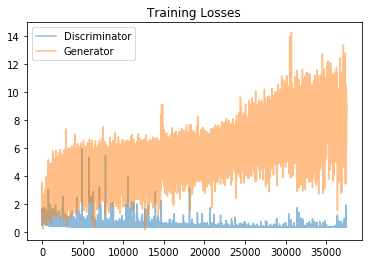

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

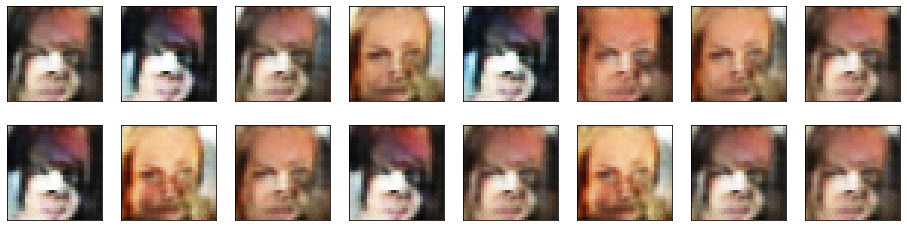

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
* The samples generated are very noisy because we took only 32*32 images which probably get rid of many important features 
* As the dataset is biased it is mostly creating white or brownish faces most common for celebrities
* Number of epochs is 500 and even after that I don't think it has reached it's plateu as the generator has a lot of up and down tendency at that point we could have trained for another 500 epochs and probably then it would have been a little better
* There is sort overlapping which is porobably caused by low resolution of training images and can be avoided if we have takeen 256*256 images
* The netwrok is not deep enough for this kind of complicated task, probably creating tywice deeper netwrok would have been better.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.